In [1]:
import pandas as pd
dataset= pd.read_csv(r"C:\Users\rafi\Desktop\master pro\EB7_by_LA1.csv", encoding= 'unicode_escape', delimiter= ',')
print(dataset)

dataset

dataset['EnergyUseAveragePerDwelling'] = dataset['EnergyUseAveragePerDwelling'].astype(int)
dataset['AverageFloorArea'] = dataset['AverageFloorArea'].astype(int)
dataset

      AverageFloorArea  Year/Quarter  Property Type  \
0                 14.0             1              5   
1                 14.0             4              1   
2                 19.0             1              4   
3                 20.0             1              1   
4                 20.0             1              2   
...                ...           ...            ...   
1621             156.0             3              3   
1622             156.0             3              4   
1623             156.0             4              4   
1624             157.0             2              3   
1625             157.0             4              3   

      EnergyUseAveragePerDwelling  
0                           356.0  
1                           468.0  
2                           375.0  
3                           464.5  
4                           366.0  
...                           ...  
1621                        253.0  
1622                        289.0  
1623           

,AverageFloorArea,Year/Quarter,Property Type,EnergyUseAveragePerDwelling
0,14,1,5,356
1,14,4,1,468
2,19,1,4,375
3,20,1,1,464
4,20,1,2,366
...,...,...,...,...
1621,156,3,3,253
1622,156,3,4,289
1623,156,4,4,220
1624,157,2,3,316


In [2]:
from sklearn.model_selection import train_test_split
X=dataset.drop('EnergyUseAveragePerDwelling',axis=1)
Y=dataset['EnergyUseAveragePerDwelling']
X_train, X_test, Y_train, Y_test =train_test_split(X,Y, test_size=0.3, random_state = 0)
X


,AverageFloorArea,Year/Quarter,Property Type
0,14,1,5
1,14,4,1
2,19,1,4
3,20,1,1
4,20,1,2
...,...,...,...
1621,156,3,3
1622,156,3,4
1623,156,4,4
1624,157,2,3


## Random forest with keras tuner dense

In [24]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
RF= RandomForestRegressor(n_estimators=200,random_state=30)
RF.fit(X_train.values,Y_train.values)

RandomForestRegressor(n_estimators=200, random_state=30)

In [25]:
prediction = np.squeeze(RF.predict([[80,2,2]]))
print("Prediction: {}".format(prediction))

Prediction: 316.535


In [26]:
y_prd=RF.predict(X_test.values)
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

      Actual  predict  differences
443      287  291.330       -4.330
319      317  303.215       13.785
703      295  257.125       37.875
526      320  311.885        8.115
76       435  354.295       80.705
...      ...      ...          ...
1232     287  283.515        3.485
330      296  307.215      -11.215
1087     274  272.830        1.170
789      321  318.845        2.155
1618     314  254.965       59.035

[488 rows x 3 columns]


In [27]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

-130.365
-159.76999999999998
168.56
168.12
-166.60500000000002
157.14999999999998
152.45
-130.565
136.88
135.90499999999997
135.77999999999997
lower bound: -124.91962465220428
upper bound: 124.51273940630264


In [28]:
A.drop(A[(A['differences'] >124)].index, inplace=True)
A.drop(A[(A['differences'] <-124)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

      AverageFloorArea  Year/Quarter  Property Type  Actual  predict
1                   14             4              1     468  362.360
2                   19             1              4     375  368.640
4                   20             1              2     366  362.835
5                   20             4              1     485  369.465
9                   23             2              5     408  449.390
...                ...           ...            ...     ...      ...
1616               155             2              3     242  276.180
1618               155             4              3     314  254.965
1619               156             1              3     275  270.680
1622               156             3              4     289  269.170
1625               157             4              3     254  270.690

[476 rows x 5 columns]


In [29]:
from sklearn.model_selection import train_test_split
X1=B.drop('Actual',axis=1)
Y1=B['Actual']
X_train1, X_test1, Y_train1, Y_test1 =train_test_split(X1,Y1, test_size=0.3, random_state = 0)

In [30]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
import kerastuner
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [31]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project1',project_name='A1')

tuner.search(X_train1,Y_train1 ,epochs=100,validation_data=(X_test1,Y_test1))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model1 = tuner.hypermodel.build(best_hps)
model1.fit(X_train1, Y_train1, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project1\A1\oracle.json
INFO:tensorflow:Reloading Tuner from project1\A1\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
8/8 [==============================] - 1s 27ms/step - loss: 292.7910 - mean_absolute_error: 292.7910 - val_loss: 211.8054 - val_mean_absolute_error: 211.8054
Epoch 2/2000
8/8 [==============================] - 0s 8ms/step - loss: 129.4624 - mean_absolute_error: 129.4624 - val_loss: 99.0572 - val_mean_absolute_error: 99.0572
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 95.8912 - mean_absolute_error: 95.8912 - val_loss: 115.8098 - val_mean_absolute_error: 115.8098
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 83.4906 - mean_absolute_error: 83.4906 - val_loss: 24.0951 - val_mean_absolute_error: 24.0951
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 51.3472 - mean_absolute_error: 51.3472 - val_loss: 43.3289 - val_mean_absolut

Epoch 49/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.1105 - mean_absolute_error: 30.1105 - val_loss: 21.5959 - val_mean_absolute_error: 21.5959
Epoch 50/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.3568 - mean_absolute_error: 28.3568 - val_loss: 22.7549 - val_mean_absolute_error: 22.7549
Epoch 51/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.8817 - mean_absolute_error: 27.8817 - val_loss: 26.6954 - val_mean_absolute_error: 26.6954
Epoch 52/2000
8/8 [==============================] - 0s 8ms/step - loss: 28.5072 - mean_absolute_error: 28.5072 - val_loss: 28.3197 - val_mean_absolute_error: 28.3197
Epoch 53/2000
8/8 [==============================] - 0s 7ms/step - loss: 30.5800 - mean_absolute_error: 30.5800 - val_loss: 26.7849 - val_mean_absolute_error: 26.7849
Epoch 54/2000
8/8 [==============================] - 0s 8ms/step - loss: 29.2865 - mean_absolute_error: 29.2865 - val_loss: 23.3554 - val_mean_absolute_error: 23.355

8/8 [==============================] - 0s 6ms/step - loss: 26.5244 - mean_absolute_error: 26.5244 - val_loss: 20.7374 - val_mean_absolute_error: 20.7374
Epoch 99/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.9143 - mean_absolute_error: 27.9143 - val_loss: 20.0450 - val_mean_absolute_error: 20.0450
Epoch 100/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.2116 - mean_absolute_error: 27.2116 - val_loss: 22.3734 - val_mean_absolute_error: 22.3734
Epoch 101/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.2142 - mean_absolute_error: 27.2142 - val_loss: 20.3824 - val_mean_absolute_error: 20.3824
Epoch 102/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.3460 - mean_absolute_error: 30.3460 - val_loss: 27.8865 - val_mean_absolute_error: 27.8865
Epoch 103/2000
8/8 [==============================] - 0s 7ms/step - loss: 29.5425 - mean_absolute_error: 29.5425 - val_loss: 19.0612 - val_mean_absolute_error: 19.0612
Epoch 10

Epoch 147/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.7796 - mean_absolute_error: 25.7796 - val_loss: 25.3478 - val_mean_absolute_error: 25.3478
Epoch 148/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.7120 - mean_absolute_error: 27.7120 - val_loss: 19.4791 - val_mean_absolute_error: 19.4791
Epoch 149/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.4773 - mean_absolute_error: 26.4773 - val_loss: 19.6571 - val_mean_absolute_error: 19.6571
Epoch 150/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.5341 - mean_absolute_error: 27.5341 - val_loss: 24.8526 - val_mean_absolute_error: 24.8526
Epoch 151/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.7243 - mean_absolute_error: 27.7243 - val_loss: 27.2929 - val_mean_absolute_error: 27.2929
Epoch 152/2000
8/8 [==============================] - 0s 8ms/step - loss: 28.8549 - mean_absolute_error: 28.8549 - val_loss: 22.2416 - val_mean_absolute_error: 

Epoch 196/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.3132 - mean_absolute_error: 26.3132 - val_loss: 19.0523 - val_mean_absolute_error: 19.0523
Epoch 197/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.9767 - mean_absolute_error: 26.9767 - val_loss: 23.7624 - val_mean_absolute_error: 23.7624
Epoch 198/2000
8/8 [==============================] - 0s 8ms/step - loss: 29.5070 - mean_absolute_error: 29.5070 - val_loss: 19.0148 - val_mean_absolute_error: 19.0148
Epoch 199/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.8865 - mean_absolute_error: 25.8865 - val_loss: 19.9300 - val_mean_absolute_error: 19.9300
Epoch 200/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.7046 - mean_absolute_error: 26.7046 - val_loss: 18.8165 - val_mean_absolute_error: 18.8165
Epoch 201/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.4083 - mean_absolute_error: 25.4083 - val_loss: 20.1977 - val_mean_absolute_error: 

Epoch 245/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.4236 - mean_absolute_error: 26.4236 - val_loss: 19.4234 - val_mean_absolute_error: 19.4234
Epoch 246/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.7170 - mean_absolute_error: 25.7170 - val_loss: 19.3550 - val_mean_absolute_error: 19.3550
Epoch 247/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.5840 - mean_absolute_error: 25.5840 - val_loss: 24.0664 - val_mean_absolute_error: 24.0664
Epoch 248/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.4600 - mean_absolute_error: 27.4600 - val_loss: 19.4665 - val_mean_absolute_error: 19.4665
Epoch 249/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.0886 - mean_absolute_error: 27.0886 - val_loss: 25.3194 - val_mean_absolute_error: 25.3194
Epoch 250/2000
8/8 [==============================] - 0s 7ms/step - loss: 33.3173 - mean_absolute_error: 33.3173 - val_loss: 20.1725 - val_mean_absolute_error: 

Epoch 294/2000
8/8 [==============================] - 0s 6ms/step - loss: 29.7829 - mean_absolute_error: 29.7829 - val_loss: 23.0435 - val_mean_absolute_error: 23.0435
Epoch 295/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.4509 - mean_absolute_error: 28.4509 - val_loss: 22.0202 - val_mean_absolute_error: 22.0202
Epoch 296/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.1755 - mean_absolute_error: 26.1755 - val_loss: 19.0441 - val_mean_absolute_error: 19.0441
Epoch 297/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.4984 - mean_absolute_error: 25.4984 - val_loss: 20.7849 - val_mean_absolute_error: 20.7849
Epoch 298/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.5554 - mean_absolute_error: 27.5554 - val_loss: 24.0235 - val_mean_absolute_error: 24.0235
Epoch 299/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.0149 - mean_absolute_error: 27.0149 - val_loss: 20.0665 - val_mean_absolute_error: 

Epoch 343/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.3926 - mean_absolute_error: 25.3926 - val_loss: 19.3584 - val_mean_absolute_error: 19.3584
Epoch 344/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.6255 - mean_absolute_error: 25.6255 - val_loss: 19.3593 - val_mean_absolute_error: 19.3593
Epoch 345/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.0131 - mean_absolute_error: 26.0131 - val_loss: 26.5076 - val_mean_absolute_error: 26.5076
Epoch 346/2000
8/8 [==============================] - 0s 8ms/step - loss: 29.3481 - mean_absolute_error: 29.3481 - val_loss: 24.4003 - val_mean_absolute_error: 24.4003
Epoch 347/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.2455 - mean_absolute_error: 26.2455 - val_loss: 20.0168 - val_mean_absolute_error: 20.0168
Epoch 348/2000
8/8 [==============================] - 0s 8ms/step - loss: 28.2826 - mean_absolute_error: 28.2826 - val_loss: 22.2783 - val_mean_absolute_error: 

Epoch 392/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.6327 - mean_absolute_error: 26.6327 - val_loss: 23.1518 - val_mean_absolute_error: 23.1518
Epoch 393/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.3079 - mean_absolute_error: 26.3079 - val_loss: 21.5680 - val_mean_absolute_error: 21.5680
Epoch 394/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.9682 - mean_absolute_error: 26.9682 - val_loss: 19.4644 - val_mean_absolute_error: 19.4644
Epoch 395/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.7798 - mean_absolute_error: 25.7798 - val_loss: 19.2433 - val_mean_absolute_error: 19.2433
Epoch 396/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.1223 - mean_absolute_error: 26.1223 - val_loss: 19.2121 - val_mean_absolute_error: 19.2121
Epoch 397/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.5214 - mean_absolute_error: 26.5214 - val_loss: 24.6479 - val_mean_absolute_error: 

Epoch 441/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.8785 - mean_absolute_error: 25.8785 - val_loss: 18.9145 - val_mean_absolute_error: 18.9145
Epoch 442/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.4768 - mean_absolute_error: 25.4768 - val_loss: 18.4455 - val_mean_absolute_error: 18.4455
Epoch 443/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.2362 - mean_absolute_error: 25.2362 - val_loss: 21.1610 - val_mean_absolute_error: 21.1610
Epoch 444/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.9824 - mean_absolute_error: 26.9824 - val_loss: 25.9508 - val_mean_absolute_error: 25.9508
Epoch 445/2000
8/8 [==============================] - 0s 8ms/step - loss: 29.0673 - mean_absolute_error: 29.0673 - val_loss: 25.8439 - val_mean_absolute_error: 25.8439
Epoch 446/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.7442 - mean_absolute_error: 27.7442 - val_loss: 18.6401 - val_mean_absolute_error: 

Epoch 490/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.9212 - mean_absolute_error: 25.9212 - val_loss: 22.5106 - val_mean_absolute_error: 22.5106
Epoch 491/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.1408 - mean_absolute_error: 27.1408 - val_loss: 20.1111 - val_mean_absolute_error: 20.1111
Epoch 492/2000
8/8 [==============================] - 0s 6ms/step - loss: 28.7326 - mean_absolute_error: 28.7326 - val_loss: 21.7285 - val_mean_absolute_error: 21.7285
Epoch 493/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.4690 - mean_absolute_error: 30.4690 - val_loss: 20.8508 - val_mean_absolute_error: 20.8508
Epoch 494/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.0698 - mean_absolute_error: 27.0698 - val_loss: 19.5290 - val_mean_absolute_error: 19.5290
Epoch 495/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.3560 - mean_absolute_error: 28.3560 - val_loss: 20.5947 - val_mean_absolute_error: 

Epoch 539/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.7579 - mean_absolute_error: 25.7579 - val_loss: 19.9159 - val_mean_absolute_error: 19.9159
Epoch 540/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.1136 - mean_absolute_error: 26.1136 - val_loss: 20.8882 - val_mean_absolute_error: 20.8882
Epoch 541/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.0347 - mean_absolute_error: 27.0347 - val_loss: 33.1320 - val_mean_absolute_error: 33.1320
Epoch 542/2000
8/8 [==============================] - 0s 8ms/step - loss: 36.1208 - mean_absolute_error: 36.1208 - val_loss: 20.3547 - val_mean_absolute_error: 20.3547
Epoch 543/2000
8/8 [==============================] - 0s 7ms/step - loss: 29.3680 - mean_absolute_error: 29.3680 - val_loss: 18.3134 - val_mean_absolute_error: 18.3134
Epoch 544/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.2065 - mean_absolute_error: 26.2065 - val_loss: 21.9892 - val_mean_absolute_error: 

Epoch 588/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.5163 - mean_absolute_error: 25.5163 - val_loss: 18.8432 - val_mean_absolute_error: 18.8432
Epoch 589/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.5422 - mean_absolute_error: 25.5422 - val_loss: 18.3166 - val_mean_absolute_error: 18.3166
Epoch 590/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.9987 - mean_absolute_error: 25.9987 - val_loss: 21.0787 - val_mean_absolute_error: 21.0787
Epoch 591/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.8257 - mean_absolute_error: 26.8257 - val_loss: 20.8857 - val_mean_absolute_error: 20.8857
Epoch 592/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.3029 - mean_absolute_error: 26.3029 - val_loss: 18.3060 - val_mean_absolute_error: 18.3060
Epoch 593/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.7372 - mean_absolute_error: 25.7372 - val_loss: 21.5982 - val_mean_absolute_error: 

Epoch 637/2000
8/8 [==============================] - 0s 7ms/step - loss: 29.2918 - mean_absolute_error: 29.2918 - val_loss: 18.2921 - val_mean_absolute_error: 18.2921
Epoch 638/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.6427 - mean_absolute_error: 25.6427 - val_loss: 20.1773 - val_mean_absolute_error: 20.1773
Epoch 639/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.2649 - mean_absolute_error: 26.2649 - val_loss: 18.1501 - val_mean_absolute_error: 18.1501
Epoch 640/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.3481 - mean_absolute_error: 26.3481 - val_loss: 19.8246 - val_mean_absolute_error: 19.8246
Epoch 641/2000
8/8 [==============================] - 0s 6ms/step - loss: 28.0365 - mean_absolute_error: 28.0365 - val_loss: 18.2148 - val_mean_absolute_error: 18.2148
Epoch 642/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.0119 - mean_absolute_error: 25.0119 - val_loss: 19.7122 - val_mean_absolute_error: 

Epoch 686/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.1034 - mean_absolute_error: 25.1034 - val_loss: 19.6553 - val_mean_absolute_error: 19.6553
Epoch 687/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.2616 - mean_absolute_error: 25.2616 - val_loss: 18.8438 - val_mean_absolute_error: 18.8438
Epoch 688/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.9587 - mean_absolute_error: 25.9587 - val_loss: 18.1884 - val_mean_absolute_error: 18.1884
Epoch 689/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.8898 - mean_absolute_error: 25.8898 - val_loss: 20.6738 - val_mean_absolute_error: 20.6738
Epoch 690/2000
8/8 [==============================] - 0s 5ms/step - loss: 26.0103 - mean_absolute_error: 26.0103 - val_loss: 20.0656 - val_mean_absolute_error: 20.0656
Epoch 691/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.7241 - mean_absolute_error: 25.7241 - val_loss: 18.2447 - val_mean_absolute_error: 

Epoch 735/2000
8/8 [==============================] - 0s 6ms/step - loss: 31.2729 - mean_absolute_error: 31.2729 - val_loss: 28.9385 - val_mean_absolute_error: 28.9385
Epoch 736/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.3363 - mean_absolute_error: 30.3363 - val_loss: 19.8236 - val_mean_absolute_error: 19.8236
Epoch 737/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.2222 - mean_absolute_error: 25.2222 - val_loss: 18.2095 - val_mean_absolute_error: 18.2095
Epoch 738/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.8430 - mean_absolute_error: 24.8430 - val_loss: 18.4266 - val_mean_absolute_error: 18.4266
Epoch 739/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.7168 - mean_absolute_error: 24.7168 - val_loss: 19.9020 - val_mean_absolute_error: 19.9020
Epoch 740/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.4802 - mean_absolute_error: 25.4802 - val_loss: 19.4331 - val_mean_absolute_error: 

Epoch 784/2000
8/8 [==============================] - 0s 6ms/step - loss: 28.3703 - mean_absolute_error: 28.3703 - val_loss: 22.0108 - val_mean_absolute_error: 22.0108
Epoch 785/2000
8/8 [==============================] - 0s 6ms/step - loss: 31.3467 - mean_absolute_error: 31.3467 - val_loss: 21.2692 - val_mean_absolute_error: 21.2692
Epoch 786/2000
8/8 [==============================] - 0s 7ms/step - loss: 31.1616 - mean_absolute_error: 31.1616 - val_loss: 31.3791 - val_mean_absolute_error: 31.3791
Epoch 787/2000
8/8 [==============================] - 0s 7ms/step - loss: 31.0592 - mean_absolute_error: 31.0592 - val_loss: 23.7932 - val_mean_absolute_error: 23.7932
Epoch 788/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.1767 - mean_absolute_error: 27.1767 - val_loss: 24.9672 - val_mean_absolute_error: 24.9672
Epoch 789/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.7864 - mean_absolute_error: 28.7864 - val_loss: 29.5814 - val_mean_absolute_error: 

Epoch 833/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.8760 - mean_absolute_error: 27.8760 - val_loss: 20.9268 - val_mean_absolute_error: 20.9268
Epoch 834/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.7113 - mean_absolute_error: 26.7113 - val_loss: 18.6144 - val_mean_absolute_error: 18.6144
Epoch 835/2000
8/8 [==============================] - 0s 8ms/step - loss: 24.8199 - mean_absolute_error: 24.8199 - val_loss: 18.0633 - val_mean_absolute_error: 18.0633
Epoch 836/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.0840 - mean_absolute_error: 26.0840 - val_loss: 22.0125 - val_mean_absolute_error: 22.0125
Epoch 837/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.4367 - mean_absolute_error: 27.4367 - val_loss: 19.3464 - val_mean_absolute_error: 19.3464
Epoch 838/2000
8/8 [==============================] - 0s 6ms/step - loss: 28.0052 - mean_absolute_error: 28.0052 - val_loss: 18.7683 - val_mean_absolute_error: 

Epoch 882/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.2021 - mean_absolute_error: 25.2021 - val_loss: 18.1639 - val_mean_absolute_error: 18.1639
Epoch 883/2000
8/8 [==============================] - 0s 5ms/step - loss: 26.0021 - mean_absolute_error: 26.0021 - val_loss: 18.7173 - val_mean_absolute_error: 18.7173
Epoch 884/2000
8/8 [==============================] - 0s 5ms/step - loss: 27.9741 - mean_absolute_error: 27.9741 - val_loss: 18.8734 - val_mean_absolute_error: 18.8734
Epoch 885/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.9764 - mean_absolute_error: 24.9764 - val_loss: 18.7327 - val_mean_absolute_error: 18.7327
Epoch 886/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.2481 - mean_absolute_error: 25.2481 - val_loss: 18.3223 - val_mean_absolute_error: 18.3223
Epoch 887/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.9396 - mean_absolute_error: 24.9396 - val_loss: 18.0391 - val_mean_absolute_error: 

Epoch 931/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.3092 - mean_absolute_error: 26.3092 - val_loss: 24.0117 - val_mean_absolute_error: 24.0117
Epoch 932/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.9464 - mean_absolute_error: 26.9464 - val_loss: 18.7262 - val_mean_absolute_error: 18.7262
Epoch 933/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.9635 - mean_absolute_error: 24.9635 - val_loss: 18.5813 - val_mean_absolute_error: 18.5813
Epoch 934/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.6647 - mean_absolute_error: 24.6647 - val_loss: 18.3973 - val_mean_absolute_error: 18.3973
Epoch 935/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.7052 - mean_absolute_error: 24.7052 - val_loss: 22.5852 - val_mean_absolute_error: 22.5852
Epoch 936/2000
8/8 [==============================] - 0s 6ms/step - loss: 29.1554 - mean_absolute_error: 29.1554 - val_loss: 24.3120 - val_mean_absolute_error: 

Epoch 980/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.2103 - mean_absolute_error: 25.2103 - val_loss: 22.1456 - val_mean_absolute_error: 22.1456
Epoch 981/2000
8/8 [==============================] - 0s 5ms/step - loss: 26.4093 - mean_absolute_error: 26.4093 - val_loss: 22.2443 - val_mean_absolute_error: 22.2443
Epoch 982/2000
8/8 [==============================] - 0s 5ms/step - loss: 26.3392 - mean_absolute_error: 26.3392 - val_loss: 18.0626 - val_mean_absolute_error: 18.0626
Epoch 983/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.9325 - mean_absolute_error: 24.9325 - val_loss: 18.1189 - val_mean_absolute_error: 18.1189
Epoch 984/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.5368 - mean_absolute_error: 24.5368 - val_loss: 18.8350 - val_mean_absolute_error: 18.8350
Epoch 985/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.3164 - mean_absolute_error: 25.3164 - val_loss: 18.0454 - val_mean_absolute_error: 

8/8 [==============================] - 0s 6ms/step - loss: 29.0423 - mean_absolute_error: 29.0423 - val_loss: 28.9203 - val_mean_absolute_error: 28.9203
Epoch 1077/2000
8/8 [==============================] - 0s 7ms/step - loss: 33.5706 - mean_absolute_error: 33.5706 - val_loss: 31.5737 - val_mean_absolute_error: 31.5737
Epoch 1078/2000
8/8 [==============================] - 0s 7ms/step - loss: 34.0864 - mean_absolute_error: 34.0864 - val_loss: 20.1531 - val_mean_absolute_error: 20.1531
Epoch 1079/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.3227 - mean_absolute_error: 28.3227 - val_loss: 21.1688 - val_mean_absolute_error: 21.1688
Epoch 1080/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.5599 - mean_absolute_error: 25.5599 - val_loss: 20.4282 - val_mean_absolute_error: 20.4282
Epoch 1081/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.3967 - mean_absolute_error: 25.3967 - val_loss: 22.6655 - val_mean_absolute_error: 22.6655
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.5951 - mean_absolute_error: 24.5951 - val_loss: 18.0484 - val_mean_absolute_error: 18.0484
Epoch 1173/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.8983 - mean_absolute_error: 24.8983 - val_loss: 18.5452 - val_mean_absolute_error: 18.5452
Epoch 1174/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.9934 - mean_absolute_error: 24.9934 - val_loss: 19.9345 - val_mean_absolute_error: 19.9345
Epoch 1175/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.0523 - mean_absolute_error: 25.0523 - val_loss: 18.1252 - val_mean_absolute_error: 18.1252
Epoch 1176/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.9996 - mean_absolute_error: 24.9996 - val_loss: 19.0298 - val_mean_absolute_error: 19.0298
Epoch 1177/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.3366 - mean_absolute_error: 26.3366 - val_loss: 19.6057 - val_mean_absolute_error: 19.6057
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.6423 - mean_absolute_error: 24.6423 - val_loss: 18.4000 - val_mean_absolute_error: 18.4000
Epoch 1269/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.8038 - mean_absolute_error: 24.8038 - val_loss: 18.4358 - val_mean_absolute_error: 18.4358
Epoch 1270/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.2385 - mean_absolute_error: 25.2385 - val_loss: 17.8408 - val_mean_absolute_error: 17.8408
Epoch 1271/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.0424 - mean_absolute_error: 25.0424 - val_loss: 17.7178 - val_mean_absolute_error: 17.7178
Epoch 1272/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.9614 - mean_absolute_error: 24.9614 - val_loss: 19.5330 - val_mean_absolute_error: 19.5330
Epoch 1273/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.9564 - mean_absolute_error: 24.9564 - val_loss: 17.8461 - val_mean_absolute_error: 17.8461
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.7393 - mean_absolute_error: 24.7393 - val_loss: 21.4677 - val_mean_absolute_error: 21.4677
Epoch 1365/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.5747 - mean_absolute_error: 25.5747 - val_loss: 20.8527 - val_mean_absolute_error: 20.8527
Epoch 1366/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.2968 - mean_absolute_error: 24.2968 - val_loss: 19.1954 - val_mean_absolute_error: 19.1954
Epoch 1367/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.5319 - mean_absolute_error: 24.5319 - val_loss: 18.3316 - val_mean_absolute_error: 18.3316
Epoch 1368/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.6153 - mean_absolute_error: 24.6153 - val_loss: 18.3570 - val_mean_absolute_error: 18.3570
Epoch 1369/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.8111 - mean_absolute_error: 24.8111 - val_loss: 22.2881 - val_mean_absolute_error: 22.2881
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.5076 - mean_absolute_error: 24.5076 - val_loss: 19.4694 - val_mean_absolute_error: 19.4694
Epoch 1461/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.0852 - mean_absolute_error: 25.0852 - val_loss: 17.7042 - val_mean_absolute_error: 17.7042
Epoch 1462/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.0979 - mean_absolute_error: 24.0979 - val_loss: 17.8534 - val_mean_absolute_error: 17.8534
Epoch 1463/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.1923 - mean_absolute_error: 24.1923 - val_loss: 20.6536 - val_mean_absolute_error: 20.6536
Epoch 1464/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.9235 - mean_absolute_error: 25.9235 - val_loss: 18.4775 - val_mean_absolute_error: 18.4775
Epoch 1465/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.4582 - mean_absolute_error: 24.4582 - val_loss: 18.3902 - val_mean_absolute_error: 18.3902
Ep

8/8 [==============================] - 0s 7ms/step - loss: 24.6873 - mean_absolute_error: 24.6873 - val_loss: 18.9306 - val_mean_absolute_error: 18.9306
Epoch 1557/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.2061 - mean_absolute_error: 24.2061 - val_loss: 18.2065 - val_mean_absolute_error: 18.2065
Epoch 1558/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.5551 - mean_absolute_error: 24.5551 - val_loss: 18.0681 - val_mean_absolute_error: 18.0681
Epoch 1559/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.1170 - mean_absolute_error: 30.1170 - val_loss: 24.4603 - val_mean_absolute_error: 24.4603
Epoch 1560/2000
8/8 [==============================] - 0s 6ms/step - loss: 32.0221 - mean_absolute_error: 32.0221 - val_loss: 33.1840 - val_mean_absolute_error: 33.1840
Epoch 1561/2000
8/8 [==============================] - 0s 7ms/step - loss: 30.8877 - mean_absolute_error: 30.8877 - val_loss: 25.2364 - val_mean_absolute_error: 25.2364
Ep

8/8 [==============================] - 0s 6ms/step - loss: 26.3028 - mean_absolute_error: 26.3028 - val_loss: 21.8816 - val_mean_absolute_error: 21.8816
Epoch 1653/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.2708 - mean_absolute_error: 27.2708 - val_loss: 27.1813 - val_mean_absolute_error: 27.1813
Epoch 1654/2000
8/8 [==============================] - 0s 6ms/step - loss: 30.0498 - mean_absolute_error: 30.0498 - val_loss: 20.5841 - val_mean_absolute_error: 20.5841
Epoch 1655/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.5736 - mean_absolute_error: 27.5736 - val_loss: 18.0102 - val_mean_absolute_error: 18.0102
Epoch 1656/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.3330 - mean_absolute_error: 24.3330 - val_loss: 20.2516 - val_mean_absolute_error: 20.2516
Epoch 1657/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.1591 - mean_absolute_error: 26.1591 - val_loss: 18.2402 - val_mean_absolute_error: 18.2402
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.5182 - mean_absolute_error: 24.5182 - val_loss: 25.6901 - val_mean_absolute_error: 25.6901
Epoch 1749/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.9477 - mean_absolute_error: 26.9477 - val_loss: 20.2132 - val_mean_absolute_error: 20.2132
Epoch 1750/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.5679 - mean_absolute_error: 24.5679 - val_loss: 18.0641 - val_mean_absolute_error: 18.0641
Epoch 1751/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.1346 - mean_absolute_error: 24.1346 - val_loss: 17.8451 - val_mean_absolute_error: 17.8451
Epoch 1752/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.1225 - mean_absolute_error: 24.1225 - val_loss: 17.8173 - val_mean_absolute_error: 17.8173
Epoch 1753/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.5868 - mean_absolute_error: 24.5868 - val_loss: 19.2080 - val_mean_absolute_error: 19.2080
Ep

8/8 [==============================] - 0s 6ms/step - loss: 31.6193 - mean_absolute_error: 31.6193 - val_loss: 21.9134 - val_mean_absolute_error: 21.9134
Epoch 1845/2000
8/8 [==============================] - 0s 6ms/step - loss: 28.8622 - mean_absolute_error: 28.8622 - val_loss: 17.8415 - val_mean_absolute_error: 17.8415
Epoch 1846/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.7932 - mean_absolute_error: 24.7932 - val_loss: 20.4317 - val_mean_absolute_error: 20.4317
Epoch 1847/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.0000 - mean_absolute_error: 26.0000 - val_loss: 20.5639 - val_mean_absolute_error: 20.5639
Epoch 1848/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.2008 - mean_absolute_error: 25.2008 - val_loss: 21.7823 - val_mean_absolute_error: 21.7823
Epoch 1849/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.8091 - mean_absolute_error: 24.8091 - val_loss: 20.4443 - val_mean_absolute_error: 20.4443
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.6796 - mean_absolute_error: 24.6796 - val_loss: 18.5689 - val_mean_absolute_error: 18.5689
Epoch 1941/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.3280 - mean_absolute_error: 24.3280 - val_loss: 20.9316 - val_mean_absolute_error: 20.9316
Epoch 1942/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.0700 - mean_absolute_error: 25.0700 - val_loss: 17.8717 - val_mean_absolute_error: 17.8717
Epoch 1943/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.2677 - mean_absolute_error: 25.2677 - val_loss: 19.9128 - val_mean_absolute_error: 19.9128
Epoch 1944/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.9651 - mean_absolute_error: 25.9651 - val_loss: 20.9179 - val_mean_absolute_error: 20.9179
Epoch 1945/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.3237 - mean_absolute_error: 26.3237 - val_loss: 21.5271 - val_mean_absolute_error: 21.5271
Ep

5/5 [==============================] - 0s 2ms/step
r2_score: 0.40338514640632184
5/5 [==============================] - 0s 2ms/step
mean squired error: 988.5263631792569
mean absolute error: 24.20038780799279
5/5 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Actual vs predicted')

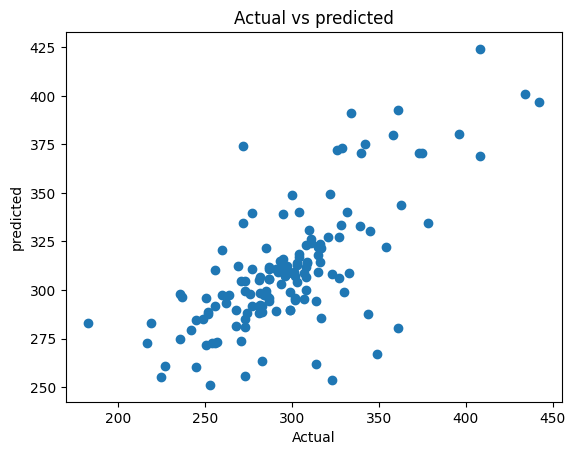

In [32]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test1, np.squeeze(model1.predict(X_test1)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test1, np.squeeze(model1.predict(X_test1)) )
mae= mean_absolute_error(Y_test1, np.squeeze(model1.predict(X_test1)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test1, np.squeeze(model1.predict(X_test1)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [33]:
prediction1 =np.squeeze(model1.predict([[80,2,2,prediction]]))
print("Prediction: {}".format(prediction1))

y_prd=np.squeeze(np.squeeze(model1.predict(X_test1)) )
predic_dif=pd.DataFrame({'Actual':Y_test1,'predict':y_prd,"differences":Y_test1-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 64ms/step
Prediction: 323.30255126953125
5/5 [==============================] - 0s 1ms/step


,Actual,predict,differences
796,249,285.333160,-36.333160
538,269,312.198151,-43.198151
1027,304,318.527954,-14.527954
1196,183,282.908997,-99.908997
342,294,312.269287,-18.269287
1493,256,272.970215,-16.970215
1285,302,295.817780,6.182220
970,282,292.145905,-10.145905
276,295,339.139954,-44.139954
1612,236,275.027832,-39.027832


## RNN with Keras tuner dense

In [3]:
from keras.layers import Dense, Dropout,Activation, LSTM
from keras.models import Sequential
model2=Sequential()
model2.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],1)))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, activation='relu', return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(units=32, activation='relu', return_sequences=True))
model2.add(Dropout(0.4))
model2.add(LSTM(units=64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=1))
model2.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 3, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                2

In [4]:
model2.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
25/25 [==============================] - 7s 49ms/step - loss: 89687.7422 - mae: 295.8148 - val_loss: 70736.3750 - val_mae: 258.4168
Epoch 2/2000
25/25 [==============================] - 0s 14ms/step - loss: 35245.5195 - mae: 155.9259 - val_loss: 13034.3818 - val_mae: 88.9594
Epoch 3/2000
25/25 [==============================] - 0s 15ms/step - loss: 16724.9609 - mae: 102.9972 - val_loss: 3701.8088 - val_mae: 44.4802
Epoch 4/2000
25/25 [==============================] - 0s 12ms/step - loss: 10556.3525 - mae: 80.9570 - val_loss: 6261.8687 - val_mae: 66.4915
Epoch 5/2000
25/25 [==============================] - 0s 14ms/step - loss: 8974.0537 - mae: 75.4837 - val_loss: 4414.3130 - val_mae: 54.3557
Epoch 6/2000
25/25 [==============================] - 0s 15ms/step - loss: 8447.8457 - mae: 72.1989 - val_loss: 3815.1853 - val_mae: 48.3393
Epoch 7/2000
25/25 [==============================] - 0s 14ms/step - loss: 7687.1147 - mae: 69.2084 - val_loss: 3845.1323 - val_mae: 48.9028
Epo

Epoch 59/2000
25/25 [==============================] - 0s 13ms/step - loss: 4045.1042 - mae: 49.0883 - val_loss: 2879.9731 - val_mae: 37.4983
Epoch 60/2000
25/25 [==============================] - 0s 11ms/step - loss: 3928.8213 - mae: 48.5297 - val_loss: 2579.3586 - val_mae: 33.9462
Epoch 61/2000
25/25 [==============================] - 0s 11ms/step - loss: 3897.6335 - mae: 46.5303 - val_loss: 3417.2126 - val_mae: 44.5635
Epoch 62/2000
25/25 [==============================] - 0s 11ms/step - loss: 3543.6816 - mae: 45.7249 - val_loss: 2447.7378 - val_mae: 32.3304
Epoch 63/2000
25/25 [==============================] - 0s 11ms/step - loss: 3968.8345 - mae: 48.9654 - val_loss: 3318.9619 - val_mae: 42.7363
Epoch 64/2000
25/25 [==============================] - 0s 11ms/step - loss: 4002.5994 - mae: 47.9668 - val_loss: 2745.9192 - val_mae: 36.3342
Epoch 65/2000
25/25 [==============================] - 0s 11ms/step - loss: 3703.5833 - mae: 46.5301 - val_loss: 2570.0566 - val_mae: 33.6798
Epoch 

25/25 [==============================] - 0s 11ms/step - loss: 3354.5808 - mae: 43.6390 - val_loss: 2331.5039 - val_mae: 30.9974
Epoch 174/2000
25/25 [==============================] - 0s 11ms/step - loss: 3338.4629 - mae: 43.8210 - val_loss: 2306.2136 - val_mae: 30.7922
Epoch 175/2000
25/25 [==============================] - 0s 11ms/step - loss: 3214.4170 - mae: 43.3595 - val_loss: 2251.3098 - val_mae: 30.6075
Epoch 176/2000
25/25 [==============================] - 0s 11ms/step - loss: 3501.6926 - mae: 44.8603 - val_loss: 2319.1394 - val_mae: 30.9215
Epoch 177/2000
25/25 [==============================] - 0s 11ms/step - loss: 3675.1082 - mae: 45.5362 - val_loss: 2430.6064 - val_mae: 31.9627
Epoch 178/2000
25/25 [==============================] - 0s 12ms/step - loss: 3437.2410 - mae: 44.2261 - val_loss: 2356.3196 - val_mae: 31.3380
Epoch 179/2000
25/25 [==============================] - 0s 13ms/step - loss: 3158.5886 - mae: 42.7413 - val_loss: 2476.0359 - val_mae: 32.5036
Epoch 180/2000

25/25 [==============================] - 0s 15ms/step - loss: 3286.5571 - mae: 43.0940 - val_loss: 2783.6785 - val_mae: 36.1426
Epoch 288/2000
25/25 [==============================] - 0s 15ms/step - loss: 3352.4695 - mae: 43.8306 - val_loss: 2253.8752 - val_mae: 29.4876
Epoch 289/2000
25/25 [==============================] - 0s 13ms/step - loss: 3211.7214 - mae: 42.9297 - val_loss: 2198.6211 - val_mae: 29.5266
Epoch 290/2000
25/25 [==============================] - 0s 13ms/step - loss: 3276.6919 - mae: 43.8435 - val_loss: 2323.7598 - val_mae: 30.6600
Epoch 291/2000
25/25 [==============================] - 0s 14ms/step - loss: 3552.4104 - mae: 46.1623 - val_loss: 2232.2598 - val_mae: 30.0593
Epoch 292/2000
25/25 [==============================] - 0s 13ms/step - loss: 3095.0701 - mae: 42.4702 - val_loss: 2244.4851 - val_mae: 31.3930
Epoch 293/2000
25/25 [==============================] - 0s 13ms/step - loss: 3035.1621 - mae: 42.0660 - val_loss: 2304.5549 - val_mae: 30.0714
Epoch 294/2000

25/25 [==============================] - 0s 13ms/step - loss: 3226.2007 - mae: 42.7047 - val_loss: 2447.7395 - val_mae: 32.2358
Epoch 402/2000
25/25 [==============================] - 0s 13ms/step - loss: 3315.3740 - mae: 43.5254 - val_loss: 2548.8186 - val_mae: 33.1722
Epoch 403/2000
25/25 [==============================] - 0s 13ms/step - loss: 3365.7222 - mae: 43.8813 - val_loss: 2228.5852 - val_mae: 29.1991
Epoch 404/2000
25/25 [==============================] - 0s 13ms/step - loss: 3267.0776 - mae: 43.6185 - val_loss: 2286.3850 - val_mae: 29.4220
Epoch 405/2000
25/25 [==============================] - 0s 13ms/step - loss: 3382.1140 - mae: 44.0502 - val_loss: 2327.6121 - val_mae: 30.3386
Epoch 406/2000
25/25 [==============================] - 0s 13ms/step - loss: 3351.3171 - mae: 43.6283 - val_loss: 2229.6909 - val_mae: 29.3332
Epoch 407/2000
25/25 [==============================] - 0s 13ms/step - loss: 2964.1699 - mae: 41.6111 - val_loss: 2357.1904 - val_mae: 30.8604
Epoch 408/2000

25/25 [==============================] - 0s 11ms/step - loss: 3132.9514 - mae: 41.4233 - val_loss: 2142.2412 - val_mae: 28.3187
Epoch 516/2000
25/25 [==============================] - 0s 11ms/step - loss: 3174.9111 - mae: 42.4671 - val_loss: 2289.4897 - val_mae: 30.0626
Epoch 517/2000
25/25 [==============================] - 0s 11ms/step - loss: 3372.2859 - mae: 43.3668 - val_loss: 2378.3608 - val_mae: 31.4069
Epoch 518/2000
25/25 [==============================] - 0s 11ms/step - loss: 3180.3655 - mae: 42.9817 - val_loss: 2467.0708 - val_mae: 32.1477
Epoch 519/2000
25/25 [==============================] - 0s 11ms/step - loss: 3081.7361 - mae: 42.5781 - val_loss: 2152.2476 - val_mae: 28.5564
Epoch 520/2000
25/25 [==============================] - 0s 11ms/step - loss: 2934.8784 - mae: 40.9069 - val_loss: 2317.7351 - val_mae: 30.5570
Epoch 521/2000
25/25 [==============================] - 0s 11ms/step - loss: 3020.6646 - mae: 41.2942 - val_loss: 2168.1829 - val_mae: 29.3282
Epoch 522/2000

25/25 [==============================] - 0s 13ms/step - loss: 2980.4297 - mae: 41.1795 - val_loss: 2199.8782 - val_mae: 29.0699
Epoch 630/2000
25/25 [==============================] - 0s 13ms/step - loss: 2899.1577 - mae: 40.3328 - val_loss: 2281.1055 - val_mae: 29.9744
Epoch 631/2000
25/25 [==============================] - 0s 13ms/step - loss: 3172.5396 - mae: 43.2798 - val_loss: 2396.0127 - val_mae: 31.3317
Epoch 632/2000
25/25 [==============================] - 0s 14ms/step - loss: 3214.0300 - mae: 43.2924 - val_loss: 2373.7512 - val_mae: 30.9133
Epoch 633/2000
25/25 [==============================] - 0s 15ms/step - loss: 3198.0803 - mae: 41.7842 - val_loss: 2176.6348 - val_mae: 28.8481
Epoch 634/2000
25/25 [==============================] - 0s 13ms/step - loss: 3082.8191 - mae: 42.5442 - val_loss: 2240.8196 - val_mae: 29.6518
Epoch 635/2000
25/25 [==============================] - 0s 13ms/step - loss: 3360.1692 - mae: 44.2500 - val_loss: 2207.2854 - val_mae: 29.1612
Epoch 636/2000

25/25 [==============================] - 0s 14ms/step - loss: 3037.9858 - mae: 41.7984 - val_loss: 2251.4197 - val_mae: 29.6165
Epoch 744/2000
25/25 [==============================] - 0s 13ms/step - loss: 3124.4976 - mae: 42.2038 - val_loss: 2128.6995 - val_mae: 28.5015
Epoch 745/2000
25/25 [==============================] - 0s 13ms/step - loss: 3048.4250 - mae: 41.4260 - val_loss: 2199.5054 - val_mae: 28.8349
Epoch 746/2000
25/25 [==============================] - 0s 13ms/step - loss: 3162.0229 - mae: 42.4987 - val_loss: 2254.3333 - val_mae: 29.5358
Epoch 747/2000
25/25 [==============================] - 0s 13ms/step - loss: 2898.2065 - mae: 41.0418 - val_loss: 2161.4915 - val_mae: 28.5648
Epoch 748/2000
25/25 [==============================] - 0s 13ms/step - loss: 2911.7346 - mae: 40.8492 - val_loss: 2133.5803 - val_mae: 28.1915
Epoch 749/2000
25/25 [==============================] - 0s 14ms/step - loss: 3319.2578 - mae: 44.3059 - val_loss: 2262.0991 - val_mae: 29.8964
Epoch 750/2000

25/25 [==============================] - 0s 13ms/step - loss: 3219.9985 - mae: 42.9050 - val_loss: 2404.2810 - val_mae: 31.4289
Epoch 858/2000
25/25 [==============================] - 0s 12ms/step - loss: 3163.4988 - mae: 41.8768 - val_loss: 2182.8044 - val_mae: 28.9017
Epoch 859/2000
25/25 [==============================] - 0s 11ms/step - loss: 2920.2085 - mae: 41.4862 - val_loss: 2259.6233 - val_mae: 29.5244
Epoch 860/2000
25/25 [==============================] - 0s 11ms/step - loss: 3180.5547 - mae: 41.9285 - val_loss: 2193.1521 - val_mae: 28.9327
Epoch 861/2000
25/25 [==============================] - 0s 11ms/step - loss: 3032.3484 - mae: 41.2030 - val_loss: 2161.4978 - val_mae: 28.3196
Epoch 862/2000
25/25 [==============================] - 0s 11ms/step - loss: 2946.8816 - mae: 40.3733 - val_loss: 2210.3352 - val_mae: 29.4986
Epoch 863/2000
25/25 [==============================] - 0s 11ms/step - loss: 3118.5029 - mae: 42.9552 - val_loss: 2385.4868 - val_mae: 31.0937
Epoch 864/2000

25/25 [==============================] - 0s 12ms/step - loss: 3036.4434 - mae: 42.3424 - val_loss: 2405.9429 - val_mae: 31.2417
Epoch 972/2000
25/25 [==============================] - 0s 13ms/step - loss: 2996.3132 - mae: 41.6059 - val_loss: 2481.0183 - val_mae: 32.0625
Epoch 973/2000
25/25 [==============================] - 0s 15ms/step - loss: 3125.9373 - mae: 43.0633 - val_loss: 2450.0403 - val_mae: 32.1296
Epoch 974/2000
25/25 [==============================] - 0s 14ms/step - loss: 3002.1589 - mae: 41.7648 - val_loss: 2341.2236 - val_mae: 30.8138
Epoch 975/2000
25/25 [==============================] - 0s 15ms/step - loss: 2920.7358 - mae: 40.3351 - val_loss: 2435.6814 - val_mae: 31.1359
Epoch 976/2000
25/25 [==============================] - 0s 13ms/step - loss: 2987.0803 - mae: 41.2045 - val_loss: 2179.7300 - val_mae: 28.7584
Epoch 977/2000
25/25 [==============================] - 0s 16ms/step - loss: 2766.5676 - mae: 40.1769 - val_loss: 2183.3955 - val_mae: 28.9907
Epoch 978/2000

25/25 [==============================] - 0s 13ms/step - loss: 2952.4346 - mae: 41.2375 - val_loss: 2173.0613 - val_mae: 28.4035
Epoch 1086/2000
25/25 [==============================] - 0s 14ms/step - loss: 3009.1262 - mae: 41.4895 - val_loss: 2167.2644 - val_mae: 28.2942
Epoch 1087/2000
25/25 [==============================] - 0s 13ms/step - loss: 2797.7349 - mae: 40.0946 - val_loss: 2294.7063 - val_mae: 30.1408
Epoch 1088/2000
25/25 [==============================] - 0s 13ms/step - loss: 2659.8337 - mae: 39.8649 - val_loss: 2337.0862 - val_mae: 30.4717
Epoch 1089/2000
25/25 [==============================] - 0s 13ms/step - loss: 2615.3943 - mae: 38.8237 - val_loss: 2293.1230 - val_mae: 30.1953
Epoch 1090/2000
25/25 [==============================] - 0s 13ms/step - loss: 3123.7278 - mae: 42.0708 - val_loss: 2317.0242 - val_mae: 30.1574
Epoch 1091/2000
25/25 [==============================] - 0s 13ms/step - loss: 2967.8052 - mae: 41.9520 - val_loss: 2237.4685 - val_mae: 29.4631
Epoch 10

25/25 [==============================] - 0s 12ms/step - loss: 3300.8281 - mae: 42.4983 - val_loss: 2187.3474 - val_mae: 28.7487
Epoch 1143/2000
25/25 [==============================] - 0s 12ms/step - loss: 2831.5886 - mae: 41.1538 - val_loss: 2201.1340 - val_mae: 28.7782
Epoch 1144/2000
25/25 [==============================] - 0s 12ms/step - loss: 3008.6812 - mae: 42.1394 - val_loss: 2266.3970 - val_mae: 28.6705
Epoch 1145/2000
25/25 [==============================] - 0s 13ms/step - loss: 2980.6064 - mae: 41.8006 - val_loss: 2259.9690 - val_mae: 29.0185
Epoch 1146/2000
25/25 [==============================] - 0s 13ms/step - loss: 3086.4944 - mae: 41.3006 - val_loss: 2240.5542 - val_mae: 28.8291
Epoch 1147/2000
25/25 [==============================] - 0s 12ms/step - loss: 2875.1865 - mae: 41.5081 - val_loss: 2204.5718 - val_mae: 29.0006
Epoch 1148/2000
25/25 [==============================] - 0s 12ms/step - loss: 2831.8391 - mae: 40.8830 - val_loss: 2541.9524 - val_mae: 33.2882
Epoch 11

25/25 [==============================] - 0s 11ms/step - loss: 2923.0635 - mae: 41.5631 - val_loss: 2268.3892 - val_mae: 29.8103
Epoch 1200/2000
25/25 [==============================] - 0s 11ms/step - loss: 2686.6843 - mae: 39.5483 - val_loss: 2189.7810 - val_mae: 29.0286
Epoch 1201/2000
25/25 [==============================] - 0s 11ms/step - loss: 2817.0857 - mae: 39.6852 - val_loss: 2242.9597 - val_mae: 29.1327
Epoch 1202/2000
25/25 [==============================] - 0s 11ms/step - loss: 2642.0381 - mae: 39.2828 - val_loss: 2181.8467 - val_mae: 28.3899
Epoch 1203/2000
25/25 [==============================] - 0s 11ms/step - loss: 2913.3430 - mae: 40.9768 - val_loss: 2175.0352 - val_mae: 28.4638
Epoch 1204/2000
25/25 [==============================] - 0s 11ms/step - loss: 2623.9028 - mae: 39.3170 - val_loss: 2197.9375 - val_mae: 28.7267
Epoch 1205/2000
25/25 [==============================] - 0s 13ms/step - loss: 2918.0479 - mae: 41.4336 - val_loss: 2233.7327 - val_mae: 28.9520
Epoch 12

25/25 [==============================] - 0s 12ms/step - loss: 2738.6550 - mae: 38.8570 - val_loss: 2254.1279 - val_mae: 29.0216
Epoch 1257/2000
25/25 [==============================] - 0s 12ms/step - loss: 2661.4631 - mae: 39.2531 - val_loss: 2252.3125 - val_mae: 29.1265
Epoch 1258/2000
25/25 [==============================] - 0s 12ms/step - loss: 2909.1084 - mae: 40.8101 - val_loss: 2195.7522 - val_mae: 28.6535
Epoch 1259/2000
25/25 [==============================] - 0s 12ms/step - loss: 2757.7947 - mae: 38.6913 - val_loss: 2262.2351 - val_mae: 29.2650
Epoch 1260/2000
25/25 [==============================] - 0s 12ms/step - loss: 2699.1746 - mae: 39.8870 - val_loss: 2230.7090 - val_mae: 28.9174
Epoch 1261/2000
25/25 [==============================] - 0s 13ms/step - loss: 2919.3435 - mae: 40.2556 - val_loss: 2304.3733 - val_mae: 29.4924
Epoch 1262/2000
25/25 [==============================] - 0s 12ms/step - loss: 2816.3586 - mae: 40.6649 - val_loss: 2229.0730 - val_mae: 28.8724
Epoch 12

25/25 [==============================] - 0s 12ms/step - loss: 2793.5393 - mae: 40.3305 - val_loss: 2274.7100 - val_mae: 29.6708
Epoch 1314/2000
25/25 [==============================] - 0s 11ms/step - loss: 2753.1052 - mae: 39.5151 - val_loss: 2311.3057 - val_mae: 30.1483
Epoch 1315/2000
25/25 [==============================] - 0s 12ms/step - loss: 2843.3740 - mae: 40.6318 - val_loss: 2335.9917 - val_mae: 30.4082
Epoch 1316/2000
25/25 [==============================] - 0s 11ms/step - loss: 2773.7603 - mae: 40.7446 - val_loss: 2203.8809 - val_mae: 28.5359
Epoch 1317/2000
25/25 [==============================] - 0s 11ms/step - loss: 2657.9866 - mae: 39.0599 - val_loss: 2231.6204 - val_mae: 29.4207
Epoch 1318/2000
25/25 [==============================] - 0s 11ms/step - loss: 2643.6675 - mae: 38.6430 - val_loss: 2237.4487 - val_mae: 29.0022
Epoch 1319/2000
25/25 [==============================] - 0s 11ms/step - loss: 2650.7656 - mae: 39.5672 - val_loss: 2128.6501 - val_mae: 28.7026
Epoch 13

25/25 [==============================] - 0s 12ms/step - loss: 2938.9592 - mae: 40.3080 - val_loss: 2254.3145 - val_mae: 29.3519
Epoch 1371/2000
25/25 [==============================] - 0s 13ms/step - loss: 2821.4910 - mae: 40.6492 - val_loss: 2208.6970 - val_mae: 28.9182
Epoch 1372/2000
25/25 [==============================] - 0s 13ms/step - loss: 2966.6919 - mae: 40.6515 - val_loss: 2194.8284 - val_mae: 29.4772
Epoch 1373/2000
25/25 [==============================] - 0s 12ms/step - loss: 2910.2795 - mae: 40.5438 - val_loss: 2163.9045 - val_mae: 28.7626
Epoch 1374/2000
25/25 [==============================] - 0s 12ms/step - loss: 2949.3401 - mae: 41.9986 - val_loss: 2204.7039 - val_mae: 29.0706
Epoch 1375/2000
25/25 [==============================] - 0s 13ms/step - loss: 2798.6199 - mae: 40.5937 - val_loss: 2377.5061 - val_mae: 30.2143
Epoch 1376/2000
25/25 [==============================] - 0s 12ms/step - loss: 2744.4387 - mae: 40.2598 - val_loss: 2270.5535 - val_mae: 29.4101
Epoch 13

25/25 [==============================] - 0s 12ms/step - loss: 2842.1772 - mae: 41.0379 - val_loss: 2267.3381 - val_mae: 29.2332
Epoch 1428/2000
25/25 [==============================] - 0s 13ms/step - loss: 2914.1238 - mae: 40.9945 - val_loss: 2276.5627 - val_mae: 29.2089
Epoch 1429/2000
25/25 [==============================] - 0s 13ms/step - loss: 2959.1624 - mae: 40.7812 - val_loss: 2334.0513 - val_mae: 30.3509
Epoch 1430/2000
25/25 [==============================] - 0s 12ms/step - loss: 2584.3586 - mae: 39.1302 - val_loss: 2197.6450 - val_mae: 28.7628
Epoch 1431/2000
25/25 [==============================] - 0s 12ms/step - loss: 2797.2244 - mae: 40.3260 - val_loss: 2289.6980 - val_mae: 29.5188
Epoch 1432/2000
25/25 [==============================] - 0s 12ms/step - loss: 2731.9077 - mae: 39.7506 - val_loss: 2282.7292 - val_mae: 29.8132
Epoch 1433/2000
25/25 [==============================] - 0s 14ms/step - loss: 2969.5469 - mae: 39.9947 - val_loss: 2464.4116 - val_mae: 31.4793
Epoch 14

25/25 [==============================] - 0s 13ms/step - loss: 3119.6418 - mae: 42.2945 - val_loss: 2187.3252 - val_mae: 28.6900
Epoch 1485/2000
25/25 [==============================] - 0s 12ms/step - loss: 2836.9651 - mae: 40.3366 - val_loss: 2339.6660 - val_mae: 30.3456
Epoch 1486/2000
25/25 [==============================] - 0s 12ms/step - loss: 2715.2524 - mae: 39.9365 - val_loss: 2462.1763 - val_mae: 30.2419
Epoch 1487/2000
25/25 [==============================] - 0s 12ms/step - loss: 2762.8223 - mae: 39.7923 - val_loss: 2352.9563 - val_mae: 29.1777
Epoch 1488/2000
25/25 [==============================] - 0s 13ms/step - loss: 2907.0913 - mae: 39.9835 - val_loss: 2318.7773 - val_mae: 29.9123
Epoch 1489/2000
25/25 [==============================] - 0s 12ms/step - loss: 2743.1199 - mae: 39.7463 - val_loss: 2410.6187 - val_mae: 31.7297
Epoch 1490/2000
25/25 [==============================] - 0s 13ms/step - loss: 2521.1338 - mae: 39.2067 - val_loss: 2378.0291 - val_mae: 30.8736
Epoch 14

25/25 [==============================] - 0s 14ms/step - loss: 2910.6548 - mae: 41.0829 - val_loss: 2371.1301 - val_mae: 29.1797
Epoch 1542/2000
25/25 [==============================] - 0s 13ms/step - loss: 2820.2434 - mae: 40.5949 - val_loss: 2290.6636 - val_mae: 29.2541
Epoch 1543/2000
25/25 [==============================] - 0s 13ms/step - loss: 2677.8269 - mae: 39.5670 - val_loss: 2175.0378 - val_mae: 28.8909
Epoch 1544/2000
25/25 [==============================] - 0s 13ms/step - loss: 2750.0500 - mae: 40.6113 - val_loss: 2262.3264 - val_mae: 29.1351
Epoch 1545/2000
25/25 [==============================] - 0s 14ms/step - loss: 2850.1912 - mae: 40.8597 - val_loss: 2350.4299 - val_mae: 30.6400
Epoch 1546/2000
25/25 [==============================] - 0s 13ms/step - loss: 2849.0144 - mae: 39.6169 - val_loss: 2246.9309 - val_mae: 29.3987
Epoch 1547/2000
25/25 [==============================] - 0s 13ms/step - loss: 2616.4514 - mae: 39.8061 - val_loss: 2272.6704 - val_mae: 29.1920
Epoch 15

25/25 [==============================] - 0s 11ms/step - loss: 2876.9456 - mae: 40.7537 - val_loss: 2273.1282 - val_mae: 29.2730
Epoch 1599/2000
25/25 [==============================] - 0s 11ms/step - loss: 2787.9187 - mae: 40.9850 - val_loss: 2374.0344 - val_mae: 29.7514
Epoch 1600/2000
25/25 [==============================] - 0s 11ms/step - loss: 2672.2896 - mae: 38.4379 - val_loss: 2216.5002 - val_mae: 28.6572
Epoch 1601/2000
25/25 [==============================] - 0s 11ms/step - loss: 2943.2498 - mae: 40.9787 - val_loss: 2198.5686 - val_mae: 28.4136
Epoch 1602/2000
25/25 [==============================] - 0s 11ms/step - loss: 2456.4299 - mae: 38.6197 - val_loss: 2349.2483 - val_mae: 29.0774
Epoch 1603/2000
25/25 [==============================] - 0s 11ms/step - loss: 2871.4517 - mae: 40.9601 - val_loss: 2258.4058 - val_mae: 29.0681
Epoch 1604/2000
25/25 [==============================] - 0s 11ms/step - loss: 2700.0896 - mae: 39.4124 - val_loss: 2267.1731 - val_mae: 29.1855
Epoch 16

25/25 [==============================] - 0s 11ms/step - loss: 2589.3284 - mae: 37.9532 - val_loss: 2151.0647 - val_mae: 28.9545
Epoch 1656/2000
25/25 [==============================] - 0s 11ms/step - loss: 2731.9363 - mae: 39.3061 - val_loss: 2148.1980 - val_mae: 28.2279
Epoch 1657/2000
25/25 [==============================] - 0s 11ms/step - loss: 2592.1855 - mae: 38.6724 - val_loss: 2203.0164 - val_mae: 28.6268
Epoch 1658/2000
25/25 [==============================] - 0s 11ms/step - loss: 2810.6846 - mae: 39.9676 - val_loss: 2153.5388 - val_mae: 28.5418
Epoch 1659/2000
25/25 [==============================] - 0s 11ms/step - loss: 2975.7058 - mae: 41.9861 - val_loss: 2190.4072 - val_mae: 28.4695
Epoch 1660/2000
25/25 [==============================] - 0s 11ms/step - loss: 2737.3018 - mae: 40.6929 - val_loss: 2141.6621 - val_mae: 28.2641
Epoch 1661/2000
25/25 [==============================] - 0s 11ms/step - loss: 2675.4253 - mae: 39.4672 - val_loss: 2230.3870 - val_mae: 29.0640
Epoch 16

25/25 [==============================] - 0s 11ms/step - loss: 2505.4966 - mae: 37.8080 - val_loss: 2182.5120 - val_mae: 28.5100
Epoch 1713/2000
25/25 [==============================] - 0s 11ms/step - loss: 2741.6648 - mae: 39.6474 - val_loss: 2340.7629 - val_mae: 29.1439
Epoch 1714/2000
25/25 [==============================] - 0s 11ms/step - loss: 2853.0107 - mae: 41.1001 - val_loss: 2170.6455 - val_mae: 28.5647
Epoch 1715/2000
25/25 [==============================] - 0s 11ms/step - loss: 2650.1438 - mae: 39.4766 - val_loss: 2375.6211 - val_mae: 29.7714
Epoch 1716/2000
25/25 [==============================] - 0s 11ms/step - loss: 2654.4673 - mae: 39.1030 - val_loss: 2179.4895 - val_mae: 28.4572
Epoch 1717/2000
25/25 [==============================] - 0s 11ms/step - loss: 2474.1626 - mae: 38.5692 - val_loss: 2416.6565 - val_mae: 30.1214
Epoch 1718/2000
25/25 [==============================] - 0s 12ms/step - loss: 2830.6941 - mae: 40.5210 - val_loss: 2336.6560 - val_mae: 31.0000
Epoch 17

25/25 [==============================] - 0s 13ms/step - loss: 2729.6597 - mae: 40.4092 - val_loss: 2305.5342 - val_mae: 29.2299
Epoch 1770/2000
25/25 [==============================] - 0s 13ms/step - loss: 2745.0659 - mae: 40.3831 - val_loss: 2328.5295 - val_mae: 29.9724
Epoch 1771/2000
25/25 [==============================] - 0s 15ms/step - loss: 2707.9592 - mae: 38.9229 - val_loss: 2389.5667 - val_mae: 30.8761
Epoch 1772/2000
25/25 [==============================] - 0s 15ms/step - loss: 2795.0552 - mae: 39.5352 - val_loss: 2203.8760 - val_mae: 28.4703
Epoch 1773/2000
25/25 [==============================] - 0s 15ms/step - loss: 2939.2224 - mae: 40.6793 - val_loss: 2244.9243 - val_mae: 29.1868
Epoch 1774/2000
25/25 [==============================] - 0s 14ms/step - loss: 2915.1699 - mae: 40.8860 - val_loss: 2218.2144 - val_mae: 28.8057
Epoch 1775/2000
25/25 [==============================] - 0s 15ms/step - loss: 2428.7346 - mae: 37.9581 - val_loss: 2200.8467 - val_mae: 28.7728
Epoch 17

25/25 [==============================] - 0s 15ms/step - loss: 2571.6477 - mae: 38.4374 - val_loss: 2326.5459 - val_mae: 29.2399
Epoch 1827/2000
25/25 [==============================] - 0s 16ms/step - loss: 2783.8879 - mae: 40.0708 - val_loss: 2200.3604 - val_mae: 28.4464
Epoch 1828/2000
25/25 [==============================] - 0s 16ms/step - loss: 2629.8535 - mae: 39.3181 - val_loss: 2452.6777 - val_mae: 29.9210
Epoch 1829/2000
25/25 [==============================] - 0s 16ms/step - loss: 2778.6096 - mae: 39.2752 - val_loss: 2360.8716 - val_mae: 30.4649
Epoch 1830/2000
25/25 [==============================] - 0s 16ms/step - loss: 2632.4668 - mae: 38.8583 - val_loss: 2200.6763 - val_mae: 28.8642
Epoch 1831/2000
25/25 [==============================] - 0s 16ms/step - loss: 2727.4255 - mae: 39.0973 - val_loss: 2238.5947 - val_mae: 29.0349
Epoch 1832/2000
25/25 [==============================] - 0s 16ms/step - loss: 2701.8167 - mae: 39.7393 - val_loss: 2194.1553 - val_mae: 29.1673
Epoch 18

25/25 [==============================] - 0s 13ms/step - loss: 2668.6011 - mae: 38.9487 - val_loss: 2286.5505 - val_mae: 29.9315
Epoch 1884/2000
25/25 [==============================] - 0s 15ms/step - loss: 2646.0637 - mae: 38.5571 - val_loss: 2384.8357 - val_mae: 30.5986
Epoch 1885/2000
25/25 [==============================] - 0s 14ms/step - loss: 2646.1445 - mae: 38.1196 - val_loss: 2409.4783 - val_mae: 30.2330
Epoch 1886/2000
25/25 [==============================] - 0s 15ms/step - loss: 2652.8867 - mae: 39.2350 - val_loss: 2567.6428 - val_mae: 32.6345
Epoch 1887/2000
25/25 [==============================] - 0s 13ms/step - loss: 2813.6353 - mae: 40.3675 - val_loss: 2174.6855 - val_mae: 28.7267
Epoch 1888/2000
25/25 [==============================] - 0s 14ms/step - loss: 2913.9866 - mae: 40.1520 - val_loss: 2181.3252 - val_mae: 28.5064
Epoch 1889/2000
25/25 [==============================] - 0s 13ms/step - loss: 2644.4077 - mae: 39.5198 - val_loss: 2242.9407 - val_mae: 28.5797
Epoch 18

25/25 [==============================] - 0s 14ms/step - loss: 2660.0623 - mae: 38.2842 - val_loss: 2229.6143 - val_mae: 29.1165
Epoch 1941/2000
25/25 [==============================] - 0s 15ms/step - loss: 2673.6353 - mae: 39.0792 - val_loss: 2268.6687 - val_mae: 29.3611
Epoch 1942/2000
25/25 [==============================] - 0s 15ms/step - loss: 2634.5117 - mae: 39.7453 - val_loss: 2388.6516 - val_mae: 29.7722
Epoch 1943/2000
25/25 [==============================] - 0s 15ms/step - loss: 2611.5386 - mae: 38.7399 - val_loss: 2246.4224 - val_mae: 28.9966
Epoch 1944/2000
25/25 [==============================] - 0s 14ms/step - loss: 2719.5120 - mae: 39.3967 - val_loss: 2333.2371 - val_mae: 30.5745
Epoch 1945/2000
25/25 [==============================] - 0s 13ms/step - loss: 2771.6160 - mae: 39.7730 - val_loss: 2416.0208 - val_mae: 31.3618
Epoch 1946/2000
25/25 [==============================] - 0s 14ms/step - loss: 2526.5444 - mae: 38.5713 - val_loss: 2304.0728 - val_mae: 29.0818
Epoch 19

25/25 [==============================] - 0s 12ms/step - loss: 2582.1296 - mae: 39.5740 - val_loss: 2218.7932 - val_mae: 28.8750
Epoch 1998/2000
25/25 [==============================] - 0s 12ms/step - loss: 2612.6287 - mae: 38.8916 - val_loss: 2376.9578 - val_mae: 29.5424
Epoch 1999/2000
25/25 [==============================] - 0s 12ms/step - loss: 2450.6729 - mae: 37.9415 - val_loss: 2205.3982 - val_mae: 28.8451
Epoch 2000/2000
25/25 [==============================] - 0s 12ms/step - loss: 2590.3987 - mae: 38.9176 - val_loss: 2240.7498 - val_mae: 28.7451


In [6]:
prediction2 = np.squeeze(model2.predict([[80,2,2]]))
print("Prediction: {}".format(prediction2))

1/1 [==============================] - 1s 755ms/step
Prediction: 379.73345947265625


In [8]:
y_prd=np.squeeze(np.squeeze(model2.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

16/16 [==============================] - 0s 4ms/step
      Actual     predict  differences
443      287  298.035278   -11.035278
319      317  304.642822    12.357178
703      295  282.513275    12.486725
526      320  310.989319     9.010681
76       435  378.426758    56.573242
...      ...         ...          ...
1232     287  298.584442   -11.584442
330      296  300.536255    -4.536255
1087     274  283.286530    -9.286530
789      321  306.266724    14.733276
1618     314  272.164886    41.835114

[488 rows x 3 columns]


In [13]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

-142.3966064453125
-153.4658203125
180.82589721679688
178.8189697265625
-204.56890869140625
141.72821044921875
119.8389892578125
167.53704833984375
145.81939697265625
129.07968139648438
164.06842041015625
130.77114868164062
142.33251953125
lower bound: -121.4334593896763
upper bound: 119.48608720329693


In [17]:
A.drop(A[(A['differences'] >119)].index, inplace=True)
A.drop(A[(A['differences'] <-121)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X2=B.drop('Actual',axis=1)
Y2=B['Actual']
X_train2, X_test2, Y_train2, Y_test2 =train_test_split(X2,Y2, test_size=0.3, random_state = 0)

      AverageFloorArea  Year/Quarter  Property Type  Actual     predict
1                   14             4              1     468  444.914093
2                   19             1              4     375  372.813599
4                   20             1              2     366  450.182617
5                   20             4              1     485  379.851898
9                   23             2              5     408  484.988434
...                ...           ...            ...     ...         ...
1616               155             2              3     242  272.115021
1618               155             4              3     314  272.164886
1619               156             1              3     275  284.280853
1622               156             3              4     289  272.167603
1625               157             4              3     254  272.162476

[475 rows x 5 columns]


In [18]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
import kerastuner
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

C:\Users\rafi\AppData\Local\Temp\ipykernel_3616\3496013807.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


In [19]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project1',project_name='A1')

tuner.search(X_train2,Y_train2 ,epochs=100,validation_data=(X_test2,Y_test2))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model3 = tuner.hypermodel.build(best_hps)
model3.fit(X_train2, Y_train2, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project1\A1\oracle.json
INFO:tensorflow:Reloading Tuner from project1\A1\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
8/8 [==============================] - 1s 22ms/step - loss: 290.0364 - mean_absolute_error: 290.0364 - val_loss: 208.9921 - val_mean_absolute_error: 208.9921
Epoch 2/2000
8/8 [==============================] - 0s 7ms/step - loss: 122.1430 - mean_absolute_error: 122.1430 - val_loss: 94.8425 - val_mean_absolute_error: 94.8425
Epoch 3/2000
8/8 [==============================] - 0s 7ms/step - loss: 85.7956 - mean_absolute_error: 85.7956 - val_loss: 60.9608 - val_mean_absolute_error: 60.9608
Epoch 4/2000
8/8 [==============================] - 0s 7ms/step - loss: 51.7045 - mean_absolute_error: 51.7045 - val_loss: 59.9226 - val_mean_absolute_error: 59.9226
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 46.0535 - mean_absolute_error: 46.0535 - val_loss: 46.0372 - val_mean_absolute_

8/8 [==============================] - 0s 6ms/step - loss: 30.1386 - mean_absolute_error: 30.1386 - val_loss: 19.2012 - val_mean_absolute_error: 19.2012
Epoch 50/2000
8/8 [==============================] - 0s 6ms/step - loss: 29.1289 - mean_absolute_error: 29.1289 - val_loss: 29.4951 - val_mean_absolute_error: 29.4951
Epoch 51/2000
8/8 [==============================] - 0s 6ms/step - loss: 29.0909 - mean_absolute_error: 29.0909 - val_loss: 19.2077 - val_mean_absolute_error: 19.2077
Epoch 52/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.6338 - mean_absolute_error: 23.6338 - val_loss: 27.0949 - val_mean_absolute_error: 27.0949
Epoch 53/2000
8/8 [==============================] - 0s 7ms/step - loss: 27.6522 - mean_absolute_error: 27.6522 - val_loss: 19.9379 - val_mean_absolute_error: 19.9379
Epoch 54/2000
8/8 [==============================] - 0s 8ms/step - loss: 28.3957 - mean_absolute_error: 28.3957 - val_loss: 20.7757 - val_mean_absolute_error: 20.7757
Epoch 55/200

Epoch 147/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.6809 - mean_absolute_error: 24.6809 - val_loss: 22.8205 - val_mean_absolute_error: 22.8205
Epoch 148/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.5050 - mean_absolute_error: 27.5050 - val_loss: 29.4778 - val_mean_absolute_error: 29.4778
Epoch 149/2000
8/8 [==============================] - 0s 6ms/step - loss: 27.9669 - mean_absolute_error: 27.9669 - val_loss: 31.5559 - val_mean_absolute_error: 31.5559
Epoch 150/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.8338 - mean_absolute_error: 26.8338 - val_loss: 23.8251 - val_mean_absolute_error: 23.8251
Epoch 151/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.9130 - mean_absolute_error: 25.9130 - val_loss: 19.3668 - val_mean_absolute_error: 19.3668
Epoch 152/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.1784 - mean_absolute_error: 24.1784 - val_loss: 33.7599 - val_mean_absolute_error: 

Epoch 196/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.1379 - mean_absolute_error: 23.1379 - val_loss: 20.0220 - val_mean_absolute_error: 20.0220
Epoch 197/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3521 - mean_absolute_error: 22.3521 - val_loss: 18.9748 - val_mean_absolute_error: 18.9748
Epoch 198/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.7364 - mean_absolute_error: 22.7364 - val_loss: 20.5086 - val_mean_absolute_error: 20.5086
Epoch 199/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.2246 - mean_absolute_error: 24.2246 - val_loss: 23.0077 - val_mean_absolute_error: 23.0077
Epoch 200/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.4615 - mean_absolute_error: 23.4615 - val_loss: 26.7870 - val_mean_absolute_error: 26.7870
Epoch 201/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.7071 - mean_absolute_error: 26.7071 - val_loss: 36.0703 - val_mean_absolute_error: 

Epoch 245/2000
8/8 [==============================] - 0s 5ms/step - loss: 30.9078 - mean_absolute_error: 30.9078 - val_loss: 25.8581 - val_mean_absolute_error: 25.8581
Epoch 246/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.2847 - mean_absolute_error: 26.2847 - val_loss: 28.7046 - val_mean_absolute_error: 28.7046
Epoch 247/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.0011 - mean_absolute_error: 26.0011 - val_loss: 29.1503 - val_mean_absolute_error: 29.1503
Epoch 248/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.5416 - mean_absolute_error: 25.5416 - val_loss: 26.4123 - val_mean_absolute_error: 26.4123
Epoch 249/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.2730 - mean_absolute_error: 25.2730 - val_loss: 19.5079 - val_mean_absolute_error: 19.5079
Epoch 250/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.6043 - mean_absolute_error: 23.6043 - val_loss: 20.7073 - val_mean_absolute_error: 

Epoch 294/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.5193 - mean_absolute_error: 23.5193 - val_loss: 20.5801 - val_mean_absolute_error: 20.5801
Epoch 295/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.1747 - mean_absolute_error: 23.1747 - val_loss: 19.0622 - val_mean_absolute_error: 19.0622
Epoch 296/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.3796 - mean_absolute_error: 22.3796 - val_loss: 19.4811 - val_mean_absolute_error: 19.4811
Epoch 297/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.6907 - mean_absolute_error: 22.6907 - val_loss: 22.3874 - val_mean_absolute_error: 22.3874
Epoch 298/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.0530 - mean_absolute_error: 23.0530 - val_loss: 22.1660 - val_mean_absolute_error: 22.1660
Epoch 299/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.1299 - mean_absolute_error: 23.1299 - val_loss: 20.6523 - val_mean_absolute_error: 

Epoch 343/2000
8/8 [==============================] - 0s 10ms/step - loss: 23.5873 - mean_absolute_error: 23.5873 - val_loss: 19.0357 - val_mean_absolute_error: 19.0357
Epoch 344/2000
8/8 [==============================] - 0s 8ms/step - loss: 22.8072 - mean_absolute_error: 22.8072 - val_loss: 23.9838 - val_mean_absolute_error: 23.9838
Epoch 345/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.3992 - mean_absolute_error: 24.3992 - val_loss: 19.5668 - val_mean_absolute_error: 19.5668
Epoch 346/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.3643 - mean_absolute_error: 23.3643 - val_loss: 20.4356 - val_mean_absolute_error: 20.4356
Epoch 347/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.6684 - mean_absolute_error: 23.6684 - val_loss: 19.1672 - val_mean_absolute_error: 19.1672
Epoch 348/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.3332 - mean_absolute_error: 23.3332 - val_loss: 23.3198 - val_mean_absolute_error:

Epoch 392/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.0140 - mean_absolute_error: 25.0140 - val_loss: 26.0033 - val_mean_absolute_error: 26.0033
Epoch 393/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.0731 - mean_absolute_error: 25.0731 - val_loss: 25.3805 - val_mean_absolute_error: 25.3805
Epoch 394/2000
8/8 [==============================] - 0s 7ms/step - loss: 28.6671 - mean_absolute_error: 28.6671 - val_loss: 31.0727 - val_mean_absolute_error: 31.0727
Epoch 395/2000
8/8 [==============================] - 0s 5ms/step - loss: 27.2366 - mean_absolute_error: 27.2366 - val_loss: 34.3837 - val_mean_absolute_error: 34.3837
Epoch 396/2000
8/8 [==============================] - 0s 5ms/step - loss: 28.5600 - mean_absolute_error: 28.5600 - val_loss: 35.0862 - val_mean_absolute_error: 35.0862
Epoch 397/2000
8/8 [==============================] - 0s 5ms/step - loss: 30.0557 - mean_absolute_error: 30.0557 - val_loss: 27.8989 - val_mean_absolute_error: 

Epoch 441/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.1608 - mean_absolute_error: 24.1608 - val_loss: 19.2515 - val_mean_absolute_error: 19.2515
Epoch 442/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.4317 - mean_absolute_error: 22.4317 - val_loss: 19.4413 - val_mean_absolute_error: 19.4413
Epoch 443/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.2272 - mean_absolute_error: 23.2272 - val_loss: 31.4854 - val_mean_absolute_error: 31.4854
Epoch 444/2000
8/8 [==============================] - 0s 9ms/step - loss: 29.5729 - mean_absolute_error: 29.5729 - val_loss: 19.5879 - val_mean_absolute_error: 19.5879
Epoch 445/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.5492 - mean_absolute_error: 22.5492 - val_loss: 20.7300 - val_mean_absolute_error: 20.7300
Epoch 446/2000
8/8 [==============================] - 0s 8ms/step - loss: 22.4326 - mean_absolute_error: 22.4326 - val_loss: 19.2284 - val_mean_absolute_error: 

Epoch 490/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.3955 - mean_absolute_error: 23.3955 - val_loss: 22.5314 - val_mean_absolute_error: 22.5314
Epoch 491/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.3763 - mean_absolute_error: 24.3763 - val_loss: 24.8870 - val_mean_absolute_error: 24.8870
Epoch 492/2000
8/8 [==============================] - 0s 8ms/step - loss: 27.2392 - mean_absolute_error: 27.2392 - val_loss: 24.7632 - val_mean_absolute_error: 24.7632
Epoch 493/2000
8/8 [==============================] - 0s 8ms/step - loss: 24.1856 - mean_absolute_error: 24.1856 - val_loss: 22.5043 - val_mean_absolute_error: 22.5043
Epoch 494/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.5075 - mean_absolute_error: 23.5075 - val_loss: 27.1848 - val_mean_absolute_error: 27.1848
Epoch 495/2000
8/8 [==============================] - 0s 8ms/step - loss: 25.8443 - mean_absolute_error: 25.8443 - val_loss: 19.2784 - val_mean_absolute_error: 

Epoch 539/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.3746 - mean_absolute_error: 23.3746 - val_loss: 23.7531 - val_mean_absolute_error: 23.7531
Epoch 540/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.9403 - mean_absolute_error: 25.9403 - val_loss: 21.4785 - val_mean_absolute_error: 21.4785
Epoch 541/2000
8/8 [==============================] - 0s 6ms/step - loss: 29.4215 - mean_absolute_error: 29.4215 - val_loss: 23.5529 - val_mean_absolute_error: 23.5529
Epoch 542/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.5329 - mean_absolute_error: 25.5329 - val_loss: 27.4166 - val_mean_absolute_error: 27.4166
Epoch 543/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.5047 - mean_absolute_error: 23.5047 - val_loss: 19.9590 - val_mean_absolute_error: 19.9590
Epoch 544/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.6770 - mean_absolute_error: 22.6770 - val_loss: 20.1358 - val_mean_absolute_error: 

Epoch 588/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.7297 - mean_absolute_error: 23.7297 - val_loss: 24.3345 - val_mean_absolute_error: 24.3345
Epoch 589/2000
8/8 [==============================] - 0s 5ms/step - loss: 26.1137 - mean_absolute_error: 26.1137 - val_loss: 21.9728 - val_mean_absolute_error: 21.9728
Epoch 590/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.7586 - mean_absolute_error: 23.7586 - val_loss: 19.0326 - val_mean_absolute_error: 19.0326
Epoch 591/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3976 - mean_absolute_error: 22.3976 - val_loss: 19.0860 - val_mean_absolute_error: 19.0860
Epoch 592/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.5710 - mean_absolute_error: 22.5710 - val_loss: 19.2307 - val_mean_absolute_error: 19.2307
Epoch 593/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.1150 - mean_absolute_error: 23.1150 - val_loss: 21.0533 - val_mean_absolute_error: 

Epoch 637/2000
8/8 [==============================] - 0s 5ms/step - loss: 25.4916 - mean_absolute_error: 25.4916 - val_loss: 20.2044 - val_mean_absolute_error: 20.2044
Epoch 638/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.7685 - mean_absolute_error: 22.7685 - val_loss: 19.3514 - val_mean_absolute_error: 19.3514
Epoch 639/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.5369 - mean_absolute_error: 22.5369 - val_loss: 18.9891 - val_mean_absolute_error: 18.9891
Epoch 640/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.2947 - mean_absolute_error: 22.2947 - val_loss: 19.4431 - val_mean_absolute_error: 19.4431
Epoch 641/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.4291 - mean_absolute_error: 22.4291 - val_loss: 28.5873 - val_mean_absolute_error: 28.5873
Epoch 642/2000
8/8 [==============================] - 0s 5ms/step - loss: 31.0454 - mean_absolute_error: 31.0454 - val_loss: 19.7508 - val_mean_absolute_error: 

Epoch 686/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.1757 - mean_absolute_error: 23.1757 - val_loss: 19.0891 - val_mean_absolute_error: 19.0891
Epoch 687/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6450 - mean_absolute_error: 22.6450 - val_loss: 20.6326 - val_mean_absolute_error: 20.6326
Epoch 688/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.8831 - mean_absolute_error: 22.8831 - val_loss: 20.0515 - val_mean_absolute_error: 20.0515
Epoch 689/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.4762 - mean_absolute_error: 24.4762 - val_loss: 18.9698 - val_mean_absolute_error: 18.9698
Epoch 690/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.0993 - mean_absolute_error: 22.0993 - val_loss: 20.3518 - val_mean_absolute_error: 20.3518
Epoch 691/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.4289 - mean_absolute_error: 22.4289 - val_loss: 19.6822 - val_mean_absolute_error: 

Epoch 735/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.5827 - mean_absolute_error: 22.5827 - val_loss: 22.9607 - val_mean_absolute_error: 22.9607
Epoch 736/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.8778 - mean_absolute_error: 23.8778 - val_loss: 20.1649 - val_mean_absolute_error: 20.1649
Epoch 737/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.2736 - mean_absolute_error: 22.2736 - val_loss: 19.4494 - val_mean_absolute_error: 19.4494
Epoch 738/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3809 - mean_absolute_error: 22.3809 - val_loss: 19.6643 - val_mean_absolute_error: 19.6643
Epoch 739/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3894 - mean_absolute_error: 22.3894 - val_loss: 19.1858 - val_mean_absolute_error: 19.1858
Epoch 740/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6443 - mean_absolute_error: 22.6443 - val_loss: 20.3683 - val_mean_absolute_error: 

Epoch 784/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.2142 - mean_absolute_error: 22.2142 - val_loss: 19.4246 - val_mean_absolute_error: 19.4246
Epoch 785/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.4065 - mean_absolute_error: 22.4065 - val_loss: 19.6683 - val_mean_absolute_error: 19.6683
Epoch 786/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.1955 - mean_absolute_error: 22.1955 - val_loss: 19.1210 - val_mean_absolute_error: 19.1210
Epoch 787/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.3944 - mean_absolute_error: 22.3944 - val_loss: 21.2876 - val_mean_absolute_error: 21.2876
Epoch 788/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.8869 - mean_absolute_error: 24.8869 - val_loss: 19.2805 - val_mean_absolute_error: 19.2805
Epoch 789/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.7553 - mean_absolute_error: 24.7553 - val_loss: 20.3634 - val_mean_absolute_error: 

Epoch 833/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.6857 - mean_absolute_error: 23.6857 - val_loss: 20.1429 - val_mean_absolute_error: 20.1429
Epoch 834/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.9291 - mean_absolute_error: 22.9291 - val_loss: 23.2221 - val_mean_absolute_error: 23.2221
Epoch 835/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.0015 - mean_absolute_error: 24.0015 - val_loss: 19.6516 - val_mean_absolute_error: 19.6516
Epoch 836/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.5703 - mean_absolute_error: 23.5703 - val_loss: 21.7643 - val_mean_absolute_error: 21.7643
Epoch 837/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.3483 - mean_absolute_error: 25.3483 - val_loss: 20.7634 - val_mean_absolute_error: 20.7634
Epoch 838/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.8424 - mean_absolute_error: 22.8424 - val_loss: 30.4863 - val_mean_absolute_error: 

Epoch 882/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.5114 - mean_absolute_error: 24.5114 - val_loss: 19.4466 - val_mean_absolute_error: 19.4466
Epoch 883/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.5871 - mean_absolute_error: 25.5871 - val_loss: 24.0031 - val_mean_absolute_error: 24.0031
Epoch 884/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.9130 - mean_absolute_error: 25.9130 - val_loss: 27.6123 - val_mean_absolute_error: 27.6123
Epoch 885/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.6776 - mean_absolute_error: 26.6776 - val_loss: 30.6005 - val_mean_absolute_error: 30.6005
Epoch 886/2000
8/8 [==============================] - 0s 7ms/step - loss: 26.0090 - mean_absolute_error: 26.0090 - val_loss: 25.1964 - val_mean_absolute_error: 25.1964
Epoch 887/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.2930 - mean_absolute_error: 26.2930 - val_loss: 21.3861 - val_mean_absolute_error: 

Epoch 931/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.7692 - mean_absolute_error: 22.7692 - val_loss: 19.0620 - val_mean_absolute_error: 19.0620
Epoch 932/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.8872 - mean_absolute_error: 23.8872 - val_loss: 21.9672 - val_mean_absolute_error: 21.9672
Epoch 933/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.6381 - mean_absolute_error: 23.6381 - val_loss: 22.7647 - val_mean_absolute_error: 22.7647
Epoch 934/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.4541 - mean_absolute_error: 23.4541 - val_loss: 19.2286 - val_mean_absolute_error: 19.2286
Epoch 935/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.4183 - mean_absolute_error: 22.4183 - val_loss: 20.8845 - val_mean_absolute_error: 20.8845
Epoch 936/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.0689 - mean_absolute_error: 23.0689 - val_loss: 19.1959 - val_mean_absolute_error: 

Epoch 980/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.5144 - mean_absolute_error: 23.5144 - val_loss: 19.2943 - val_mean_absolute_error: 19.2943
Epoch 981/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.1073 - mean_absolute_error: 23.1073 - val_loss: 19.3890 - val_mean_absolute_error: 19.3890
Epoch 982/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.5683 - mean_absolute_error: 23.5683 - val_loss: 18.9816 - val_mean_absolute_error: 18.9816
Epoch 983/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3774 - mean_absolute_error: 22.3774 - val_loss: 21.1910 - val_mean_absolute_error: 21.1910
Epoch 984/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.1612 - mean_absolute_error: 23.1612 - val_loss: 19.8624 - val_mean_absolute_error: 19.8624
Epoch 985/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.6664 - mean_absolute_error: 23.6664 - val_loss: 19.6979 - val_mean_absolute_error: 

8/8 [==============================] - 0s 6ms/step - loss: 26.5756 - mean_absolute_error: 26.5756 - val_loss: 22.8951 - val_mean_absolute_error: 22.8951
Epoch 1077/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.7197 - mean_absolute_error: 23.7197 - val_loss: 18.9764 - val_mean_absolute_error: 18.9764
Epoch 1078/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.9227 - mean_absolute_error: 22.9227 - val_loss: 19.1184 - val_mean_absolute_error: 19.1184
Epoch 1079/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.1823 - mean_absolute_error: 22.1823 - val_loss: 19.6165 - val_mean_absolute_error: 19.6165
Epoch 1080/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.7303 - mean_absolute_error: 22.7303 - val_loss: 19.0264 - val_mean_absolute_error: 19.0264
Epoch 1081/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.7720 - mean_absolute_error: 22.7720 - val_loss: 18.9941 - val_mean_absolute_error: 18.9941
Ep

8/8 [==============================] - 0s 6ms/step - loss: 26.7345 - mean_absolute_error: 26.7345 - val_loss: 19.2013 - val_mean_absolute_error: 19.2013
Epoch 1173/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.8001 - mean_absolute_error: 24.8001 - val_loss: 18.9552 - val_mean_absolute_error: 18.9552
Epoch 1174/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.1760 - mean_absolute_error: 23.1760 - val_loss: 22.5588 - val_mean_absolute_error: 22.5588
Epoch 1175/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.5885 - mean_absolute_error: 23.5885 - val_loss: 20.4859 - val_mean_absolute_error: 20.4859
Epoch 1176/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.2002 - mean_absolute_error: 22.2002 - val_loss: 21.5111 - val_mean_absolute_error: 21.5111
Epoch 1177/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.7912 - mean_absolute_error: 24.7912 - val_loss: 21.9324 - val_mean_absolute_error: 21.9324
Ep

8/8 [==============================] - 0s 6ms/step - loss: 22.9853 - mean_absolute_error: 22.9853 - val_loss: 18.9314 - val_mean_absolute_error: 18.9314
Epoch 1269/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.9132 - mean_absolute_error: 22.9132 - val_loss: 20.5395 - val_mean_absolute_error: 20.5395
Epoch 1270/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.5104 - mean_absolute_error: 23.5104 - val_loss: 22.0549 - val_mean_absolute_error: 22.0549
Epoch 1271/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.2148 - mean_absolute_error: 23.2148 - val_loss: 19.6700 - val_mean_absolute_error: 19.6700
Epoch 1272/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.4787 - mean_absolute_error: 23.4787 - val_loss: 19.4913 - val_mean_absolute_error: 19.4913
Epoch 1273/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.2542 - mean_absolute_error: 24.2542 - val_loss: 22.8600 - val_mean_absolute_error: 22.8600
Ep

8/8 [==============================] - 0s 6ms/step - loss: 22.9252 - mean_absolute_error: 22.9252 - val_loss: 19.7854 - val_mean_absolute_error: 19.7854
Epoch 1365/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6794 - mean_absolute_error: 22.6794 - val_loss: 20.2427 - val_mean_absolute_error: 20.2427
Epoch 1366/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6934 - mean_absolute_error: 22.6934 - val_loss: 20.1786 - val_mean_absolute_error: 20.1786
Epoch 1367/2000
8/8 [==============================] - 0s 6ms/step - loss: 25.4143 - mean_absolute_error: 25.4143 - val_loss: 23.4386 - val_mean_absolute_error: 23.4386
Epoch 1368/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.9755 - mean_absolute_error: 24.9755 - val_loss: 19.4681 - val_mean_absolute_error: 19.4681
Epoch 1369/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.7040 - mean_absolute_error: 23.7040 - val_loss: 23.9585 - val_mean_absolute_error: 23.9585
Ep

8/8 [==============================] - 0s 5ms/step - loss: 25.6294 - mean_absolute_error: 25.6294 - val_loss: 20.2416 - val_mean_absolute_error: 20.2416
Epoch 1461/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3522 - mean_absolute_error: 22.3522 - val_loss: 19.0370 - val_mean_absolute_error: 19.0370
Epoch 1462/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.5931 - mean_absolute_error: 22.5931 - val_loss: 20.3678 - val_mean_absolute_error: 20.3678
Epoch 1463/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.4343 - mean_absolute_error: 22.4343 - val_loss: 23.7079 - val_mean_absolute_error: 23.7079
Epoch 1464/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.9324 - mean_absolute_error: 23.9324 - val_loss: 22.6516 - val_mean_absolute_error: 22.6516
Epoch 1465/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.1400 - mean_absolute_error: 24.1400 - val_loss: 22.7879 - val_mean_absolute_error: 22.7879
Ep

8/8 [==============================] - 0s 5ms/step - loss: 24.3441 - mean_absolute_error: 24.3441 - val_loss: 18.9299 - val_mean_absolute_error: 18.9299
Epoch 1557/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.2110 - mean_absolute_error: 23.2110 - val_loss: 22.0215 - val_mean_absolute_error: 22.0215
Epoch 1558/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.2918 - mean_absolute_error: 22.2918 - val_loss: 19.4524 - val_mean_absolute_error: 19.4524
Epoch 1559/2000
8/8 [==============================] - 0s 5ms/step - loss: 23.0761 - mean_absolute_error: 23.0761 - val_loss: 21.2298 - val_mean_absolute_error: 21.2298
Epoch 1560/2000
8/8 [==============================] - 0s 5ms/step - loss: 24.9178 - mean_absolute_error: 24.9178 - val_loss: 22.1587 - val_mean_absolute_error: 22.1587
Epoch 1561/2000
8/8 [==============================] - 0s 5ms/step - loss: 22.6864 - mean_absolute_error: 22.6864 - val_loss: 19.0500 - val_mean_absolute_error: 19.0500
Ep

8/8 [==============================] - 0s 6ms/step - loss: 24.7156 - mean_absolute_error: 24.7156 - val_loss: 19.1347 - val_mean_absolute_error: 19.1347
Epoch 1653/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.1171 - mean_absolute_error: 22.1171 - val_loss: 20.1453 - val_mean_absolute_error: 20.1453
Epoch 1654/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.8994 - mean_absolute_error: 22.8994 - val_loss: 18.9685 - val_mean_absolute_error: 18.9685
Epoch 1655/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6410 - mean_absolute_error: 22.6410 - val_loss: 19.0381 - val_mean_absolute_error: 19.0381
Epoch 1656/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.4730 - mean_absolute_error: 22.4730 - val_loss: 18.9461 - val_mean_absolute_error: 18.9461
Epoch 1657/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.3455 - mean_absolute_error: 22.3455 - val_loss: 25.4844 - val_mean_absolute_error: 25.4844
Ep

8/8 [==============================] - 0s 7ms/step - loss: 24.3707 - mean_absolute_error: 24.3707 - val_loss: 20.3627 - val_mean_absolute_error: 20.3627
Epoch 1749/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.8887 - mean_absolute_error: 23.8887 - val_loss: 19.6141 - val_mean_absolute_error: 19.6141
Epoch 1750/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.5224 - mean_absolute_error: 22.5224 - val_loss: 20.8386 - val_mean_absolute_error: 20.8386
Epoch 1751/2000
8/8 [==============================] - 0s 7ms/step - loss: 22.4888 - mean_absolute_error: 22.4888 - val_loss: 25.6973 - val_mean_absolute_error: 25.6973
Epoch 1752/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.8991 - mean_absolute_error: 24.8991 - val_loss: 18.9834 - val_mean_absolute_error: 18.9834
Epoch 1753/2000
8/8 [==============================] - 0s 6ms/step - loss: 22.6027 - mean_absolute_error: 22.6027 - val_loss: 24.8317 - val_mean_absolute_error: 24.8317
Ep

8/8 [==============================] - 0s 6ms/step - loss: 25.2456 - mean_absolute_error: 25.2456 - val_loss: 21.8100 - val_mean_absolute_error: 21.8100
Epoch 1845/2000
8/8 [==============================] - 0s 7ms/step - loss: 25.2893 - mean_absolute_error: 25.2893 - val_loss: 18.8356 - val_mean_absolute_error: 18.8356
Epoch 1846/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.2249 - mean_absolute_error: 23.2249 - val_loss: 30.6575 - val_mean_absolute_error: 30.6575
Epoch 1847/2000
8/8 [==============================] - 0s 8ms/step - loss: 26.3019 - mean_absolute_error: 26.3019 - val_loss: 21.7515 - val_mean_absolute_error: 21.7515
Epoch 1848/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.7743 - mean_absolute_error: 23.7743 - val_loss: 24.3077 - val_mean_absolute_error: 24.3077
Epoch 1849/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.2220 - mean_absolute_error: 24.2220 - val_loss: 21.1945 - val_mean_absolute_error: 21.1945
Ep

8/8 [==============================] - 0s 6ms/step - loss: 27.7227 - mean_absolute_error: 27.7227 - val_loss: 21.7427 - val_mean_absolute_error: 21.7427
Epoch 1941/2000
8/8 [==============================] - 0s 6ms/step - loss: 26.0491 - mean_absolute_error: 26.0491 - val_loss: 24.9256 - val_mean_absolute_error: 24.9256
Epoch 1942/2000
8/8 [==============================] - 0s 7ms/step - loss: 23.3608 - mean_absolute_error: 23.3608 - val_loss: 19.6425 - val_mean_absolute_error: 19.6425
Epoch 1943/2000
8/8 [==============================] - 0s 6ms/step - loss: 23.5579 - mean_absolute_error: 23.5579 - val_loss: 22.2264 - val_mean_absolute_error: 22.2264
Epoch 1944/2000
8/8 [==============================] - 0s 6ms/step - loss: 24.3392 - mean_absolute_error: 24.3392 - val_loss: 25.3846 - val_mean_absolute_error: 25.3846
Epoch 1945/2000
8/8 [==============================] - 0s 7ms/step - loss: 24.1232 - mean_absolute_error: 24.1232 - val_loss: 25.0038 - val_mean_absolute_error: 25.0038
Ep

5/5 [==============================] - 0s 2ms/step
r2_score: 0.49540932938781534
5/5 [==============================] - 0s 2ms/step
mean squired error: 824.5996112928407
mean absolute error: 20.58771157431436
5/5 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Actual vs predicted')

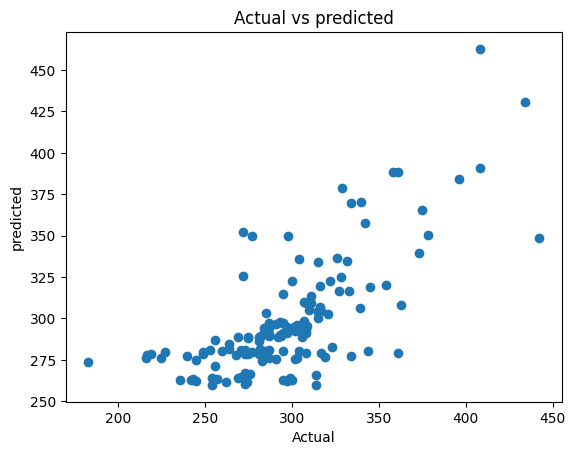

In [20]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test2, np.squeeze(model3.predict(X_test2)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test2, np.squeeze(model3.predict(X_test2)) )
mae= mean_absolute_error(Y_test2, np.squeeze(model3.predict(X_test2)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test2, np.squeeze(model3.predict(X_test2)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [22]:
prediction3 =np.squeeze(model3.predict([[80,2,2,prediction2]]))
print("Prediction: {}".format(prediction3))

y_prd=np.squeeze(np.squeeze(model3.predict(X_test2)) )
predic_dif=pd.DataFrame({'Actual':Y_test2,'predict':y_prd,"differences":Y_test2-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 67ms/step
Prediction: 365.9920654296875
5/5 [==============================] - 0s 2ms/step


,Actual,predict,differences
796,249,279.942078,-30.942078
538,269,288.834717,-19.834717
1256,306,288.920166,17.079834
1196,183,273.487854,-90.487854
342,294,289.152771,4.847229
959,308,279.157867,28.842133
1027,304,280.342285,23.657715
1480,299,263.979279,35.020721
276,295,314.786652,-19.786652
1612,236,262.672363,-26.672363


## Random forest with keras tuner RNN

In [34]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
RF= RandomForestRegressor(n_estimators=200,random_state=30)
RF.fit(X_train.values,Y_train.values)

RandomForestRegressor(n_estimators=200, random_state=30)

In [35]:
prediction4 = np.squeeze(RF.predict([[80,2,2]]))
print("Prediction: {}".format(prediction4))

Prediction: 316.535


In [36]:
y_prd=np.squeeze(np.squeeze(model2.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

16/16 [==============================] - 0s 4ms/step
      Actual     predict  differences
443      287  298.035278   -11.035278
319      317  304.642822    12.357178
703      295  282.513275    12.486725
526      320  310.989319     9.010681
76       435  378.426758    56.573242
...      ...         ...          ...
1232     287  298.584442   -11.584442
330      296  300.536255    -4.536255
1087     274  283.286530    -9.286530
789      321  306.266724    14.733276
1618     314  272.164886    41.835114

[488 rows x 3 columns]


In [37]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

-142.3966064453125
-153.4658203125
180.82589721679688
178.8189697265625
-204.56890869140625
141.72821044921875
119.8389892578125
167.53704833984375
145.81939697265625
129.07968139648438
164.06842041015625
130.77114868164062
142.33251953125
lower bound: -121.4334593896763
upper bound: 119.48608720329693


In [38]:
A.drop(A[(A['differences'] >119)].index, inplace=True)
A.drop(A[(A['differences'] <-121)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X3=B.drop('Actual',axis=1)
Y3=B['Actual']
X_train3, X_test3, Y_train3, Y_test3 =train_test_split(X3,Y3, test_size=0.3, random_state = 0)

      AverageFloorArea  Year/Quarter  Property Type  Actual     predict
1                   14             4              1     468  444.914093
2                   19             1              4     375  372.813599
4                   20             1              2     366  450.182617
5                   20             4              1     485  379.851898
9                   23             2              5     408  484.988434
...                ...           ...            ...     ...         ...
1616               155             2              3     242  272.115021
1618               155             4              3     314  272.164886
1619               156             1              3     275  284.280853
1622               156             3              4     289  272.167603
1625               157             4              3     254  272.162476

[475 rows x 5 columns]


In [39]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train3.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [40]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train3,Y_train3 ,epochs=100,validation_data=(X_test3,Y_test3))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model4 = tuner.hypermodel.build(best_hps)

model4.fit(X_train3, Y_train3, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
8/8 [==============================] - 2s 65ms/step - loss: 147.8806 - mean_absolute_error: 147.8806 - val_loss: 41.0499 - val_mean_absolute_error: 41.0499
Epoch 2/2000
8/8 [==============================] - 0s 25ms/step - loss: 44.3298 - mean_absolute_error: 44.3298 - val_loss: 23.2388 - val_mean_absolute_error: 23.2388
Epoch 3/2000
8/8 [==============================] - 0s 24ms/step - loss: 30.0260 - mean_absolute_error: 30.0260 - val_loss: 19.9294 - val_mean_absolute_error: 19.9294
Epoch 4/2000
8/8 [==============================] - 0s 30ms/step - loss: 25.8170 - mean_absolute_error: 25.8170 - val_loss: 20.1844 - val_mean_absolute_error: 20.1844
Epoch 5/2000
8/8 [==============================] - 0s 25ms/step - loss: 23.5452 - mean_absolute_error: 23.5452 - val_loss: 21.5935 - val_mean_absolute_

Epoch 49/2000
8/8 [==============================] - 0s 25ms/step - loss: 30.5560 - mean_absolute_error: 30.5560 - val_loss: 22.8770 - val_mean_absolute_error: 22.8770
Epoch 50/2000
8/8 [==============================] - 0s 26ms/step - loss: 28.0240 - mean_absolute_error: 28.0240 - val_loss: 28.5785 - val_mean_absolute_error: 28.5785
Epoch 51/2000
8/8 [==============================] - 0s 24ms/step - loss: 26.1278 - mean_absolute_error: 26.1278 - val_loss: 20.0076 - val_mean_absolute_error: 20.0076
Epoch 52/2000
8/8 [==============================] - 0s 24ms/step - loss: 25.4269 - mean_absolute_error: 25.4269 - val_loss: 20.8750 - val_mean_absolute_error: 20.8750
Epoch 53/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.3021 - mean_absolute_error: 23.3021 - val_loss: 20.4427 - val_mean_absolute_error: 20.4427
Epoch 54/2000
8/8 [==============================] - 0s 25ms/step - loss: 23.5897 - mean_absolute_error: 23.5897 - val_loss: 19.1001 - val_mean_absolute_error: 

Epoch 98/2000
8/8 [==============================] - 0s 28ms/step - loss: 22.1081 - mean_absolute_error: 22.1081 - val_loss: 20.0039 - val_mean_absolute_error: 20.0039
Epoch 99/2000
8/8 [==============================] - 0s 30ms/step - loss: 22.3433 - mean_absolute_error: 22.3433 - val_loss: 20.6627 - val_mean_absolute_error: 20.6627
Epoch 100/2000
8/8 [==============================] - 0s 28ms/step - loss: 22.1049 - mean_absolute_error: 22.1049 - val_loss: 19.0062 - val_mean_absolute_error: 19.0062
Epoch 101/2000
8/8 [==============================] - 0s 29ms/step - loss: 21.8444 - mean_absolute_error: 21.8444 - val_loss: 21.1710 - val_mean_absolute_error: 21.1710
Epoch 102/2000
8/8 [==============================] - 0s 28ms/step - loss: 22.3087 - mean_absolute_error: 22.3087 - val_loss: 18.6937 - val_mean_absolute_error: 18.6937
Epoch 103/2000
8/8 [==============================] - 0s 26ms/step - loss: 22.3227 - mean_absolute_error: 22.3227 - val_loss: 20.6813 - val_mean_absolute_err

8/8 [==============================] - 0s 30ms/step - loss: 25.7422 - mean_absolute_error: 25.7422 - val_loss: 19.7415 - val_mean_absolute_error: 19.7415
Epoch 195/2000
8/8 [==============================] - 0s 29ms/step - loss: 26.5648 - mean_absolute_error: 26.5648 - val_loss: 20.3140 - val_mean_absolute_error: 20.3140
Epoch 196/2000
8/8 [==============================] - 0s 29ms/step - loss: 26.9683 - mean_absolute_error: 26.9683 - val_loss: 30.1422 - val_mean_absolute_error: 30.1422
Epoch 197/2000
8/8 [==============================] - 0s 29ms/step - loss: 28.8899 - mean_absolute_error: 28.8899 - val_loss: 19.6487 - val_mean_absolute_error: 19.6487
Epoch 198/2000
8/8 [==============================] - 0s 28ms/step - loss: 24.9907 - mean_absolute_error: 24.9907 - val_loss: 21.0018 - val_mean_absolute_error: 21.0018
Epoch 199/2000
8/8 [==============================] - 0s 29ms/step - loss: 23.6494 - mean_absolute_error: 23.6494 - val_loss: 23.2844 - val_mean_absolute_error: 23.2844
E

8/8 [==============================] - 0s 26ms/step - loss: 22.3333 - mean_absolute_error: 22.3333 - val_loss: 18.8401 - val_mean_absolute_error: 18.8401
Epoch 291/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.9284 - mean_absolute_error: 21.9284 - val_loss: 23.7394 - val_mean_absolute_error: 23.7394
Epoch 292/2000
8/8 [==============================] - 0s 27ms/step - loss: 25.1067 - mean_absolute_error: 25.1067 - val_loss: 19.9363 - val_mean_absolute_error: 19.9363
Epoch 293/2000
8/8 [==============================] - 0s 27ms/step - loss: 22.0701 - mean_absolute_error: 22.0701 - val_loss: 20.7433 - val_mean_absolute_error: 20.7433
Epoch 294/2000
8/8 [==============================] - 0s 28ms/step - loss: 22.2762 - mean_absolute_error: 22.2762 - val_loss: 19.6650 - val_mean_absolute_error: 19.6650
Epoch 295/2000
8/8 [==============================] - 0s 27ms/step - loss: 22.1338 - mean_absolute_error: 22.1338 - val_loss: 24.3841 - val_mean_absolute_error: 24.3841
E

8/8 [==============================] - 0s 33ms/step - loss: 23.3696 - mean_absolute_error: 23.3696 - val_loss: 19.4871 - val_mean_absolute_error: 19.4871
Epoch 387/2000
8/8 [==============================] - 0s 28ms/step - loss: 21.6698 - mean_absolute_error: 21.6698 - val_loss: 19.0552 - val_mean_absolute_error: 19.0552
Epoch 388/2000
8/8 [==============================] - 0s 32ms/step - loss: 21.5565 - mean_absolute_error: 21.5565 - val_loss: 19.0887 - val_mean_absolute_error: 19.0887
Epoch 389/2000
8/8 [==============================] - 0s 35ms/step - loss: 21.2503 - mean_absolute_error: 21.2503 - val_loss: 19.5186 - val_mean_absolute_error: 19.5186
Epoch 390/2000
8/8 [==============================] - 0s 30ms/step - loss: 22.1849 - mean_absolute_error: 22.1849 - val_loss: 19.4911 - val_mean_absolute_error: 19.4911
Epoch 391/2000
8/8 [==============================] - 0s 32ms/step - loss: 21.6712 - mean_absolute_error: 21.6712 - val_loss: 20.4928 - val_mean_absolute_error: 20.4928
E

8/8 [==============================] - 0s 26ms/step - loss: 22.0914 - mean_absolute_error: 22.0914 - val_loss: 19.6525 - val_mean_absolute_error: 19.6525
Epoch 483/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.7582 - mean_absolute_error: 21.7582 - val_loss: 19.4232 - val_mean_absolute_error: 19.4232
Epoch 484/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.9021 - mean_absolute_error: 21.9021 - val_loss: 19.6477 - val_mean_absolute_error: 19.6477
Epoch 485/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.5755 - mean_absolute_error: 21.5755 - val_loss: 18.9941 - val_mean_absolute_error: 18.9941
Epoch 486/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.4670 - mean_absolute_error: 21.4670 - val_loss: 19.2058 - val_mean_absolute_error: 19.2058
Epoch 487/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.7326 - mean_absolute_error: 21.7326 - val_loss: 24.6441 - val_mean_absolute_error: 24.6441
E

8/8 [==============================] - 0s 32ms/step - loss: 21.3839 - mean_absolute_error: 21.3839 - val_loss: 18.8900 - val_mean_absolute_error: 18.8900
Epoch 579/2000
8/8 [==============================] - 0s 27ms/step - loss: 20.9326 - mean_absolute_error: 20.9326 - val_loss: 19.3983 - val_mean_absolute_error: 19.3983
Epoch 580/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.1359 - mean_absolute_error: 21.1359 - val_loss: 19.0024 - val_mean_absolute_error: 19.0024
Epoch 581/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.3640 - mean_absolute_error: 21.3640 - val_loss: 21.1043 - val_mean_absolute_error: 21.1043
Epoch 582/2000
8/8 [==============================] - 0s 26ms/step - loss: 22.0756 - mean_absolute_error: 22.0756 - val_loss: 19.0640 - val_mean_absolute_error: 19.0640
Epoch 583/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.2442 - mean_absolute_error: 22.2442 - val_loss: 24.2912 - val_mean_absolute_error: 24.2912
E

8/8 [==============================] - 0s 24ms/step - loss: 22.4659 - mean_absolute_error: 22.4659 - val_loss: 19.3522 - val_mean_absolute_error: 19.3522
Epoch 675/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.5405 - mean_absolute_error: 22.5405 - val_loss: 19.0480 - val_mean_absolute_error: 19.0480
Epoch 676/2000
8/8 [==============================] - 0s 24ms/step - loss: 22.2083 - mean_absolute_error: 22.2083 - val_loss: 18.8987 - val_mean_absolute_error: 18.8987
Epoch 677/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.3101 - mean_absolute_error: 22.3101 - val_loss: 18.9324 - val_mean_absolute_error: 18.9324
Epoch 678/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.2158 - mean_absolute_error: 22.2158 - val_loss: 19.0461 - val_mean_absolute_error: 19.0461
Epoch 679/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.4360 - mean_absolute_error: 22.4360 - val_loss: 18.8884 - val_mean_absolute_error: 18.8884
E

8/8 [==============================] - 0s 28ms/step - loss: 23.1221 - mean_absolute_error: 23.1221 - val_loss: 19.2860 - val_mean_absolute_error: 19.2860
Epoch 771/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.7901 - mean_absolute_error: 21.7901 - val_loss: 19.0565 - val_mean_absolute_error: 19.0565
Epoch 772/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.0109 - mean_absolute_error: 22.0109 - val_loss: 19.0522 - val_mean_absolute_error: 19.0522
Epoch 773/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.0423 - mean_absolute_error: 22.0423 - val_loss: 19.1864 - val_mean_absolute_error: 19.1864
Epoch 774/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.9956 - mean_absolute_error: 21.9956 - val_loss: 20.1447 - val_mean_absolute_error: 20.1447
Epoch 775/2000
8/8 [==============================] - 0s 24ms/step - loss: 22.1055 - mean_absolute_error: 22.1055 - val_loss: 19.2425 - val_mean_absolute_error: 19.2425
E

8/8 [==============================] - 0s 25ms/step - loss: 21.3772 - mean_absolute_error: 21.3772 - val_loss: 18.7472 - val_mean_absolute_error: 18.7472
Epoch 867/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.5161 - mean_absolute_error: 21.5161 - val_loss: 19.0921 - val_mean_absolute_error: 19.0921
Epoch 868/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.5607 - mean_absolute_error: 21.5607 - val_loss: 20.1608 - val_mean_absolute_error: 20.1608
Epoch 869/2000
8/8 [==============================] - 0s 24ms/step - loss: 23.3176 - mean_absolute_error: 23.3176 - val_loss: 22.1712 - val_mean_absolute_error: 22.1712
Epoch 870/2000
8/8 [==============================] - 0s 24ms/step - loss: 23.0263 - mean_absolute_error: 23.0263 - val_loss: 20.4673 - val_mean_absolute_error: 20.4673
Epoch 871/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.9522 - mean_absolute_error: 23.9522 - val_loss: 19.2821 - val_mean_absolute_error: 19.2821
E

8/8 [==============================] - 0s 24ms/step - loss: 21.3188 - mean_absolute_error: 21.3188 - val_loss: 19.1669 - val_mean_absolute_error: 19.1669
Epoch 963/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.2207 - mean_absolute_error: 21.2207 - val_loss: 19.4173 - val_mean_absolute_error: 19.4173
Epoch 964/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.9950 - mean_absolute_error: 21.9950 - val_loss: 21.9378 - val_mean_absolute_error: 21.9378
Epoch 965/2000
8/8 [==============================] - 0s 25ms/step - loss: 23.4977 - mean_absolute_error: 23.4977 - val_loss: 20.4146 - val_mean_absolute_error: 20.4146
Epoch 966/2000
8/8 [==============================] - 0s 24ms/step - loss: 22.7607 - mean_absolute_error: 22.7607 - val_loss: 19.3265 - val_mean_absolute_error: 19.3265
Epoch 967/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.5630 - mean_absolute_error: 22.5630 - val_loss: 19.5979 - val_mean_absolute_error: 19.5979
E

8/8 [==============================] - 0s 23ms/step - loss: 25.4611 - mean_absolute_error: 25.4611 - val_loss: 22.1662 - val_mean_absolute_error: 22.1662
Epoch 1059/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.7373 - mean_absolute_error: 23.7373 - val_loss: 19.8696 - val_mean_absolute_error: 19.8696
Epoch 1060/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.8943 - mean_absolute_error: 21.8943 - val_loss: 19.5392 - val_mean_absolute_error: 19.5392
Epoch 1061/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.1130 - mean_absolute_error: 22.1130 - val_loss: 19.4904 - val_mean_absolute_error: 19.4904
Epoch 1062/2000
8/8 [==============================] - 0s 24ms/step - loss: 22.3013 - mean_absolute_error: 22.3013 - val_loss: 19.7095 - val_mean_absolute_error: 19.7095
Epoch 1063/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.7380 - mean_absolute_error: 21.7380 - val_loss: 18.9159 - val_mean_absolute_error: 18.9

8/8 [==============================] - 0s 28ms/step - loss: 21.1361 - mean_absolute_error: 21.1361 - val_loss: 19.0837 - val_mean_absolute_error: 19.0837
Epoch 1155/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.0205 - mean_absolute_error: 21.0205 - val_loss: 18.9646 - val_mean_absolute_error: 18.9646
Epoch 1156/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.0728 - mean_absolute_error: 21.0728 - val_loss: 18.9878 - val_mean_absolute_error: 18.9878
Epoch 1157/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.1692 - mean_absolute_error: 21.1692 - val_loss: 19.3634 - val_mean_absolute_error: 19.3634
Epoch 1158/2000
8/8 [==============================] - 0s 26ms/step - loss: 22.2350 - mean_absolute_error: 22.2350 - val_loss: 20.9503 - val_mean_absolute_error: 20.9503
Epoch 1159/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.9276 - mean_absolute_error: 21.9276 - val_loss: 19.0844 - val_mean_absolute_error: 19.0

8/8 [==============================] - 0s 31ms/step - loss: 21.1549 - mean_absolute_error: 21.1549 - val_loss: 19.1082 - val_mean_absolute_error: 19.1082
Epoch 1251/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.0923 - mean_absolute_error: 21.0923 - val_loss: 19.2403 - val_mean_absolute_error: 19.2403
Epoch 1252/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.3974 - mean_absolute_error: 21.3974 - val_loss: 20.4932 - val_mean_absolute_error: 20.4932
Epoch 1253/2000
8/8 [==============================] - 0s 29ms/step - loss: 22.2227 - mean_absolute_error: 22.2227 - val_loss: 19.0575 - val_mean_absolute_error: 19.0575
Epoch 1254/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.9761 - mean_absolute_error: 20.9761 - val_loss: 19.5656 - val_mean_absolute_error: 19.5656
Epoch 1255/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.3706 - mean_absolute_error: 21.3706 - val_loss: 20.3883 - val_mean_absolute_error: 20.3

8/8 [==============================] - 0s 26ms/step - loss: 21.0836 - mean_absolute_error: 21.0836 - val_loss: 18.7915 - val_mean_absolute_error: 18.7915
Epoch 1347/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.0175 - mean_absolute_error: 21.0175 - val_loss: 18.9927 - val_mean_absolute_error: 18.9927
Epoch 1348/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.9703 - mean_absolute_error: 20.9703 - val_loss: 19.6346 - val_mean_absolute_error: 19.6346
Epoch 1349/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.5046 - mean_absolute_error: 21.5046 - val_loss: 20.0503 - val_mean_absolute_error: 20.0503
Epoch 1350/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.7472 - mean_absolute_error: 21.7472 - val_loss: 18.9481 - val_mean_absolute_error: 18.9481
Epoch 1351/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.0617 - mean_absolute_error: 21.0617 - val_loss: 18.9230 - val_mean_absolute_error: 18.9

8/8 [==============================] - 0s 28ms/step - loss: 21.9498 - mean_absolute_error: 21.9498 - val_loss: 19.3601 - val_mean_absolute_error: 19.3601
Epoch 1443/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.4202 - mean_absolute_error: 21.4202 - val_loss: 19.3606 - val_mean_absolute_error: 19.3606
Epoch 1444/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.1898 - mean_absolute_error: 21.1898 - val_loss: 18.8674 - val_mean_absolute_error: 18.8674
Epoch 1445/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.1598 - mean_absolute_error: 21.1598 - val_loss: 19.0086 - val_mean_absolute_error: 19.0086
Epoch 1446/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.0965 - mean_absolute_error: 21.0965 - val_loss: 19.4314 - val_mean_absolute_error: 19.4314
Epoch 1447/2000
8/8 [==============================] - 0s 28ms/step - loss: 21.0468 - mean_absolute_error: 21.0468 - val_loss: 19.2308 - val_mean_absolute_error: 19.2

8/8 [==============================] - 0s 31ms/step - loss: 21.7595 - mean_absolute_error: 21.7595 - val_loss: 19.0325 - val_mean_absolute_error: 19.0325
Epoch 1539/2000
8/8 [==============================] - 0s 29ms/step - loss: 21.8898 - mean_absolute_error: 21.8898 - val_loss: 19.1484 - val_mean_absolute_error: 19.1484
Epoch 1540/2000
8/8 [==============================] - 0s 28ms/step - loss: 21.4954 - mean_absolute_error: 21.4954 - val_loss: 20.4911 - val_mean_absolute_error: 20.4911
Epoch 1541/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.6757 - mean_absolute_error: 21.6757 - val_loss: 21.2176 - val_mean_absolute_error: 21.2176
Epoch 1542/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.1854 - mean_absolute_error: 22.1854 - val_loss: 21.6512 - val_mean_absolute_error: 21.6512
Epoch 1543/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.2154 - mean_absolute_error: 22.2154 - val_loss: 19.2229 - val_mean_absolute_error: 19.2

8/8 [==============================] - 0s 27ms/step - loss: 21.2199 - mean_absolute_error: 21.2199 - val_loss: 19.1130 - val_mean_absolute_error: 19.1130
Epoch 1635/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.5212 - mean_absolute_error: 21.5212 - val_loss: 19.8907 - val_mean_absolute_error: 19.8907
Epoch 1636/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.7788 - mean_absolute_error: 21.7788 - val_loss: 19.5897 - val_mean_absolute_error: 19.5897
Epoch 1637/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.6400 - mean_absolute_error: 21.6400 - val_loss: 19.8364 - val_mean_absolute_error: 19.8364
Epoch 1638/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.8058 - mean_absolute_error: 21.8058 - val_loss: 19.5404 - val_mean_absolute_error: 19.5404
Epoch 1639/2000
8/8 [==============================] - 0s 28ms/step - loss: 21.3126 - mean_absolute_error: 21.3126 - val_loss: 19.4473 - val_mean_absolute_error: 19.4

8/8 [==============================] - 0s 27ms/step - loss: 21.0686 - mean_absolute_error: 21.0686 - val_loss: 19.1484 - val_mean_absolute_error: 19.1484
Epoch 1731/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.9491 - mean_absolute_error: 20.9491 - val_loss: 19.1928 - val_mean_absolute_error: 19.1928
Epoch 1732/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.6865 - mean_absolute_error: 21.6865 - val_loss: 18.9910 - val_mean_absolute_error: 18.9910
Epoch 1733/2000
8/8 [==============================] - 0s 27ms/step - loss: 20.9752 - mean_absolute_error: 20.9752 - val_loss: 19.6241 - val_mean_absolute_error: 19.6241
Epoch 1734/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.3272 - mean_absolute_error: 21.3272 - val_loss: 19.2758 - val_mean_absolute_error: 19.2758
Epoch 1735/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.3008 - mean_absolute_error: 21.3008 - val_loss: 19.0642 - val_mean_absolute_error: 19.0

8/8 [==============================] - 0s 27ms/step - loss: 22.7421 - mean_absolute_error: 22.7421 - val_loss: 18.5917 - val_mean_absolute_error: 18.5917
Epoch 1827/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.9903 - mean_absolute_error: 21.9903 - val_loss: 19.5021 - val_mean_absolute_error: 19.5021
Epoch 1828/2000
8/8 [==============================] - 0s 27ms/step - loss: 22.0767 - mean_absolute_error: 22.0767 - val_loss: 18.6323 - val_mean_absolute_error: 18.6323
Epoch 1829/2000
8/8 [==============================] - 0s 26ms/step - loss: 22.1491 - mean_absolute_error: 22.1491 - val_loss: 18.7366 - val_mean_absolute_error: 18.7366
Epoch 1830/2000
8/8 [==============================] - 0s 25ms/step - loss: 23.2028 - mean_absolute_error: 23.2028 - val_loss: 19.4837 - val_mean_absolute_error: 19.4837
Epoch 1831/2000
8/8 [==============================] - 0s 27ms/step - loss: 22.2999 - mean_absolute_error: 22.2999 - val_loss: 18.8384 - val_mean_absolute_error: 18.8

8/8 [==============================] - 0s 27ms/step - loss: 31.9800 - mean_absolute_error: 31.9800 - val_loss: 55.9112 - val_mean_absolute_error: 55.9112
Epoch 1923/2000
8/8 [==============================] - 0s 25ms/step - loss: 37.7060 - mean_absolute_error: 37.7060 - val_loss: 20.9718 - val_mean_absolute_error: 20.9718
Epoch 1924/2000
8/8 [==============================] - 0s 24ms/step - loss: 23.6487 - mean_absolute_error: 23.6487 - val_loss: 22.7269 - val_mean_absolute_error: 22.7269
Epoch 1925/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.9917 - mean_absolute_error: 23.9917 - val_loss: 23.5481 - val_mean_absolute_error: 23.5481
Epoch 1926/2000
8/8 [==============================] - 0s 25ms/step - loss: 23.0404 - mean_absolute_error: 23.0404 - val_loss: 19.6523 - val_mean_absolute_error: 19.6523
Epoch 1927/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.7591 - mean_absolute_error: 21.7591 - val_loss: 18.8146 - val_mean_absolute_error: 18.8

5/5 [==============================] - 0s 7ms/step
r2_score: 0.47008176529344603
5/5 [==============================] - 0s 7ms/step
mean squired error: 865.9897929263477
mean absolute error: 20.84938977648328
5/5 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Actual vs predicted')

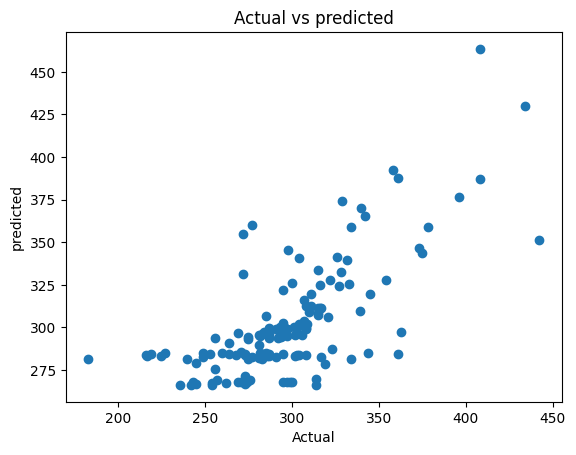

In [41]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test3, np.squeeze(model4.predict(X_test3)) )
r2_score=print('r2_score:', r2_score)


from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test3, np.squeeze(model4.predict(X_test3)) )
mae= mean_absolute_error(Y_test3, np.squeeze(model4.predict(X_test3)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test3, np.squeeze(model4.predict(X_test3)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [43]:
prediction5 =np.squeeze(model4.predict([[80,2,2,prediction4]]))
print("Prediction: {}".format(prediction5))

y_prd=np.squeeze(np.squeeze(model4.predict(X_test3)) )
predic_dif=pd.DataFrame({'Actual':Y_test3,'predict':y_prd,"differences":Y_test3-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 38ms/step
Prediction: 316.27264404296875
5/5 [==============================] - 0s 7ms/step


,Actual,predict,differences
796,249,284.918427,-35.918427
538,269,296.837250,-27.837250
1256,306,295.654205,10.345795
1196,183,281.551849,-98.551849
342,294,294.156677,-0.156677
959,308,283.544342,24.455658
1027,304,283.633392,20.366608
1480,299,268.034760,30.965240
276,295,321.990143,-26.990143
1612,236,266.423553,-30.423553


## Dense with keras tuner RNN

In [44]:
from keras.layers import Dense, Dropout,Activation
from keras.models import Sequential
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
model5=Sequential()
model5.add(Dense(128, input_dim=3, activation='relu'))
model5.add(Dense(64,activation='relu'))
model5.add(Dense(1,activation='linear'))
model5.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [45]:
model5.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
25/25 [==============================] - 1s 8ms/step - loss: 75982.8828 - mae: 270.2122 - val_loss: 62171.3047 - val_mae: 241.1857
Epoch 2/2000
25/25 [==============================] - 0s 3ms/step - loss: 44625.6016 - mae: 196.9558 - val_loss: 30664.3125 - val_mae: 152.3450
Epoch 3/2000
25/25 [==============================] - 0s 4ms/step - loss: 20748.0098 - mae: 118.4867 - val_loss: 17186.3574 - val_mae: 104.8554
Epoch 4/2000
25/25 [==============================] - 0s 3ms/step - loss: 17499.9434 - mae: 108.1776 - val_loss: 17038.3926 - val_mae: 104.2150
Epoch 5/2000
25/25 [==============================] - 0s 3ms/step - loss: 17175.4727 - mae: 106.5954 - val_loss: 16896.5547 - val_mae: 103.6656
Epoch 6/2000
25/25 [==============================] - 0s 3ms/step - loss: 16981.7617 - mae: 106.2104 - val_loss: 16713.0234 - val_mae: 103.0077
Epoch 7/2000
25/25 [==============================] - 0s 3ms/step - loss: 16672.1270 - mae: 104.9112 - val_loss: 16289.5215 - val_mae: 1

Epoch 59/2000
25/25 [==============================] - 0s 3ms/step - loss: 5166.0024 - mae: 55.1209 - val_loss: 5617.2290 - val_mae: 57.2729
Epoch 60/2000
25/25 [==============================] - 0s 3ms/step - loss: 5020.7261 - mae: 54.0848 - val_loss: 5554.6709 - val_mae: 56.9679
Epoch 61/2000
25/25 [==============================] - 0s 3ms/step - loss: 4976.7485 - mae: 53.8207 - val_loss: 5440.1680 - val_mae: 56.2362
Epoch 62/2000
25/25 [==============================] - 0s 3ms/step - loss: 4855.8140 - mae: 53.0721 - val_loss: 5333.2036 - val_mae: 55.5462
Epoch 63/2000
25/25 [==============================] - 0s 3ms/step - loss: 4717.6270 - mae: 52.2660 - val_loss: 5363.4995 - val_mae: 55.5028
Epoch 64/2000
25/25 [==============================] - 0s 3ms/step - loss: 4640.6094 - mae: 52.0697 - val_loss: 5134.6826 - val_mae: 54.3537
Epoch 65/2000
25/25 [==============================] - 0s 3ms/step - loss: 4536.1123 - mae: 51.1457 - val_loss: 5172.3481 - val_mae: 54.5462
Epoch 66/2000

Epoch 117/2000
25/25 [==============================] - 0s 3ms/step - loss: 1562.9783 - mae: 25.0348 - val_loss: 2297.5093 - val_mae: 32.1991
Epoch 118/2000
25/25 [==============================] - 0s 3ms/step - loss: 1581.2041 - mae: 24.9826 - val_loss: 2476.5928 - val_mae: 32.0954
Epoch 119/2000
25/25 [==============================] - 0s 3ms/step - loss: 1601.1388 - mae: 25.1868 - val_loss: 2250.6011 - val_mae: 30.1186
Epoch 120/2000
25/25 [==============================] - 0s 3ms/step - loss: 1576.1969 - mae: 24.8807 - val_loss: 2270.2620 - val_mae: 30.1300
Epoch 121/2000
25/25 [==============================] - 0s 3ms/step - loss: 1554.4056 - mae: 25.0351 - val_loss: 2273.6868 - val_mae: 30.8681
Epoch 122/2000
25/25 [==============================] - 0s 3ms/step - loss: 1571.6635 - mae: 25.1376 - val_loss: 2254.5305 - val_mae: 30.4198
Epoch 123/2000
25/25 [==============================] - 0s 3ms/step - loss: 1578.5795 - mae: 24.9331 - val_loss: 2269.9985 - val_mae: 31.2410
Epoch 

Epoch 175/2000
25/25 [==============================] - 0s 3ms/step - loss: 1586.5740 - mae: 25.4446 - val_loss: 2227.2554 - val_mae: 29.9001
Epoch 176/2000
25/25 [==============================] - 0s 4ms/step - loss: 1567.5077 - mae: 25.2517 - val_loss: 2227.1975 - val_mae: 30.8358
Epoch 177/2000
25/25 [==============================] - 0s 3ms/step - loss: 1545.7488 - mae: 24.7717 - val_loss: 2264.4531 - val_mae: 31.8132
Epoch 178/2000
25/25 [==============================] - 0s 3ms/step - loss: 1611.7778 - mae: 26.0395 - val_loss: 2217.2268 - val_mae: 29.5689
Epoch 179/2000
25/25 [==============================] - 0s 3ms/step - loss: 1529.1688 - mae: 24.5640 - val_loss: 2228.7803 - val_mae: 30.3382
Epoch 180/2000
25/25 [==============================] - 0s 3ms/step - loss: 1547.2375 - mae: 24.5005 - val_loss: 2235.0210 - val_mae: 29.5288
Epoch 181/2000
25/25 [==============================] - 0s 3ms/step - loss: 1528.7521 - mae: 24.3132 - val_loss: 2222.9170 - val_mae: 29.7146
Epoch 

Epoch 233/2000
25/25 [==============================] - 0s 3ms/step - loss: 1650.0952 - mae: 27.3134 - val_loss: 2257.6042 - val_mae: 29.4717
Epoch 234/2000
25/25 [==============================] - 0s 3ms/step - loss: 1564.9169 - mae: 25.0567 - val_loss: 2243.0261 - val_mae: 29.0328
Epoch 235/2000
25/25 [==============================] - 0s 3ms/step - loss: 1535.3683 - mae: 24.9037 - val_loss: 2218.3748 - val_mae: 29.4237
Epoch 236/2000
25/25 [==============================] - 0s 3ms/step - loss: 1558.5459 - mae: 24.9869 - val_loss: 2310.1919 - val_mae: 29.6715
Epoch 237/2000
25/25 [==============================] - 0s 3ms/step - loss: 1537.6663 - mae: 24.6164 - val_loss: 2222.8469 - val_mae: 29.4149
Epoch 238/2000
25/25 [==============================] - 0s 3ms/step - loss: 1533.8103 - mae: 24.4884 - val_loss: 2286.3757 - val_mae: 29.3658
Epoch 239/2000
25/25 [==============================] - 0s 3ms/step - loss: 1509.5306 - mae: 23.9111 - val_loss: 2267.8857 - val_mae: 29.2035
Epoch 

Epoch 291/2000
25/25 [==============================] - 0s 3ms/step - loss: 1506.3673 - mae: 23.7999 - val_loss: 2221.1956 - val_mae: 29.1058
Epoch 292/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.8721 - mae: 24.4740 - val_loss: 2249.0134 - val_mae: 29.1280
Epoch 293/2000
25/25 [==============================] - 0s 3ms/step - loss: 1519.5687 - mae: 24.5804 - val_loss: 2447.7544 - val_mae: 31.7422
Epoch 294/2000
25/25 [==============================] - 0s 4ms/step - loss: 1589.1139 - mae: 25.3515 - val_loss: 2362.8020 - val_mae: 30.2890
Epoch 295/2000
25/25 [==============================] - 0s 4ms/step - loss: 1566.6249 - mae: 25.0664 - val_loss: 2233.1667 - val_mae: 28.7795
Epoch 296/2000
25/25 [==============================] - 0s 3ms/step - loss: 1496.5021 - mae: 23.8335 - val_loss: 2223.0459 - val_mae: 29.0315
Epoch 297/2000
25/25 [==============================] - 0s 3ms/step - loss: 1526.3744 - mae: 24.2041 - val_loss: 2222.9773 - val_mae: 30.2864
Epoch 

Epoch 349/2000
25/25 [==============================] - 0s 4ms/step - loss: 1527.9845 - mae: 24.2213 - val_loss: 2280.1660 - val_mae: 29.2255
Epoch 350/2000
25/25 [==============================] - 0s 4ms/step - loss: 1514.9423 - mae: 24.2750 - val_loss: 2369.5042 - val_mae: 30.6480
Epoch 351/2000
25/25 [==============================] - 0s 4ms/step - loss: 1490.6547 - mae: 23.7059 - val_loss: 2296.0020 - val_mae: 29.3725
Epoch 352/2000
25/25 [==============================] - 0s 4ms/step - loss: 1534.4786 - mae: 25.0786 - val_loss: 2217.5154 - val_mae: 29.1894
Epoch 353/2000
25/25 [==============================] - 0s 4ms/step - loss: 1539.4255 - mae: 24.1420 - val_loss: 2240.3865 - val_mae: 29.0355
Epoch 354/2000
25/25 [==============================] - 0s 4ms/step - loss: 1508.6946 - mae: 24.0802 - val_loss: 2259.5127 - val_mae: 31.9739
Epoch 355/2000
25/25 [==============================] - 0s 4ms/step - loss: 1494.4479 - mae: 23.8499 - val_loss: 2311.7495 - val_mae: 29.6926
Epoch 

Epoch 407/2000
25/25 [==============================] - 0s 4ms/step - loss: 1542.7472 - mae: 24.4262 - val_loss: 2331.8142 - val_mae: 29.4829
Epoch 408/2000
25/25 [==============================] - 0s 4ms/step - loss: 1511.5972 - mae: 23.8933 - val_loss: 2279.4265 - val_mae: 29.0521
Epoch 409/2000
25/25 [==============================] - 0s 3ms/step - loss: 1493.0621 - mae: 23.6333 - val_loss: 2253.3335 - val_mae: 28.9891
Epoch 410/2000
25/25 [==============================] - 0s 3ms/step - loss: 1499.8207 - mae: 23.6050 - val_loss: 2298.1631 - val_mae: 29.2133
Epoch 411/2000
25/25 [==============================] - 0s 4ms/step - loss: 1497.0361 - mae: 24.3710 - val_loss: 2319.9075 - val_mae: 29.4525
Epoch 412/2000
25/25 [==============================] - 0s 3ms/step - loss: 1516.1412 - mae: 24.1151 - val_loss: 2222.9609 - val_mae: 29.1934
Epoch 413/2000
25/25 [==============================] - 0s 4ms/step - loss: 1492.1418 - mae: 23.6396 - val_loss: 2265.2463 - val_mae: 29.0846
Epoch 

Epoch 465/2000
25/25 [==============================] - 0s 4ms/step - loss: 1478.0575 - mae: 23.3690 - val_loss: 2215.4338 - val_mae: 30.4457
Epoch 466/2000
25/25 [==============================] - 0s 4ms/step - loss: 1503.5890 - mae: 24.7485 - val_loss: 2466.4741 - val_mae: 31.8823
Epoch 467/2000
25/25 [==============================] - 0s 3ms/step - loss: 1528.8551 - mae: 24.4523 - val_loss: 2216.5701 - val_mae: 29.1724
Epoch 468/2000
25/25 [==============================] - 0s 3ms/step - loss: 1478.7246 - mae: 23.2513 - val_loss: 2211.2932 - val_mae: 29.4826
Epoch 469/2000
25/25 [==============================] - 0s 3ms/step - loss: 1477.2227 - mae: 23.6011 - val_loss: 2315.1748 - val_mae: 29.4261
Epoch 470/2000
25/25 [==============================] - 0s 3ms/step - loss: 1493.0283 - mae: 23.6351 - val_loss: 2235.2878 - val_mae: 29.0815
Epoch 471/2000
25/25 [==============================] - 0s 4ms/step - loss: 1474.0328 - mae: 23.5249 - val_loss: 2212.7568 - val_mae: 29.6215
Epoch 

Epoch 523/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.7753 - mae: 23.6325 - val_loss: 2365.3796 - val_mae: 30.3215
Epoch 524/2000
25/25 [==============================] - 0s 3ms/step - loss: 1528.0117 - mae: 24.5432 - val_loss: 2216.8828 - val_mae: 29.1369
Epoch 525/2000
25/25 [==============================] - 0s 3ms/step - loss: 1514.0062 - mae: 24.9873 - val_loss: 2214.9722 - val_mae: 29.1855
Epoch 526/2000
25/25 [==============================] - 0s 3ms/step - loss: 1481.1440 - mae: 23.8804 - val_loss: 2245.3613 - val_mae: 31.8686
Epoch 527/2000
25/25 [==============================] - 0s 3ms/step - loss: 1533.7787 - mae: 24.6988 - val_loss: 2207.8340 - val_mae: 29.3191
Epoch 528/2000
25/25 [==============================] - 0s 3ms/step - loss: 1489.3989 - mae: 23.7792 - val_loss: 2323.0298 - val_mae: 29.6735
Epoch 529/2000
25/25 [==============================] - 0s 3ms/step - loss: 1500.8984 - mae: 24.0451 - val_loss: 2423.8252 - val_mae: 31.1897
Epoch 

Epoch 581/2000
25/25 [==============================] - 0s 3ms/step - loss: 1539.7638 - mae: 24.5367 - val_loss: 2271.4805 - val_mae: 29.1164
Epoch 582/2000
25/25 [==============================] - 0s 3ms/step - loss: 1460.5809 - mae: 23.2366 - val_loss: 2232.9133 - val_mae: 28.8813
Epoch 583/2000
25/25 [==============================] - 0s 3ms/step - loss: 1506.2904 - mae: 23.8787 - val_loss: 2379.7830 - val_mae: 30.7365
Epoch 584/2000
25/25 [==============================] - 0s 3ms/step - loss: 1542.6405 - mae: 24.8814 - val_loss: 2404.8608 - val_mae: 31.2389
Epoch 585/2000
25/25 [==============================] - 0s 3ms/step - loss: 1484.2726 - mae: 23.8445 - val_loss: 2231.1238 - val_mae: 31.2826
Epoch 586/2000
25/25 [==============================] - 0s 3ms/step - loss: 1489.1030 - mae: 24.0149 - val_loss: 2205.0476 - val_mae: 29.7146
Epoch 587/2000
25/25 [==============================] - 0s 4ms/step - loss: 1483.3798 - mae: 23.7126 - val_loss: 2223.0039 - val_mae: 28.9384
Epoch 

Epoch 639/2000
25/25 [==============================] - 0s 3ms/step - loss: 1452.0712 - mae: 23.0420 - val_loss: 2201.7820 - val_mae: 30.1327
Epoch 640/2000
25/25 [==============================] - 0s 3ms/step - loss: 1455.0999 - mae: 23.4145 - val_loss: 2245.9949 - val_mae: 28.7892
Epoch 641/2000
25/25 [==============================] - 0s 4ms/step - loss: 1472.0958 - mae: 23.3144 - val_loss: 2196.3477 - val_mae: 29.8934
Epoch 642/2000
25/25 [==============================] - 0s 3ms/step - loss: 1478.3234 - mae: 23.4952 - val_loss: 2212.7708 - val_mae: 29.2273
Epoch 643/2000
25/25 [==============================] - 0s 3ms/step - loss: 1565.1508 - mae: 25.0186 - val_loss: 2225.1062 - val_mae: 28.8171
Epoch 644/2000
25/25 [==============================] - 0s 3ms/step - loss: 1457.7345 - mae: 23.3924 - val_loss: 2276.5557 - val_mae: 29.1732
Epoch 645/2000
25/25 [==============================] - 0s 3ms/step - loss: 1527.4530 - mae: 24.4202 - val_loss: 2301.0962 - val_mae: 29.4366
Epoch 

Epoch 697/2000
25/25 [==============================] - 0s 4ms/step - loss: 1473.1838 - mae: 23.4350 - val_loss: 2186.0532 - val_mae: 29.6381
Epoch 698/2000
25/25 [==============================] - 0s 4ms/step - loss: 1474.0045 - mae: 23.4949 - val_loss: 2212.1919 - val_mae: 30.4644
Epoch 699/2000
25/25 [==============================] - 0s 3ms/step - loss: 1450.4132 - mae: 23.2973 - val_loss: 2193.9097 - val_mae: 29.3860
Epoch 700/2000
25/25 [==============================] - 0s 3ms/step - loss: 1477.4771 - mae: 23.8576 - val_loss: 2240.7417 - val_mae: 31.8650
Epoch 701/2000
25/25 [==============================] - 0s 4ms/step - loss: 1470.4957 - mae: 23.6070 - val_loss: 2201.8914 - val_mae: 29.5299
Epoch 702/2000
25/25 [==============================] - 0s 3ms/step - loss: 1534.5884 - mae: 24.7271 - val_loss: 2228.6646 - val_mae: 28.9308
Epoch 703/2000
25/25 [==============================] - 0s 4ms/step - loss: 1556.7841 - mae: 25.5474 - val_loss: 2327.6355 - val_mae: 29.7991
Epoch 

Epoch 755/2000
25/25 [==============================] - 0s 4ms/step - loss: 1448.0164 - mae: 23.3281 - val_loss: 2301.2490 - val_mae: 29.5077
Epoch 756/2000
25/25 [==============================] - 0s 4ms/step - loss: 1464.6758 - mae: 23.4321 - val_loss: 2265.9404 - val_mae: 29.1408
Epoch 757/2000
25/25 [==============================] - 0s 3ms/step - loss: 1449.0654 - mae: 22.9797 - val_loss: 2186.7585 - val_mae: 29.3185
Epoch 758/2000
25/25 [==============================] - 0s 3ms/step - loss: 1501.1907 - mae: 24.5961 - val_loss: 2181.2766 - val_mae: 29.2043
Epoch 759/2000
25/25 [==============================] - 0s 5ms/step - loss: 1495.8684 - mae: 24.2078 - val_loss: 2188.7461 - val_mae: 29.1293
Epoch 760/2000
25/25 [==============================] - 0s 4ms/step - loss: 1464.3367 - mae: 23.7599 - val_loss: 2379.9512 - val_mae: 30.7688
Epoch 761/2000
25/25 [==============================] - 0s 4ms/step - loss: 1495.9155 - mae: 23.9956 - val_loss: 2409.5579 - val_mae: 31.3175
Epoch 

Epoch 813/2000
25/25 [==============================] - 0s 4ms/step - loss: 1443.2990 - mae: 23.2406 - val_loss: 2239.1597 - val_mae: 28.8024
Epoch 814/2000
25/25 [==============================] - 0s 3ms/step - loss: 1433.8762 - mae: 23.0089 - val_loss: 2188.9810 - val_mae: 29.3178
Epoch 815/2000
25/25 [==============================] - 0s 4ms/step - loss: 1453.9325 - mae: 23.1485 - val_loss: 2252.0596 - val_mae: 28.7898
Epoch 816/2000
25/25 [==============================] - 0s 3ms/step - loss: 1448.7587 - mae: 23.7398 - val_loss: 2218.2500 - val_mae: 28.7221
Epoch 817/2000
25/25 [==============================] - 0s 3ms/step - loss: 1455.1260 - mae: 23.5374 - val_loss: 2239.3821 - val_mae: 28.8808
Epoch 818/2000
25/25 [==============================] - 0s 3ms/step - loss: 1443.3157 - mae: 22.8077 - val_loss: 2179.7859 - val_mae: 29.3711
Epoch 819/2000
25/25 [==============================] - 0s 3ms/step - loss: 1438.3923 - mae: 23.1779 - val_loss: 2244.3384 - val_mae: 29.0486
Epoch 

Epoch 871/2000
25/25 [==============================] - 0s 4ms/step - loss: 1485.7784 - mae: 23.7942 - val_loss: 2422.6772 - val_mae: 31.8644
Epoch 872/2000
25/25 [==============================] - 0s 3ms/step - loss: 1440.2952 - mae: 23.4042 - val_loss: 2188.4604 - val_mae: 30.1297
Epoch 873/2000
25/25 [==============================] - 0s 3ms/step - loss: 1442.3448 - mae: 23.1222 - val_loss: 2248.1868 - val_mae: 29.1007
Epoch 874/2000
25/25 [==============================] - 0s 4ms/step - loss: 1436.1621 - mae: 23.2356 - val_loss: 2184.9727 - val_mae: 29.5470
Epoch 875/2000
25/25 [==============================] - 0s 3ms/step - loss: 1433.3458 - mae: 23.0601 - val_loss: 2184.5352 - val_mae: 28.9219
Epoch 876/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.5614 - mae: 23.7370 - val_loss: 2181.5310 - val_mae: 29.6047
Epoch 877/2000
25/25 [==============================] - 0s 3ms/step - loss: 1459.6978 - mae: 23.8192 - val_loss: 2380.1174 - val_mae: 30.9584
Epoch 

Epoch 929/2000
25/25 [==============================] - 0s 4ms/step - loss: 1516.2450 - mae: 24.6534 - val_loss: 2246.2068 - val_mae: 29.0608
Epoch 930/2000
25/25 [==============================] - 0s 4ms/step - loss: 1460.8318 - mae: 23.2749 - val_loss: 2169.5420 - val_mae: 29.7143
Epoch 931/2000
25/25 [==============================] - 0s 4ms/step - loss: 1418.9709 - mae: 23.0010 - val_loss: 2377.7700 - val_mae: 31.1128
Epoch 932/2000
25/25 [==============================] - 0s 5ms/step - loss: 1417.7930 - mae: 23.5743 - val_loss: 2191.6858 - val_mae: 28.9877
Epoch 933/2000
25/25 [==============================] - 0s 4ms/step - loss: 1424.6882 - mae: 23.0451 - val_loss: 2186.9329 - val_mae: 28.7398
Epoch 934/2000
25/25 [==============================] - 0s 4ms/step - loss: 1426.7136 - mae: 22.9650 - val_loss: 2242.5752 - val_mae: 28.8852
Epoch 935/2000
25/25 [==============================] - 0s 4ms/step - loss: 1410.9716 - mae: 22.7973 - val_loss: 2226.5708 - val_mae: 28.7558
Epoch 

Epoch 987/2000
25/25 [==============================] - 0s 3ms/step - loss: 1427.1941 - mae: 23.1588 - val_loss: 2155.3503 - val_mae: 28.7987
Epoch 988/2000
25/25 [==============================] - 0s 3ms/step - loss: 1444.8444 - mae: 23.1227 - val_loss: 2159.3396 - val_mae: 28.9267
Epoch 989/2000
25/25 [==============================] - 0s 3ms/step - loss: 1417.0958 - mae: 22.6336 - val_loss: 2187.0728 - val_mae: 28.6239
Epoch 990/2000
25/25 [==============================] - 0s 3ms/step - loss: 1459.5652 - mae: 23.6288 - val_loss: 2178.1697 - val_mae: 28.8241
Epoch 991/2000
25/25 [==============================] - 0s 3ms/step - loss: 1428.0133 - mae: 23.3270 - val_loss: 2162.2104 - val_mae: 29.4855
Epoch 992/2000
25/25 [==============================] - 0s 3ms/step - loss: 1449.6434 - mae: 23.2896 - val_loss: 2158.8440 - val_mae: 29.2137
Epoch 993/2000
25/25 [==============================] - 0s 3ms/step - loss: 1468.6981 - mae: 24.0161 - val_loss: 2303.6892 - val_mae: 30.0707
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 1433.2329 - mae: 22.8417 - val_loss: 2211.5413 - val_mae: 31.2816
Epoch 1102/2000
25/25 [==============================] - 0s 3ms/step - loss: 1424.9534 - mae: 23.0019 - val_loss: 2149.8027 - val_mae: 28.9745
Epoch 1103/2000
25/25 [==============================] - 0s 3ms/step - loss: 1406.4220 - mae: 22.9331 - val_loss: 2174.2444 - val_mae: 29.7364
Epoch 1104/2000
25/25 [==============================] - 0s 3ms/step - loss: 1402.3964 - mae: 22.8492 - val_loss: 2299.2649 - val_mae: 29.7821
Epoch 1105/2000
25/25 [==============================] - 0s 3ms/step - loss: 1391.1619 - mae: 22.7038 - val_loss: 2205.4351 - val_mae: 28.9703
Epoch 1106/2000
25/25 [==============================] - 0s 3ms/step - loss: 1399.6852 - mae: 22.6440 - val_loss: 2192.8127 - val_mae: 28.5709
Epoch 1107/2000
25/25 [==============================] - 0s 3ms/step - loss: 1414.4792 - mae: 22.7160 - val_loss: 2186.3826 - val_mae: 28.4222
Epoch 1108/2000

25/25 [==============================] - 0s 3ms/step - loss: 1385.2583 - mae: 23.0453 - val_loss: 2159.7996 - val_mae: 30.1419
Epoch 1216/2000
25/25 [==============================] - 0s 4ms/step - loss: 1399.1484 - mae: 22.8560 - val_loss: 2168.1921 - val_mae: 28.5122
Epoch 1217/2000
25/25 [==============================] - 0s 4ms/step - loss: 1417.0548 - mae: 22.8128 - val_loss: 2162.0730 - val_mae: 29.6781
Epoch 1218/2000
25/25 [==============================] - 0s 4ms/step - loss: 1406.3207 - mae: 22.8186 - val_loss: 2138.4482 - val_mae: 29.4126
Epoch 1219/2000
25/25 [==============================] - 0s 4ms/step - loss: 1398.4316 - mae: 22.7212 - val_loss: 2159.6182 - val_mae: 29.0680
Epoch 1220/2000
25/25 [==============================] - 0s 4ms/step - loss: 1388.4945 - mae: 22.8040 - val_loss: 2142.9226 - val_mae: 28.7604
Epoch 1221/2000
25/25 [==============================] - 0s 3ms/step - loss: 1414.9951 - mae: 23.0407 - val_loss: 2234.9922 - val_mae: 28.7226
Epoch 1222/2000

25/25 [==============================] - 0s 3ms/step - loss: 1398.8521 - mae: 22.8000 - val_loss: 2137.4031 - val_mae: 28.7537
Epoch 1330/2000
25/25 [==============================] - 0s 3ms/step - loss: 1363.4238 - mae: 22.2643 - val_loss: 2168.4043 - val_mae: 30.1746
Epoch 1331/2000
25/25 [==============================] - 0s 3ms/step - loss: 1385.5109 - mae: 23.2231 - val_loss: 2287.9644 - val_mae: 29.6917
Epoch 1332/2000
25/25 [==============================] - 0s 3ms/step - loss: 1383.6882 - mae: 22.3973 - val_loss: 2139.0630 - val_mae: 30.2346
Epoch 1333/2000
25/25 [==============================] - 0s 4ms/step - loss: 1389.8666 - mae: 22.6424 - val_loss: 2130.7590 - val_mae: 28.8093
Epoch 1334/2000
25/25 [==============================] - 0s 4ms/step - loss: 1383.5466 - mae: 22.9359 - val_loss: 2144.8477 - val_mae: 29.1854
Epoch 1335/2000
25/25 [==============================] - 0s 4ms/step - loss: 1377.5121 - mae: 22.4116 - val_loss: 2152.1926 - val_mae: 29.9004
Epoch 1336/2000

25/25 [==============================] - 0s 4ms/step - loss: 1375.8866 - mae: 22.8266 - val_loss: 2283.3120 - val_mae: 29.8210
Epoch 1444/2000
25/25 [==============================] - 0s 4ms/step - loss: 1409.9901 - mae: 23.3382 - val_loss: 2152.4883 - val_mae: 29.0552
Epoch 1445/2000
25/25 [==============================] - 0s 4ms/step - loss: 1352.9753 - mae: 22.1370 - val_loss: 2159.0942 - val_mae: 28.4948
Epoch 1446/2000
25/25 [==============================] - 0s 4ms/step - loss: 1394.0565 - mae: 23.1527 - val_loss: 2207.9988 - val_mae: 28.6831
Epoch 1447/2000
25/25 [==============================] - 0s 3ms/step - loss: 1361.8760 - mae: 22.4298 - val_loss: 2167.5322 - val_mae: 28.6071
Epoch 1448/2000
25/25 [==============================] - 0s 3ms/step - loss: 1363.9122 - mae: 22.4486 - val_loss: 2135.2590 - val_mae: 28.4131
Epoch 1449/2000
25/25 [==============================] - 0s 3ms/step - loss: 1443.9801 - mae: 23.9333 - val_loss: 2369.9099 - val_mae: 31.3372
Epoch 1450/2000

25/25 [==============================] - 0s 3ms/step - loss: 1371.8923 - mae: 22.6582 - val_loss: 2271.6624 - val_mae: 29.7784
Epoch 1558/2000
25/25 [==============================] - 0s 3ms/step - loss: 1376.2253 - mae: 22.8445 - val_loss: 2157.1299 - val_mae: 29.2870
Epoch 1559/2000
25/25 [==============================] - 0s 3ms/step - loss: 1389.8566 - mae: 22.8406 - val_loss: 2201.0747 - val_mae: 28.7217
Epoch 1560/2000
25/25 [==============================] - 0s 3ms/step - loss: 1376.9270 - mae: 23.2741 - val_loss: 2165.2197 - val_mae: 28.5390
Epoch 1561/2000
25/25 [==============================] - 0s 3ms/step - loss: 1398.0742 - mae: 23.3900 - val_loss: 2351.0200 - val_mae: 30.9232
Epoch 1562/2000
25/25 [==============================] - 0s 3ms/step - loss: 1420.8389 - mae: 23.2906 - val_loss: 2130.6633 - val_mae: 29.1891
Epoch 1563/2000
25/25 [==============================] - 0s 3ms/step - loss: 1388.3030 - mae: 22.9168 - val_loss: 2178.5940 - val_mae: 30.9972
Epoch 1564/2000

25/25 [==============================] - 0s 3ms/step - loss: 1357.4039 - mae: 22.4029 - val_loss: 2132.1140 - val_mae: 28.4993
Epoch 1672/2000
25/25 [==============================] - 0s 3ms/step - loss: 1353.3817 - mae: 22.5050 - val_loss: 2131.3521 - val_mae: 29.1312
Epoch 1673/2000
25/25 [==============================] - 0s 4ms/step - loss: 1358.8695 - mae: 22.6457 - val_loss: 2126.6628 - val_mae: 29.0177
Epoch 1674/2000
25/25 [==============================] - 0s 4ms/step - loss: 1358.4031 - mae: 22.6228 - val_loss: 2150.0386 - val_mae: 30.6339
Epoch 1675/2000
25/25 [==============================] - 0s 4ms/step - loss: 1358.4792 - mae: 22.7467 - val_loss: 2253.5962 - val_mae: 33.0541
Epoch 1676/2000
25/25 [==============================] - 0s 4ms/step - loss: 1413.8982 - mae: 23.4487 - val_loss: 2125.4333 - val_mae: 29.0362
Epoch 1677/2000
25/25 [==============================] - 0s 3ms/step - loss: 1349.4850 - mae: 22.2892 - val_loss: 2225.6987 - val_mae: 29.1358
Epoch 1678/2000

25/25 [==============================] - 0s 3ms/step - loss: 1388.0969 - mae: 23.4133 - val_loss: 2274.9102 - val_mae: 29.6548
Epoch 1786/2000
25/25 [==============================] - 0s 3ms/step - loss: 1374.5344 - mae: 22.7279 - val_loss: 2168.4219 - val_mae: 29.2132
Epoch 1787/2000
25/25 [==============================] - 0s 3ms/step - loss: 1352.1146 - mae: 22.6572 - val_loss: 2187.8542 - val_mae: 28.4151
Epoch 1788/2000
25/25 [==============================] - 0s 3ms/step - loss: 1327.8256 - mae: 21.9058 - val_loss: 2123.8484 - val_mae: 29.0200
Epoch 1789/2000
25/25 [==============================] - 0s 3ms/step - loss: 1339.1370 - mae: 22.0978 - val_loss: 2147.4680 - val_mae: 29.5381
Epoch 1790/2000
25/25 [==============================] - 0s 3ms/step - loss: 1346.7040 - mae: 22.2240 - val_loss: 2121.6777 - val_mae: 29.2799
Epoch 1791/2000
25/25 [==============================] - 0s 3ms/step - loss: 1348.9408 - mae: 22.8106 - val_loss: 2255.0894 - val_mae: 29.3110
Epoch 1792/2000

25/25 [==============================] - 0s 3ms/step - loss: 1335.3311 - mae: 22.3970 - val_loss: 2167.7686 - val_mae: 28.4118
Epoch 1900/2000
25/25 [==============================] - 0s 4ms/step - loss: 1322.4686 - mae: 21.9720 - val_loss: 2134.3870 - val_mae: 28.3505
Epoch 1901/2000
25/25 [==============================] - 0s 3ms/step - loss: 1397.0875 - mae: 23.1275 - val_loss: 2174.2065 - val_mae: 28.6714
Epoch 1902/2000
25/25 [==============================] - 0s 3ms/step - loss: 1365.4445 - mae: 23.0596 - val_loss: 2124.4436 - val_mae: 29.4492
Epoch 1903/2000
25/25 [==============================] - 0s 3ms/step - loss: 1327.3092 - mae: 22.2237 - val_loss: 2165.2820 - val_mae: 28.4628
Epoch 1904/2000
25/25 [==============================] - 0s 3ms/step - loss: 1376.3379 - mae: 23.3936 - val_loss: 2144.8770 - val_mae: 30.3438
Epoch 1905/2000
25/25 [==============================] - 0s 3ms/step - loss: 1350.4303 - mae: 22.7515 - val_loss: 2141.7053 - val_mae: 28.8958
Epoch 1906/2000

In [46]:
prediction6 = np.squeeze(model5.predict([[80,2,2]]))
print("Prediction: {}".format(prediction6))

1/1 [==============================] - 0s 71ms/step
Prediction: 302.4287109375


In [47]:
y_prd=np.squeeze(np.squeeze(model5.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

16/16 [==============================] - 0s 1ms/step
      Actual     predict  differences
443      287  302.928589   -15.928589
319      317  308.289215     8.710785
703      295  289.457367     5.542633
526      320  310.060028     9.939972
76       435  344.522919    90.477081
...      ...         ...          ...
1232     287  295.472229    -8.472229
330      296  318.814880   -22.814880
1087     274  278.880432    -4.880432
789      321  314.017761     6.982239
1618     314  261.734192    52.265808

[488 rows x 3 columns]


In [48]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

132.3092041015625
-128.70401000976562
181.61279296875
-124.14382934570312
136.58419799804688
178.69717407226562
-136.89141845703125
-121.13876342773438
-162.81625366210938
140.55770874023438
159.63491821289062
123.36895751953125
144.87094116210938
137.44549560546875
175.7293701171875
132.08367919921875
lower bound: -119.31867379248428
upper bound: 119.4844697909794


In [49]:
A.drop(A[(A['differences'] >119)].index, inplace=True)
A.drop(A[(A['differences'] <-119)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X4=B.drop('Actual',axis=1)
Y4=B['Actual']
X_train4, X_test4, Y_train4, Y_test4 =train_test_split(X4,Y4, test_size=0.3, random_state = 0)

      AverageFloorArea  Year/Quarter  Property Type  Actual     predict
1                   14             4              1     468  361.703491
2                   19             1              4     375  335.210907
4                   20             1              2     366  369.602875
9                   23             2              5     408  441.511780
14                  25             2              1     358  408.152802
...                ...           ...            ...     ...         ...
1616               155             2              3     242  269.824554
1618               155             4              3     314  261.734192
1619               156             1              3     275  281.171722
1622               156             3              4     289  274.040466
1625               157             4              3     254  261.028717

[472 rows x 5 columns]


In [50]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train4.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [51]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train4,Y_train4 ,epochs=100,validation_data=(X_test4,Y_test4))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model6 = tuner.hypermodel.build(best_hps)

model6.fit(X_train4, Y_train4, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
8/8 [==============================] - 2s 65ms/step - loss: 159.7030 - mean_absolute_error: 159.7030 - val_loss: 36.5828 - val_mean_absolute_error: 36.5828
Epoch 2/2000
8/8 [==============================] - 0s 25ms/step - loss: 36.4817 - mean_absolute_error: 36.4817 - val_loss: 31.1455 - val_mean_absolute_error: 31.1455
Epoch 3/2000
8/8 [==============================] - 0s 27ms/step - loss: 27.7588 - mean_absolute_error: 27.7588 - val_loss: 18.9029 - val_mean_absolute_error: 18.9029
Epoch 4/2000
8/8 [==============================] - 0s 27ms/step - loss: 23.3175 - mean_absolute_error: 23.3175 - val_loss: 17.1617 - val_mean_absolute_error: 17.1617
Epoch 5/2000
8/8 [==============================] - 0s 30ms/step - loss: 33.6473 - mean_absolute_error: 33.6473 - val_loss: 30.3976 - val_mean_absolute_

Epoch 49/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.8204 - mean_absolute_error: 21.8204 - val_loss: 15.6838 - val_mean_absolute_error: 15.6838
Epoch 50/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.7173 - mean_absolute_error: 21.7173 - val_loss: 15.5920 - val_mean_absolute_error: 15.5920
Epoch 51/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.7130 - mean_absolute_error: 21.7130 - val_loss: 23.5741 - val_mean_absolute_error: 23.5741
Epoch 52/2000
8/8 [==============================] - 0s 23ms/step - loss: 28.8710 - mean_absolute_error: 28.8710 - val_loss: 14.9705 - val_mean_absolute_error: 14.9705
Epoch 53/2000
8/8 [==============================] - 0s 27ms/step - loss: 22.1513 - mean_absolute_error: 22.1513 - val_loss: 18.2130 - val_mean_absolute_error: 18.2130
Epoch 54/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.1950 - mean_absolute_error: 21.1950 - val_loss: 15.0486 - val_mean_absolute_error: 

Epoch 98/2000
8/8 [==============================] - 0s 22ms/step - loss: 21.4436 - mean_absolute_error: 21.4436 - val_loss: 15.0424 - val_mean_absolute_error: 15.0424
Epoch 99/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.4947 - mean_absolute_error: 20.4947 - val_loss: 16.4607 - val_mean_absolute_error: 16.4607
Epoch 100/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.8821 - mean_absolute_error: 21.8821 - val_loss: 14.9452 - val_mean_absolute_error: 14.9452
Epoch 101/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.4204 - mean_absolute_error: 21.4204 - val_loss: 15.3822 - val_mean_absolute_error: 15.3822
Epoch 102/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.7792 - mean_absolute_error: 21.7792 - val_loss: 15.0799 - val_mean_absolute_error: 15.0799
Epoch 103/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.6959 - mean_absolute_error: 20.6959 - val_loss: 15.0153 - val_mean_absolute_err

8/8 [==============================] - 0s 24ms/step - loss: 21.5044 - mean_absolute_error: 21.5044 - val_loss: 15.9293 - val_mean_absolute_error: 15.9293
Epoch 195/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.7466 - mean_absolute_error: 20.7466 - val_loss: 16.0835 - val_mean_absolute_error: 16.0835
Epoch 196/2000
8/8 [==============================] - 0s 22ms/step - loss: 24.8712 - mean_absolute_error: 24.8712 - val_loss: 15.2777 - val_mean_absolute_error: 15.2777
Epoch 197/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.2023 - mean_absolute_error: 22.2023 - val_loss: 25.5245 - val_mean_absolute_error: 25.5245
Epoch 198/2000
8/8 [==============================] - 0s 25ms/step - loss: 24.2910 - mean_absolute_error: 24.2910 - val_loss: 15.2544 - val_mean_absolute_error: 15.2544
Epoch 199/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.7797 - mean_absolute_error: 20.7797 - val_loss: 16.1353 - val_mean_absolute_error: 16.1353
E

8/8 [==============================] - 0s 23ms/step - loss: 21.0032 - mean_absolute_error: 21.0032 - val_loss: 15.4124 - val_mean_absolute_error: 15.4124
Epoch 291/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.2906 - mean_absolute_error: 21.2906 - val_loss: 16.0241 - val_mean_absolute_error: 16.0241
Epoch 292/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.1619 - mean_absolute_error: 22.1619 - val_loss: 15.6135 - val_mean_absolute_error: 15.6135
Epoch 293/2000
8/8 [==============================] - 0s 22ms/step - loss: 22.4604 - mean_absolute_error: 22.4604 - val_loss: 17.6632 - val_mean_absolute_error: 17.6632
Epoch 294/2000
8/8 [==============================] - 0s 22ms/step - loss: 21.2362 - mean_absolute_error: 21.2362 - val_loss: 15.5952 - val_mean_absolute_error: 15.5952
Epoch 295/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.8474 - mean_absolute_error: 20.8474 - val_loss: 16.2700 - val_mean_absolute_error: 16.2700
E

8/8 [==============================] - 0s 24ms/step - loss: 20.6236 - mean_absolute_error: 20.6236 - val_loss: 17.5636 - val_mean_absolute_error: 17.5636
Epoch 387/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.6939 - mean_absolute_error: 20.6939 - val_loss: 14.9737 - val_mean_absolute_error: 14.9737
Epoch 388/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.2572 - mean_absolute_error: 21.2572 - val_loss: 15.6363 - val_mean_absolute_error: 15.6363
Epoch 389/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.0090 - mean_absolute_error: 21.0090 - val_loss: 16.6287 - val_mean_absolute_error: 16.6287
Epoch 390/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.4532 - mean_absolute_error: 20.4532 - val_loss: 15.0566 - val_mean_absolute_error: 15.0566
Epoch 391/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0923 - mean_absolute_error: 20.0923 - val_loss: 15.4307 - val_mean_absolute_error: 15.4307
E

8/8 [==============================] - 0s 22ms/step - loss: 19.6906 - mean_absolute_error: 19.6906 - val_loss: 15.4030 - val_mean_absolute_error: 15.4030
Epoch 483/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.8444 - mean_absolute_error: 20.8444 - val_loss: 15.0732 - val_mean_absolute_error: 15.0732
Epoch 484/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.2198 - mean_absolute_error: 20.2198 - val_loss: 14.8125 - val_mean_absolute_error: 14.8125
Epoch 485/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.8068 - mean_absolute_error: 19.8068 - val_loss: 14.9265 - val_mean_absolute_error: 14.9265
Epoch 486/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.3037 - mean_absolute_error: 20.3037 - val_loss: 17.8691 - val_mean_absolute_error: 17.8691
Epoch 487/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.6663 - mean_absolute_error: 21.6663 - val_loss: 15.4936 - val_mean_absolute_error: 15.4936
E

8/8 [==============================] - 0s 26ms/step - loss: 20.4205 - mean_absolute_error: 20.4205 - val_loss: 14.4816 - val_mean_absolute_error: 14.4816
Epoch 579/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.6521 - mean_absolute_error: 20.6521 - val_loss: 15.0818 - val_mean_absolute_error: 15.0818
Epoch 580/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.3091 - mean_absolute_error: 20.3091 - val_loss: 15.2592 - val_mean_absolute_error: 15.2592
Epoch 581/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.4478 - mean_absolute_error: 20.4478 - val_loss: 15.4034 - val_mean_absolute_error: 15.4034
Epoch 582/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.1264 - mean_absolute_error: 20.1264 - val_loss: 14.7416 - val_mean_absolute_error: 14.7416
Epoch 583/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.6927 - mean_absolute_error: 19.6927 - val_loss: 15.3774 - val_mean_absolute_error: 15.3774
E

8/8 [==============================] - 0s 27ms/step - loss: 20.5489 - mean_absolute_error: 20.5489 - val_loss: 14.5796 - val_mean_absolute_error: 14.5796
Epoch 675/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.5885 - mean_absolute_error: 20.5885 - val_loss: 15.4410 - val_mean_absolute_error: 15.4410
Epoch 676/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.1380 - mean_absolute_error: 20.1380 - val_loss: 14.4100 - val_mean_absolute_error: 14.4100
Epoch 677/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.0449 - mean_absolute_error: 20.0449 - val_loss: 14.6958 - val_mean_absolute_error: 14.6958
Epoch 678/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.8787 - mean_absolute_error: 19.8787 - val_loss: 14.7943 - val_mean_absolute_error: 14.7943
Epoch 679/2000
8/8 [==============================] - 0s 25ms/step - loss: 19.6684 - mean_absolute_error: 19.6684 - val_loss: 16.3348 - val_mean_absolute_error: 16.3348
E

8/8 [==============================] - 0s 26ms/step - loss: 20.3247 - mean_absolute_error: 20.3247 - val_loss: 14.7127 - val_mean_absolute_error: 14.7127
Epoch 771/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.5281 - mean_absolute_error: 20.5281 - val_loss: 14.9867 - val_mean_absolute_error: 14.9867
Epoch 772/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.8847 - mean_absolute_error: 20.8847 - val_loss: 15.4187 - val_mean_absolute_error: 15.4187
Epoch 773/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.6677 - mean_absolute_error: 20.6677 - val_loss: 15.1816 - val_mean_absolute_error: 15.1816
Epoch 774/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.0251 - mean_absolute_error: 21.0251 - val_loss: 15.2723 - val_mean_absolute_error: 15.2723
Epoch 775/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.2478 - mean_absolute_error: 20.2478 - val_loss: 14.7558 - val_mean_absolute_error: 14.7558
E

8/8 [==============================] - 0s 26ms/step - loss: 19.8914 - mean_absolute_error: 19.8914 - val_loss: 14.6445 - val_mean_absolute_error: 14.6445
Epoch 867/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.0725 - mean_absolute_error: 20.0725 - val_loss: 14.4694 - val_mean_absolute_error: 14.4694
Epoch 868/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.9639 - mean_absolute_error: 19.9639 - val_loss: 14.6181 - val_mean_absolute_error: 14.6181
Epoch 869/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.0319 - mean_absolute_error: 20.0319 - val_loss: 14.1977 - val_mean_absolute_error: 14.1977
Epoch 870/2000
8/8 [==============================] - 0s 29ms/step - loss: 19.7875 - mean_absolute_error: 19.7875 - val_loss: 14.7086 - val_mean_absolute_error: 14.7086
Epoch 871/2000
8/8 [==============================] - 0s 29ms/step - loss: 20.1379 - mean_absolute_error: 20.1379 - val_loss: 14.5706 - val_mean_absolute_error: 14.5706
E

8/8 [==============================] - 0s 24ms/step - loss: 20.8905 - mean_absolute_error: 20.8905 - val_loss: 15.7482 - val_mean_absolute_error: 15.7482
Epoch 963/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.2670 - mean_absolute_error: 20.2670 - val_loss: 14.3610 - val_mean_absolute_error: 14.3610
Epoch 964/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.7916 - mean_absolute_error: 19.7916 - val_loss: 14.9214 - val_mean_absolute_error: 14.9214
Epoch 965/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.8693 - mean_absolute_error: 20.8693 - val_loss: 14.6080 - val_mean_absolute_error: 14.6080
Epoch 966/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6105 - mean_absolute_error: 20.6105 - val_loss: 14.7035 - val_mean_absolute_error: 14.7035
Epoch 967/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.8799 - mean_absolute_error: 19.8799 - val_loss: 14.9749 - val_mean_absolute_error: 14.9749
E

8/8 [==============================] - 0s 24ms/step - loss: 20.5590 - mean_absolute_error: 20.5590 - val_loss: 15.3699 - val_mean_absolute_error: 15.3699
Epoch 1059/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.7095 - mean_absolute_error: 19.7095 - val_loss: 14.5789 - val_mean_absolute_error: 14.5789
Epoch 1060/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.8261 - mean_absolute_error: 19.8261 - val_loss: 15.1046 - val_mean_absolute_error: 15.1046
Epoch 1061/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.7736 - mean_absolute_error: 20.7736 - val_loss: 20.4546 - val_mean_absolute_error: 20.4546
Epoch 1062/2000
8/8 [==============================] - 0s 22ms/step - loss: 22.1278 - mean_absolute_error: 22.1278 - val_loss: 16.7994 - val_mean_absolute_error: 16.7994
Epoch 1063/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.7586 - mean_absolute_error: 20.7586 - val_loss: 14.4952 - val_mean_absolute_error: 14.4

8/8 [==============================] - 0s 26ms/step - loss: 19.9978 - mean_absolute_error: 19.9978 - val_loss: 15.0022 - val_mean_absolute_error: 15.0022
Epoch 1155/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.1345 - mean_absolute_error: 20.1345 - val_loss: 14.9134 - val_mean_absolute_error: 14.9134
Epoch 1156/2000
8/8 [==============================] - 0s 28ms/step - loss: 19.8072 - mean_absolute_error: 19.8072 - val_loss: 14.8481 - val_mean_absolute_error: 14.8481
Epoch 1157/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.1376 - mean_absolute_error: 20.1376 - val_loss: 15.6352 - val_mean_absolute_error: 15.6352
Epoch 1158/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.0265 - mean_absolute_error: 20.0265 - val_loss: 17.0614 - val_mean_absolute_error: 17.0614
Epoch 1159/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6993 - mean_absolute_error: 20.6993 - val_loss: 15.1712 - val_mean_absolute_error: 15.1

8/8 [==============================] - 0s 23ms/step - loss: 19.5662 - mean_absolute_error: 19.5662 - val_loss: 14.8772 - val_mean_absolute_error: 14.8772
Epoch 1251/2000
8/8 [==============================] - 0s 22ms/step - loss: 19.8296 - mean_absolute_error: 19.8296 - val_loss: 14.9423 - val_mean_absolute_error: 14.9423
Epoch 1252/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.0092 - mean_absolute_error: 20.0092 - val_loss: 15.3179 - val_mean_absolute_error: 15.3179
Epoch 1253/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0826 - mean_absolute_error: 20.0826 - val_loss: 16.9484 - val_mean_absolute_error: 16.9484
Epoch 1254/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.4758 - mean_absolute_error: 20.4758 - val_loss: 15.1591 - val_mean_absolute_error: 15.1591
Epoch 1255/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.2280 - mean_absolute_error: 20.2280 - val_loss: 15.0247 - val_mean_absolute_error: 15.0

8/8 [==============================] - 0s 29ms/step - loss: 20.6474 - mean_absolute_error: 20.6474 - val_loss: 15.7617 - val_mean_absolute_error: 15.7617
Epoch 1347/2000
8/8 [==============================] - 0s 28ms/step - loss: 20.0264 - mean_absolute_error: 20.0264 - val_loss: 15.0525 - val_mean_absolute_error: 15.0525
Epoch 1348/2000
8/8 [==============================] - 0s 28ms/step - loss: 20.2944 - mean_absolute_error: 20.2944 - val_loss: 14.5704 - val_mean_absolute_error: 14.5704
Epoch 1349/2000
8/8 [==============================] - 0s 28ms/step - loss: 19.8096 - mean_absolute_error: 19.8096 - val_loss: 14.9530 - val_mean_absolute_error: 14.9530
Epoch 1350/2000
8/8 [==============================] - 0s 33ms/step - loss: 21.1393 - mean_absolute_error: 21.1393 - val_loss: 17.1065 - val_mean_absolute_error: 17.1065
Epoch 1351/2000
8/8 [==============================] - 0s 29ms/step - loss: 19.8137 - mean_absolute_error: 19.8137 - val_loss: 15.7292 - val_mean_absolute_error: 15.7

8/8 [==============================] - 0s 26ms/step - loss: 22.0473 - mean_absolute_error: 22.0473 - val_loss: 17.5599 - val_mean_absolute_error: 17.5599
Epoch 1443/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.1942 - mean_absolute_error: 21.1942 - val_loss: 18.4357 - val_mean_absolute_error: 18.4357
Epoch 1444/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.5575 - mean_absolute_error: 21.5575 - val_loss: 14.7056 - val_mean_absolute_error: 14.7056
Epoch 1445/2000
8/8 [==============================] - 0s 27ms/step - loss: 19.9788 - mean_absolute_error: 19.9788 - val_loss: 16.0421 - val_mean_absolute_error: 16.0421
Epoch 1446/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.6710 - mean_absolute_error: 20.6710 - val_loss: 15.4787 - val_mean_absolute_error: 15.4787
Epoch 1447/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.4168 - mean_absolute_error: 20.4168 - val_loss: 15.2353 - val_mean_absolute_error: 15.2

8/8 [==============================] - 0s 27ms/step - loss: 20.0859 - mean_absolute_error: 20.0859 - val_loss: 16.6130 - val_mean_absolute_error: 16.6130
Epoch 1539/2000
8/8 [==============================] - 0s 27ms/step - loss: 20.6220 - mean_absolute_error: 20.6220 - val_loss: 17.1880 - val_mean_absolute_error: 17.1880
Epoch 1540/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.4965 - mean_absolute_error: 20.4965 - val_loss: 16.5588 - val_mean_absolute_error: 16.5588
Epoch 1541/2000
8/8 [==============================] - 0s 26ms/step - loss: 19.8767 - mean_absolute_error: 19.8767 - val_loss: 14.3919 - val_mean_absolute_error: 14.3919
Epoch 1542/2000
8/8 [==============================] - 0s 27ms/step - loss: 20.4279 - mean_absolute_error: 20.4279 - val_loss: 14.4570 - val_mean_absolute_error: 14.4570
Epoch 1543/2000
8/8 [==============================] - 0s 27ms/step - loss: 20.0438 - mean_absolute_error: 20.0438 - val_loss: 14.6205 - val_mean_absolute_error: 14.6

8/8 [==============================] - 0s 25ms/step - loss: 20.0096 - mean_absolute_error: 20.0096 - val_loss: 14.5550 - val_mean_absolute_error: 14.5550
Epoch 1635/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.5451 - mean_absolute_error: 19.5451 - val_loss: 14.6665 - val_mean_absolute_error: 14.6665
Epoch 1636/2000
8/8 [==============================] - 0s 25ms/step - loss: 19.6048 - mean_absolute_error: 19.6048 - val_loss: 14.7531 - val_mean_absolute_error: 14.7531
Epoch 1637/2000
8/8 [==============================] - 0s 26ms/step - loss: 19.6907 - mean_absolute_error: 19.6907 - val_loss: 15.1760 - val_mean_absolute_error: 15.1760
Epoch 1638/2000
8/8 [==============================] - 0s 26ms/step - loss: 19.8449 - mean_absolute_error: 19.8449 - val_loss: 14.7839 - val_mean_absolute_error: 14.7839
Epoch 1639/2000
8/8 [==============================] - 0s 25ms/step - loss: 19.9522 - mean_absolute_error: 19.9522 - val_loss: 14.4054 - val_mean_absolute_error: 14.4

8/8 [==============================] - 0s 25ms/step - loss: 20.3482 - mean_absolute_error: 20.3482 - val_loss: 15.2312 - val_mean_absolute_error: 15.2312
Epoch 1731/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.3879 - mean_absolute_error: 20.3879 - val_loss: 16.2722 - val_mean_absolute_error: 16.2722
Epoch 1732/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.5986 - mean_absolute_error: 20.5986 - val_loss: 15.6968 - val_mean_absolute_error: 15.6968
Epoch 1733/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.3106 - mean_absolute_error: 20.3106 - val_loss: 15.6544 - val_mean_absolute_error: 15.6544
Epoch 1734/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.9789 - mean_absolute_error: 20.9789 - val_loss: 15.6781 - val_mean_absolute_error: 15.6781
Epoch 1735/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.6206 - mean_absolute_error: 20.6206 - val_loss: 17.7896 - val_mean_absolute_error: 17.7

8/8 [==============================] - 0s 24ms/step - loss: 21.2130 - mean_absolute_error: 21.2130 - val_loss: 16.8479 - val_mean_absolute_error: 16.8479
Epoch 1827/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.4447 - mean_absolute_error: 20.4447 - val_loss: 15.3423 - val_mean_absolute_error: 15.3423
Epoch 1828/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0343 - mean_absolute_error: 20.0343 - val_loss: 15.6466 - val_mean_absolute_error: 15.6466
Epoch 1829/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.2698 - mean_absolute_error: 20.2698 - val_loss: 15.7514 - val_mean_absolute_error: 15.7514
Epoch 1830/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.9806 - mean_absolute_error: 19.9806 - val_loss: 15.3654 - val_mean_absolute_error: 15.3654
Epoch 1831/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.3876 - mean_absolute_error: 20.3876 - val_loss: 15.3726 - val_mean_absolute_error: 15.3

8/8 [==============================] - 0s 24ms/step - loss: 20.5771 - mean_absolute_error: 20.5771 - val_loss: 15.7665 - val_mean_absolute_error: 15.7665
Epoch 1923/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.2039 - mean_absolute_error: 20.2039 - val_loss: 18.8992 - val_mean_absolute_error: 18.8992
Epoch 1924/2000
8/8 [==============================] - 0s 24ms/step - loss: 23.1142 - mean_absolute_error: 23.1142 - val_loss: 17.1143 - val_mean_absolute_error: 17.1143
Epoch 1925/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.9800 - mean_absolute_error: 20.9800 - val_loss: 15.7259 - val_mean_absolute_error: 15.7259
Epoch 1926/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.8223 - mean_absolute_error: 20.8223 - val_loss: 15.8844 - val_mean_absolute_error: 15.8844
Epoch 1927/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.1439 - mean_absolute_error: 20.1439 - val_loss: 15.5760 - val_mean_absolute_error: 15.5

5/5 [==============================] - 0s 7ms/step
r2_score: 0.4444988203915651
5/5 [==============================] - 0s 7ms/step
mean squired error: 1070.9632149543875
mean absolute error: 23.344531421930018
5/5 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Actual vs predicted')

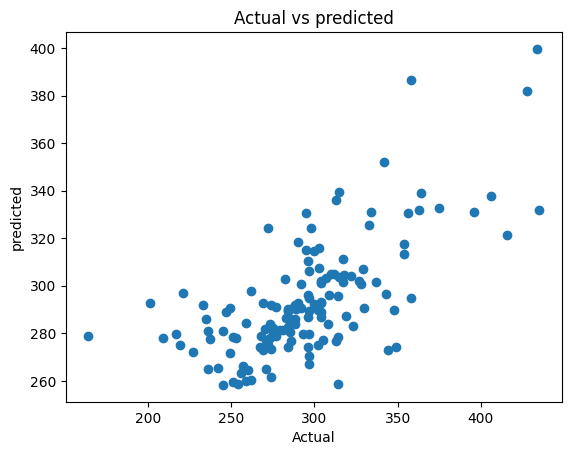

In [52]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test4, np.squeeze(model6.predict(X_test4)) )
print('r2_score:', r2_score)


from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test4, np.squeeze(model6.predict(X_test4)) )
mae= mean_absolute_error(Y_test4, np.squeeze(model6.predict(X_test4)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test4, np.squeeze(model6.predict(X_test4)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [53]:
prediction7 =np.squeeze(model6.predict([[80,2,2,prediction6]]))
print("Prediction: {}".format(prediction7))

y_prd=np.squeeze(np.squeeze(model6.predict(X_test4)) )
predic_dif=pd.DataFrame({'Actual':Y_test4,'predict':y_prd,"differences":Y_test4  -y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 169ms/step
Prediction: 297.4596252441406
5/5 [==============================] - 0s 7ms/step


,Actual,predict,differences
379,303,307.584808,-4.584808
279,313,336.082336,-23.082336
61,298,324.393951,-26.393951
1164,245,280.824768,-35.824768
649,253,278.136108,-25.136108
1042,309,296.190002,12.809998
483,284,289.316833,-5.316833
1491,259,259.739716,-0.739716
542,314,295.590668,18.409332
330,296,310.469513,-14.469513


## Dense and RNN

In [54]:
from keras.layers import Dense, Dropout,Activation
from keras.models import Sequential
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
model7=Sequential()
model7.add(Dense(128, input_dim=3, activation='relu'))
model7.add(Dense(64,activation='relu'))
model7.add(Dense(1,activation='linear'))
model7.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               512       
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [55]:
model7.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
25/25 [==============================] - 1s 8ms/step - loss: 65056.7539 - mae: 247.2514 - val_loss: 48336.5586 - val_mae: 207.6162
Epoch 2/2000
25/25 [==============================] - 0s 3ms/step - loss: 31334.0781 - mae: 154.4085 - val_loss: 20454.9805 - val_mae: 113.8323
Epoch 3/2000
25/25 [==============================] - 0s 3ms/step - loss: 17950.0586 - mae: 109.2959 - val_loss: 17443.5059 - val_mae: 105.8390
Epoch 4/2000
25/25 [==============================] - 0s 3ms/step - loss: 17682.7129 - mae: 108.6330 - val_loss: 17442.2988 - val_mae: 105.3192
Epoch 5/2000
25/25 [==============================] - 0s 3ms/step - loss: 17421.2852 - mae: 107.5713 - val_loss: 17141.9941 - val_mae: 104.4617
Epoch 6/2000
25/25 [==============================] - 0s 3ms/step - loss: 17119.8926 - mae: 106.3921 - val_loss: 16847.9219 - val_mae: 103.5140
Epoch 7/2000
25/25 [==============================] - 0s 3ms/step - loss: 16804.9141 - mae: 105.5236 - val_loss: 16504.9160 - val_mae: 1

Epoch 59/2000
25/25 [==============================] - 0s 3ms/step - loss: 5005.9292 - mae: 53.7988 - val_loss: 5703.1245 - val_mae: 57.3667
Epoch 60/2000
25/25 [==============================] - 0s 3ms/step - loss: 4989.3696 - mae: 53.9436 - val_loss: 5419.2534 - val_mae: 55.7875
Epoch 61/2000
25/25 [==============================] - 0s 3ms/step - loss: 4858.9644 - mae: 52.9346 - val_loss: 5372.8921 - val_mae: 55.5121
Epoch 62/2000
25/25 [==============================] - 0s 3ms/step - loss: 4742.6914 - mae: 52.5246 - val_loss: 5260.2700 - val_mae: 55.1178
Epoch 63/2000
25/25 [==============================] - 0s 4ms/step - loss: 4634.8486 - mae: 51.7603 - val_loss: 5261.0259 - val_mae: 54.9298
Epoch 64/2000
25/25 [==============================] - 0s 4ms/step - loss: 4555.1890 - mae: 51.1177 - val_loss: 5001.8730 - val_mae: 53.5215
Epoch 65/2000
25/25 [==============================] - 0s 3ms/step - loss: 4350.9761 - mae: 49.8447 - val_loss: 4851.4819 - val_mae: 52.4203
Epoch 66/2000

Epoch 117/2000
25/25 [==============================] - 0s 3ms/step - loss: 1551.7670 - mae: 24.6974 - val_loss: 2262.4058 - val_mae: 30.7852
Epoch 118/2000
25/25 [==============================] - 0s 3ms/step - loss: 1560.9240 - mae: 24.8105 - val_loss: 2353.9692 - val_mae: 33.7683
Epoch 119/2000
25/25 [==============================] - 0s 3ms/step - loss: 1567.9369 - mae: 24.8840 - val_loss: 2259.1558 - val_mae: 29.6127
Epoch 120/2000
25/25 [==============================] - 0s 3ms/step - loss: 1541.6624 - mae: 24.5434 - val_loss: 2455.3101 - val_mae: 35.8682
Epoch 121/2000
25/25 [==============================] - 0s 3ms/step - loss: 1731.3351 - mae: 27.9590 - val_loss: 2283.7498 - val_mae: 32.1825
Epoch 122/2000
25/25 [==============================] - 0s 4ms/step - loss: 1712.5132 - mae: 27.3477 - val_loss: 2251.1345 - val_mae: 31.0184
Epoch 123/2000
25/25 [==============================] - 0s 3ms/step - loss: 1577.4739 - mae: 24.7292 - val_loss: 2232.8892 - val_mae: 30.4375
Epoch 

Epoch 175/2000
25/25 [==============================] - 0s 3ms/step - loss: 1519.0482 - mae: 23.9838 - val_loss: 2244.6487 - val_mae: 29.1131
Epoch 176/2000
25/25 [==============================] - 0s 3ms/step - loss: 1515.7096 - mae: 24.2803 - val_loss: 2247.5344 - val_mae: 29.0497
Epoch 177/2000
25/25 [==============================] - 0s 3ms/step - loss: 1558.5564 - mae: 24.7470 - val_loss: 2227.8643 - val_mae: 29.0643
Epoch 178/2000
25/25 [==============================] - 0s 3ms/step - loss: 1550.2809 - mae: 24.5530 - val_loss: 2437.4180 - val_mae: 31.7106
Epoch 179/2000
25/25 [==============================] - 0s 3ms/step - loss: 1636.1145 - mae: 26.0071 - val_loss: 2326.5886 - val_mae: 29.9864
Epoch 180/2000
25/25 [==============================] - 0s 3ms/step - loss: 1526.5840 - mae: 24.4783 - val_loss: 2239.9043 - val_mae: 28.9635
Epoch 181/2000
25/25 [==============================] - 0s 4ms/step - loss: 1569.3855 - mae: 24.7022 - val_loss: 2201.7344 - val_mae: 29.4362
Epoch 

Epoch 233/2000
25/25 [==============================] - 0s 3ms/step - loss: 1550.0593 - mae: 24.9730 - val_loss: 2239.8601 - val_mae: 28.9960
Epoch 234/2000
25/25 [==============================] - 0s 3ms/step - loss: 1549.2954 - mae: 24.7720 - val_loss: 2318.5352 - val_mae: 29.8287
Epoch 235/2000
25/25 [==============================] - 0s 3ms/step - loss: 1506.2709 - mae: 24.1427 - val_loss: 2214.6436 - val_mae: 30.5101
Epoch 236/2000
25/25 [==============================] - 0s 3ms/step - loss: 1529.8093 - mae: 24.2443 - val_loss: 2250.7671 - val_mae: 32.0786
Epoch 237/2000
25/25 [==============================] - 0s 3ms/step - loss: 1593.2137 - mae: 25.3648 - val_loss: 2213.6060 - val_mae: 29.0273
Epoch 238/2000
25/25 [==============================] - 0s 3ms/step - loss: 1571.4146 - mae: 25.3773 - val_loss: 2261.4690 - val_mae: 29.0321
Epoch 239/2000
25/25 [==============================] - 0s 3ms/step - loss: 1588.1704 - mae: 26.1107 - val_loss: 2220.0103 - val_mae: 28.8932
Epoch 

Epoch 291/2000
25/25 [==============================] - 0s 3ms/step - loss: 1550.8140 - mae: 25.2190 - val_loss: 2196.4058 - val_mae: 31.2015
Epoch 292/2000
25/25 [==============================] - 0s 3ms/step - loss: 1494.9489 - mae: 23.5428 - val_loss: 2164.4209 - val_mae: 29.3677
Epoch 293/2000
25/25 [==============================] - 0s 3ms/step - loss: 1545.1310 - mae: 24.8331 - val_loss: 2179.5757 - val_mae: 30.6117
Epoch 294/2000
25/25 [==============================] - 0s 3ms/step - loss: 1486.0588 - mae: 23.9026 - val_loss: 2165.8733 - val_mae: 29.2850
Epoch 295/2000
25/25 [==============================] - 0s 3ms/step - loss: 1510.5707 - mae: 24.0409 - val_loss: 2207.2446 - val_mae: 28.9764
Epoch 296/2000
25/25 [==============================] - 0s 3ms/step - loss: 1509.2999 - mae: 24.0775 - val_loss: 2341.4299 - val_mae: 30.4888
Epoch 297/2000
25/25 [==============================] - 0s 3ms/step - loss: 1503.2682 - mae: 24.1513 - val_loss: 2243.8083 - val_mae: 29.2157
Epoch 

Epoch 349/2000
25/25 [==============================] - 0s 3ms/step - loss: 1490.3568 - mae: 23.9931 - val_loss: 2184.4575 - val_mae: 28.8813
Epoch 350/2000
25/25 [==============================] - 0s 3ms/step - loss: 1498.4247 - mae: 24.2892 - val_loss: 2289.7458 - val_mae: 29.8555
Epoch 351/2000
25/25 [==============================] - 0s 3ms/step - loss: 1497.8591 - mae: 23.7491 - val_loss: 2162.0498 - val_mae: 29.2749
Epoch 352/2000
25/25 [==============================] - 0s 3ms/step - loss: 1487.8431 - mae: 23.6425 - val_loss: 2203.8862 - val_mae: 31.1679
Epoch 353/2000
25/25 [==============================] - 0s 3ms/step - loss: 1574.8766 - mae: 25.6459 - val_loss: 2178.7981 - val_mae: 30.4497
Epoch 354/2000
25/25 [==============================] - 0s 3ms/step - loss: 1502.5432 - mae: 24.4831 - val_loss: 2202.2395 - val_mae: 28.6909
Epoch 355/2000
25/25 [==============================] - 0s 3ms/step - loss: 1501.2968 - mae: 23.9741 - val_loss: 2266.7544 - val_mae: 29.4335
Epoch 

Epoch 407/2000
25/25 [==============================] - 0s 4ms/step - loss: 1473.8750 - mae: 23.7135 - val_loss: 2188.5615 - val_mae: 30.5988
Epoch 408/2000
25/25 [==============================] - 0s 3ms/step - loss: 1466.8652 - mae: 23.5831 - val_loss: 2168.3403 - val_mae: 29.2691
Epoch 409/2000
25/25 [==============================] - 0s 3ms/step - loss: 1516.5533 - mae: 24.6330 - val_loss: 2169.7483 - val_mae: 28.9275
Epoch 410/2000
25/25 [==============================] - 0s 3ms/step - loss: 1482.7784 - mae: 23.5450 - val_loss: 2173.1755 - val_mae: 29.9146
Epoch 411/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.7784 - mae: 24.9909 - val_loss: 2207.1995 - val_mae: 28.9088
Epoch 412/2000
25/25 [==============================] - 0s 3ms/step - loss: 1500.6755 - mae: 24.2107 - val_loss: 2203.9014 - val_mae: 28.8537
Epoch 413/2000
25/25 [==============================] - 0s 3ms/step - loss: 1572.4442 - mae: 26.1041 - val_loss: 2206.0239 - val_mae: 28.8915
Epoch 

Epoch 465/2000
25/25 [==============================] - 0s 3ms/step - loss: 1484.9456 - mae: 24.1420 - val_loss: 2189.2859 - val_mae: 28.8502
Epoch 466/2000
25/25 [==============================] - 0s 3ms/step - loss: 1514.7316 - mae: 24.5322 - val_loss: 2181.8579 - val_mae: 28.8607
Epoch 467/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.9026 - mae: 23.5117 - val_loss: 2191.3242 - val_mae: 28.7545
Epoch 468/2000
25/25 [==============================] - 0s 3ms/step - loss: 1468.6956 - mae: 23.3888 - val_loss: 2166.4753 - val_mae: 29.4868
Epoch 469/2000
25/25 [==============================] - 0s 3ms/step - loss: 1489.2697 - mae: 24.7268 - val_loss: 2183.4456 - val_mae: 28.8656
Epoch 470/2000
25/25 [==============================] - 0s 3ms/step - loss: 1517.6108 - mae: 24.8935 - val_loss: 2233.7827 - val_mae: 32.2069
Epoch 471/2000
25/25 [==============================] - 0s 3ms/step - loss: 1470.9656 - mae: 23.8080 - val_loss: 2206.7610 - val_mae: 28.8275
Epoch 

Epoch 523/2000
25/25 [==============================] - 0s 3ms/step - loss: 1459.6071 - mae: 23.4195 - val_loss: 2195.8726 - val_mae: 28.7897
Epoch 524/2000
25/25 [==============================] - 0s 4ms/step - loss: 1463.0933 - mae: 23.6593 - val_loss: 2258.9392 - val_mae: 32.8171
Epoch 525/2000
25/25 [==============================] - 0s 3ms/step - loss: 1479.3025 - mae: 23.8082 - val_loss: 2168.9478 - val_mae: 28.9014
Epoch 526/2000
25/25 [==============================] - 0s 3ms/step - loss: 1514.3811 - mae: 24.3271 - val_loss: 2203.9216 - val_mae: 31.4019
Epoch 527/2000
25/25 [==============================] - 0s 3ms/step - loss: 1496.8364 - mae: 24.0720 - val_loss: 2194.5710 - val_mae: 30.6603
Epoch 528/2000
25/25 [==============================] - 0s 3ms/step - loss: 1488.9202 - mae: 23.9227 - val_loss: 2181.9575 - val_mae: 28.8297
Epoch 529/2000
25/25 [==============================] - 0s 3ms/step - loss: 1451.9982 - mae: 23.3119 - val_loss: 2172.1467 - val_mae: 29.2528
Epoch 

Epoch 581/2000
25/25 [==============================] - 0s 3ms/step - loss: 1463.1676 - mae: 23.4936 - val_loss: 2172.9788 - val_mae: 28.7755
Epoch 582/2000
25/25 [==============================] - 0s 3ms/step - loss: 1508.0988 - mae: 24.4242 - val_loss: 2366.2007 - val_mae: 31.0063
Epoch 583/2000
25/25 [==============================] - 0s 3ms/step - loss: 1513.1836 - mae: 24.3914 - val_loss: 2192.4697 - val_mae: 28.8837
Epoch 584/2000
25/25 [==============================] - 0s 3ms/step - loss: 1497.6514 - mae: 24.0114 - val_loss: 2178.1082 - val_mae: 30.0060
Epoch 585/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.6454 - mae: 24.5120 - val_loss: 2410.5872 - val_mae: 31.8158
Epoch 586/2000
25/25 [==============================] - 0s 3ms/step - loss: 1458.0497 - mae: 23.8057 - val_loss: 2185.1108 - val_mae: 30.3539
Epoch 587/2000
25/25 [==============================] - 0s 3ms/step - loss: 1468.1964 - mae: 23.6081 - val_loss: 2195.5876 - val_mae: 28.8657
Epoch 

Epoch 639/2000
25/25 [==============================] - 0s 3ms/step - loss: 1509.8789 - mae: 24.7750 - val_loss: 2159.8889 - val_mae: 29.0621
Epoch 640/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.1298 - mae: 24.5587 - val_loss: 2295.1494 - val_mae: 29.9478
Epoch 641/2000
25/25 [==============================] - 0s 3ms/step - loss: 1474.0253 - mae: 23.9031 - val_loss: 2257.5615 - val_mae: 32.6465
Epoch 642/2000
25/25 [==============================] - 0s 3ms/step - loss: 1511.1658 - mae: 24.7145 - val_loss: 2213.3604 - val_mae: 29.0136
Epoch 643/2000
25/25 [==============================] - 0s 3ms/step - loss: 1466.7156 - mae: 23.5012 - val_loss: 2188.3254 - val_mae: 28.8043
Epoch 644/2000
25/25 [==============================] - 0s 3ms/step - loss: 1458.1978 - mae: 23.6577 - val_loss: 2246.9497 - val_mae: 29.3688
Epoch 645/2000
25/25 [==============================] - 0s 3ms/step - loss: 1462.6125 - mae: 23.5906 - val_loss: 2164.3521 - val_mae: 28.9910
Epoch 

Epoch 697/2000
25/25 [==============================] - 0s 3ms/step - loss: 1481.8876 - mae: 23.6950 - val_loss: 2203.7524 - val_mae: 28.8983
Epoch 698/2000
25/25 [==============================] - 0s 3ms/step - loss: 1452.1458 - mae: 23.3554 - val_loss: 2235.9292 - val_mae: 29.2139
Epoch 699/2000
25/25 [==============================] - 0s 3ms/step - loss: 1519.2231 - mae: 25.0985 - val_loss: 2175.3960 - val_mae: 30.1771
Epoch 700/2000
25/25 [==============================] - 0s 3ms/step - loss: 1453.8889 - mae: 23.3595 - val_loss: 2210.4717 - val_mae: 28.9564
Epoch 701/2000
25/25 [==============================] - 0s 3ms/step - loss: 1441.3591 - mae: 23.3230 - val_loss: 2163.0955 - val_mae: 29.6622
Epoch 702/2000
25/25 [==============================] - 0s 3ms/step - loss: 1507.1372 - mae: 24.4946 - val_loss: 2270.5947 - val_mae: 33.0528
Epoch 703/2000
25/25 [==============================] - 0s 3ms/step - loss: 1465.2783 - mae: 23.5176 - val_loss: 2161.3308 - val_mae: 29.2863
Epoch 

Epoch 755/2000
25/25 [==============================] - 0s 4ms/step - loss: 1453.0391 - mae: 23.3422 - val_loss: 2285.0046 - val_mae: 33.4001
Epoch 756/2000
25/25 [==============================] - 0s 3ms/step - loss: 1468.2863 - mae: 24.6165 - val_loss: 2217.8975 - val_mae: 29.1407
Epoch 757/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.1617 - mae: 23.3974 - val_loss: 2178.3706 - val_mae: 28.8396
Epoch 758/2000
25/25 [==============================] - 0s 3ms/step - loss: 1519.3312 - mae: 24.3992 - val_loss: 2159.3347 - val_mae: 29.3363
Epoch 759/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.1301 - mae: 25.1832 - val_loss: 2316.9409 - val_mae: 30.4219
Epoch 760/2000
25/25 [==============================] - 0s 3ms/step - loss: 1465.8333 - mae: 23.6068 - val_loss: 2163.5540 - val_mae: 29.7014
Epoch 761/2000
25/25 [==============================] - 0s 3ms/step - loss: 1498.7538 - mae: 24.5604 - val_loss: 2184.6362 - val_mae: 30.6415
Epoch 

Epoch 813/2000
25/25 [==============================] - 0s 3ms/step - loss: 1449.0657 - mae: 23.3915 - val_loss: 2262.2358 - val_mae: 29.5203
Epoch 814/2000
25/25 [==============================] - 0s 3ms/step - loss: 1455.5923 - mae: 23.6513 - val_loss: 2241.6494 - val_mae: 29.2313
Epoch 815/2000
25/25 [==============================] - 0s 3ms/step - loss: 1428.1995 - mae: 23.2844 - val_loss: 2244.4121 - val_mae: 29.0829
Epoch 816/2000
25/25 [==============================] - 0s 3ms/step - loss: 1609.4974 - mae: 26.6320 - val_loss: 2173.8940 - val_mae: 29.1083
Epoch 817/2000
25/25 [==============================] - 0s 3ms/step - loss: 1460.0056 - mae: 24.0317 - val_loss: 2167.7671 - val_mae: 29.8309
Epoch 818/2000
25/25 [==============================] - 0s 3ms/step - loss: 1447.5665 - mae: 23.3167 - val_loss: 2181.6985 - val_mae: 28.7942
Epoch 819/2000
25/25 [==============================] - 0s 3ms/step - loss: 1434.5959 - mae: 23.2091 - val_loss: 2173.8057 - val_mae: 28.7368
Epoch 

Epoch 871/2000
25/25 [==============================] - 0s 3ms/step - loss: 1459.9204 - mae: 23.8423 - val_loss: 2286.0513 - val_mae: 33.3347
Epoch 872/2000
25/25 [==============================] - 0s 3ms/step - loss: 1456.6860 - mae: 24.0230 - val_loss: 2230.6909 - val_mae: 29.0707
Epoch 873/2000
25/25 [==============================] - 0s 3ms/step - loss: 1482.7129 - mae: 24.3714 - val_loss: 2167.1035 - val_mae: 29.5416
Epoch 874/2000
25/25 [==============================] - 0s 3ms/step - loss: 1449.1783 - mae: 23.5235 - val_loss: 2163.6992 - val_mae: 29.1405
Epoch 875/2000
25/25 [==============================] - 0s 3ms/step - loss: 1436.5621 - mae: 23.1873 - val_loss: 2164.2380 - val_mae: 29.4411
Epoch 876/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.9567 - mae: 23.8795 - val_loss: 2230.0847 - val_mae: 31.9685
Epoch 877/2000
25/25 [==============================] - 0s 3ms/step - loss: 1487.5640 - mae: 24.6530 - val_loss: 2168.7119 - val_mae: 29.2278
Epoch 

Epoch 929/2000
25/25 [==============================] - 0s 3ms/step - loss: 1486.0952 - mae: 24.1783 - val_loss: 2242.1140 - val_mae: 32.3627
Epoch 930/2000
25/25 [==============================] - 0s 4ms/step - loss: 1476.0703 - mae: 24.0509 - val_loss: 2212.1792 - val_mae: 31.6389
Epoch 931/2000
25/25 [==============================] - 0s 3ms/step - loss: 1479.2714 - mae: 24.1856 - val_loss: 2171.6606 - val_mae: 28.8297
Epoch 932/2000
25/25 [==============================] - 0s 3ms/step - loss: 1439.4507 - mae: 23.5190 - val_loss: 2179.7751 - val_mae: 28.6302
Epoch 933/2000
25/25 [==============================] - 0s 4ms/step - loss: 1435.3701 - mae: 23.0114 - val_loss: 2180.2178 - val_mae: 30.7077
Epoch 934/2000
25/25 [==============================] - 0s 4ms/step - loss: 1462.7518 - mae: 23.7531 - val_loss: 2217.2852 - val_mae: 31.6958
Epoch 935/2000
25/25 [==============================] - 0s 4ms/step - loss: 1498.2830 - mae: 24.7988 - val_loss: 2196.1282 - val_mae: 28.9680
Epoch 

Epoch 987/2000
25/25 [==============================] - 0s 4ms/step - loss: 1418.8235 - mae: 23.1030 - val_loss: 2234.0337 - val_mae: 29.0064
Epoch 988/2000
25/25 [==============================] - 0s 4ms/step - loss: 1470.4327 - mae: 23.7981 - val_loss: 2182.2881 - val_mae: 30.3309
Epoch 989/2000
25/25 [==============================] - 0s 4ms/step - loss: 1524.1792 - mae: 25.1240 - val_loss: 2271.0122 - val_mae: 29.5900
Epoch 990/2000
25/25 [==============================] - 0s 4ms/step - loss: 1464.2040 - mae: 23.3426 - val_loss: 2175.8127 - val_mae: 28.5871
Epoch 991/2000
25/25 [==============================] - 0s 4ms/step - loss: 1447.9601 - mae: 22.9940 - val_loss: 2184.4351 - val_mae: 28.7282
Epoch 992/2000
25/25 [==============================] - 0s 5ms/step - loss: 1466.1156 - mae: 23.6034 - val_loss: 2164.6853 - val_mae: 29.0349
Epoch 993/2000
25/25 [==============================] - 0s 4ms/step - loss: 1439.9916 - mae: 23.4610 - val_loss: 2167.9175 - val_mae: 29.1390
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 1453.9291 - mae: 23.2475 - val_loss: 2170.2170 - val_mae: 28.6454
Epoch 1102/2000
25/25 [==============================] - 0s 4ms/step - loss: 1455.3033 - mae: 23.2797 - val_loss: 2169.4846 - val_mae: 29.4289
Epoch 1103/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.1953 - mae: 23.9384 - val_loss: 2154.4841 - val_mae: 28.9689
Epoch 1104/2000
25/25 [==============================] - 0s 4ms/step - loss: 1449.1040 - mae: 23.7010 - val_loss: 2283.4731 - val_mae: 29.7568
Epoch 1105/2000
25/25 [==============================] - 0s 4ms/step - loss: 1488.1705 - mae: 23.9005 - val_loss: 2445.1545 - val_mae: 32.5052
Epoch 1106/2000
25/25 [==============================] - 0s 4ms/step - loss: 1529.7180 - mae: 25.2442 - val_loss: 2254.0032 - val_mae: 32.3286
Epoch 1107/2000
25/25 [==============================] - 0s 4ms/step - loss: 1467.6484 - mae: 23.3594 - val_loss: 2165.5393 - val_mae: 28.6010
Epoch 1108/2000

25/25 [==============================] - 0s 3ms/step - loss: 1429.9073 - mae: 23.5459 - val_loss: 2160.0088 - val_mae: 28.4936
Epoch 1216/2000
25/25 [==============================] - 0s 4ms/step - loss: 1420.2719 - mae: 22.6606 - val_loss: 2254.0999 - val_mae: 29.4434
Epoch 1217/2000
25/25 [==============================] - 0s 4ms/step - loss: 1467.5865 - mae: 24.0849 - val_loss: 2223.4167 - val_mae: 31.7440
Epoch 1218/2000
25/25 [==============================] - 0s 3ms/step - loss: 1565.9022 - mae: 25.4086 - val_loss: 2159.2393 - val_mae: 29.4025
Epoch 1219/2000
25/25 [==============================] - 0s 3ms/step - loss: 1462.0094 - mae: 24.0882 - val_loss: 2181.9636 - val_mae: 28.3650
Epoch 1220/2000
25/25 [==============================] - 0s 3ms/step - loss: 1470.0958 - mae: 23.5219 - val_loss: 2177.5552 - val_mae: 30.0474
Epoch 1221/2000
25/25 [==============================] - 0s 3ms/step - loss: 1435.2136 - mae: 23.9306 - val_loss: 2158.3279 - val_mae: 29.0821
Epoch 1222/2000

25/25 [==============================] - 0s 3ms/step - loss: 1443.0613 - mae: 22.9892 - val_loss: 2170.5811 - val_mae: 29.9987
Epoch 1330/2000
25/25 [==============================] - 0s 3ms/step - loss: 1446.8571 - mae: 23.5516 - val_loss: 2154.6301 - val_mae: 28.3875
Epoch 1331/2000
25/25 [==============================] - 0s 3ms/step - loss: 1439.8064 - mae: 24.0067 - val_loss: 2149.3491 - val_mae: 29.1042
Epoch 1332/2000
25/25 [==============================] - 0s 3ms/step - loss: 1452.3767 - mae: 23.7816 - val_loss: 2171.8782 - val_mae: 28.3128
Epoch 1333/2000
25/25 [==============================] - 0s 3ms/step - loss: 1440.5144 - mae: 23.1537 - val_loss: 2158.5273 - val_mae: 28.9886
Epoch 1334/2000
25/25 [==============================] - 0s 3ms/step - loss: 1404.9861 - mae: 22.9697 - val_loss: 2257.8586 - val_mae: 29.4234
Epoch 1335/2000
25/25 [==============================] - 0s 3ms/step - loss: 1435.8359 - mae: 23.0206 - val_loss: 2164.7620 - val_mae: 29.8059
Epoch 1336/2000

25/25 [==============================] - 0s 3ms/step - loss: 1442.4380 - mae: 23.1257 - val_loss: 2147.6682 - val_mae: 28.5719
Epoch 1444/2000
25/25 [==============================] - 0s 3ms/step - loss: 1446.1115 - mae: 23.5578 - val_loss: 2188.2778 - val_mae: 28.5944
Epoch 1445/2000
25/25 [==============================] - 0s 3ms/step - loss: 1426.0717 - mae: 22.7737 - val_loss: 2177.5129 - val_mae: 28.2965
Epoch 1446/2000
25/25 [==============================] - 0s 3ms/step - loss: 1475.8975 - mae: 23.8136 - val_loss: 2190.4255 - val_mae: 28.4178
Epoch 1447/2000
25/25 [==============================] - 0s 3ms/step - loss: 1465.1404 - mae: 23.9465 - val_loss: 2161.5149 - val_mae: 28.5096
Epoch 1448/2000
25/25 [==============================] - 0s 3ms/step - loss: 1431.0625 - mae: 22.8456 - val_loss: 2153.5383 - val_mae: 28.3214
Epoch 1449/2000
25/25 [==============================] - 0s 3ms/step - loss: 1430.2148 - mae: 22.9993 - val_loss: 2165.0427 - val_mae: 28.2786
Epoch 1450/2000

25/25 [==============================] - 0s 3ms/step - loss: 1427.7690 - mae: 22.9777 - val_loss: 2143.5100 - val_mae: 29.1598
Epoch 1558/2000
25/25 [==============================] - 0s 3ms/step - loss: 1435.3837 - mae: 22.8858 - val_loss: 2167.8215 - val_mae: 28.3416
Epoch 1559/2000
25/25 [==============================] - 0s 3ms/step - loss: 1439.6718 - mae: 23.8726 - val_loss: 2162.0945 - val_mae: 28.2521
Epoch 1560/2000
25/25 [==============================] - 0s 4ms/step - loss: 1421.3560 - mae: 23.1220 - val_loss: 2185.9924 - val_mae: 28.5052
Epoch 1561/2000
25/25 [==============================] - 0s 4ms/step - loss: 1442.5460 - mae: 23.5619 - val_loss: 2153.7441 - val_mae: 28.3999
Epoch 1562/2000
25/25 [==============================] - 0s 4ms/step - loss: 1421.0712 - mae: 23.0001 - val_loss: 2147.5139 - val_mae: 28.3033
Epoch 1563/2000
25/25 [==============================] - 0s 4ms/step - loss: 1431.5015 - mae: 23.2204 - val_loss: 2160.2061 - val_mae: 28.3228
Epoch 1564/2000

25/25 [==============================] - 0s 3ms/step - loss: 1468.3427 - mae: 24.7896 - val_loss: 2151.3235 - val_mae: 28.2359
Epoch 1672/2000
25/25 [==============================] - 0s 3ms/step - loss: 1429.9664 - mae: 23.3401 - val_loss: 2174.2090 - val_mae: 30.8538
Epoch 1673/2000
25/25 [==============================] - 0s 3ms/step - loss: 1453.9971 - mae: 24.0573 - val_loss: 2169.4858 - val_mae: 28.2266
Epoch 1674/2000
25/25 [==============================] - 0s 3ms/step - loss: 1445.7994 - mae: 23.2438 - val_loss: 2175.0991 - val_mae: 30.6834
Epoch 1675/2000
25/25 [==============================] - 0s 3ms/step - loss: 1522.4489 - mae: 25.0542 - val_loss: 2263.1602 - val_mae: 29.7343
Epoch 1676/2000
25/25 [==============================] - 0s 3ms/step - loss: 1434.8245 - mae: 23.4864 - val_loss: 2158.1899 - val_mae: 28.2894
Epoch 1677/2000
25/25 [==============================] - 0s 3ms/step - loss: 1448.3179 - mae: 23.5544 - val_loss: 2173.0476 - val_mae: 28.4033
Epoch 1678/2000

25/25 [==============================] - 0s 3ms/step - loss: 1394.3086 - mae: 22.6595 - val_loss: 2222.6450 - val_mae: 28.9581
Epoch 1786/2000
25/25 [==============================] - 0s 3ms/step - loss: 1456.3655 - mae: 23.6206 - val_loss: 2146.2092 - val_mae: 28.5727
Epoch 1787/2000
25/25 [==============================] - 0s 3ms/step - loss: 1380.8486 - mae: 22.4163 - val_loss: 2203.5730 - val_mae: 28.6728
Epoch 1788/2000
25/25 [==============================] - 0s 3ms/step - loss: 1462.5043 - mae: 23.8188 - val_loss: 2175.0359 - val_mae: 30.4248
Epoch 1789/2000
25/25 [==============================] - 0s 3ms/step - loss: 1418.4275 - mae: 23.4120 - val_loss: 2153.3281 - val_mae: 29.5298
Epoch 1790/2000
25/25 [==============================] - 0s 3ms/step - loss: 1406.5339 - mae: 22.7211 - val_loss: 2151.0056 - val_mae: 28.9159
Epoch 1791/2000
25/25 [==============================] - 0s 3ms/step - loss: 1413.8722 - mae: 22.7104 - val_loss: 2139.1631 - val_mae: 28.5234
Epoch 1792/2000

25/25 [==============================] - 0s 3ms/step - loss: 1437.9967 - mae: 23.4041 - val_loss: 2160.8037 - val_mae: 28.3473
Epoch 1900/2000
25/25 [==============================] - 0s 3ms/step - loss: 1392.8718 - mae: 22.5502 - val_loss: 2122.4233 - val_mae: 28.5146
Epoch 1901/2000
25/25 [==============================] - 0s 3ms/step - loss: 1390.4381 - mae: 22.5056 - val_loss: 2149.6355 - val_mae: 28.4206
Epoch 1902/2000
25/25 [==============================] - 0s 3ms/step - loss: 1464.1682 - mae: 24.4736 - val_loss: 2241.0991 - val_mae: 29.4937
Epoch 1903/2000
25/25 [==============================] - 0s 3ms/step - loss: 1461.7731 - mae: 24.0854 - val_loss: 2175.5034 - val_mae: 28.6457
Epoch 1904/2000
25/25 [==============================] - 0s 3ms/step - loss: 1401.9144 - mae: 22.8099 - val_loss: 2134.8569 - val_mae: 28.4572
Epoch 1905/2000
25/25 [==============================] - 0s 3ms/step - loss: 1384.5371 - mae: 22.9091 - val_loss: 2142.2603 - val_mae: 28.4734
Epoch 1906/2000

In [56]:
prediction8 = np.squeeze(model7.predict([[80,2,2]]))
print("Prediction: {}".format(prediction8))

1/1 [==============================] - 0s 77ms/step
Prediction: 297.9721984863281


In [57]:
y_prd=np.squeeze(np.squeeze(model7.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

16/16 [==============================] - 0s 2ms/step
      Actual     predict  differences
443      287  303.850342   -16.850342
319      317  304.614319    12.385681
703      295  281.487244    13.512756
526      320  308.111145    11.888855
76       435  354.682831    80.317169
...      ...         ...          ...
1232     287  294.800018    -7.800018
330      296  309.018005   -13.018005
1087     274  277.067322    -3.067322
789      321  307.837250    13.162750
1618     314  273.115387    40.884613

[488 rows x 3 columns]


In [58]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

140.53604125976562
-121.614501953125
175.85858154296875
137.49688720703125
173.77728271484375
-118.76239013671875
-137.2318115234375
146.2803955078125
163.14614868164062
122.52154541015625
144.39959716796875
130.001953125
-115.1043701171875
135.98257446289062
172.46160888671875
142.4298095703125
lower bound: -113.60026873353041
upper bound: 121.59643777689939


In [59]:
A.drop(A[(A['differences'] >121)].index, inplace=True)
A.drop(A[(A['differences'] <-113)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X5=B.drop('Actual',axis=1)
Y5=B['Actual']
X_train5, X_test5, Y_train5, Y_test5 =train_test_split(X5,Y5, test_size=0.3, random_state = 0)

      AverageFloorArea  Year/Quarter  Property Type  Actual     predict
2                   19             1              4     375  343.535278
4                   20             1              2     366  375.966370
9                   23             2              5     408  390.219910
14                  25             2              1     358  399.020782
17                  26             1              5     334  351.240723
...                ...           ...            ...     ...         ...
1616               155             2              3     242  274.586212
1618               155             4              3     314  273.115387
1619               156             1              3     275  282.557800
1622               156             3              4     289  277.507904
1625               157             4              3     254  273.108887

[472 rows x 5 columns]


In [60]:
from keras.layers import Dense, Dropout,Activation, LSTM
from keras.models import Sequential
model8=Sequential()
model8.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train5.shape[1],1)))
model8.add(Dropout(0.2))
model8.add(LSTM(units=64, activation='relu', return_sequences=True))
model8.add(Dropout(0.3))
model8.add(LSTM(units=32, activation='relu', return_sequences=True))
model8.add(Dropout(0.4))
model8.add(LSTM(units=64, activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(units=1))
model8.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model8.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 4, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 4, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_10 (LSTM)              (None, 4, 32)             12416     
                                                                 
 dropout_6 (Dropout)         (None, 4, 32)             0         
                                                                 
 lstm_11 (LSTM)              (None, 64)              

In [61]:
model8.fit(X_train5,Y_train5 ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
8/8 [==============================] - 6s 123ms/step - loss: 90155.9219 - mae: 298.0641 - val_loss: 87578.8281 - val_mae: 293.9842
Epoch 2/2000
8/8 [==============================] - 0s 17ms/step - loss: 83279.5625 - mae: 285.4730 - val_loss: 52301.9219 - val_mae: 220.0995
Epoch 3/2000
8/8 [==============================] - 0s 17ms/step - loss: 43447.4492 - mae: 182.6066 - val_loss: 50103.5352 - val_mae: 178.2234
Epoch 4/2000
8/8 [==============================] - 0s 17ms/step - loss: 42306.2383 - mae: 165.5121 - val_loss: 21470.4453 - val_mae: 122.4320
Epoch 5/2000
8/8 [==============================] - 0s 17ms/step - loss: 32246.5781 - mae: 157.4434 - val_loss: 15902.1641 - val_mae: 104.0931
Epoch 6/2000
8/8 [==============================] - 0s 17ms/step - loss: 22804.5527 - mae: 124.1737 - val_loss: 8361.1523 - val_mae: 74.4658
Epoch 7/2000
8/8 [==============================] - 0s 18ms/step - loss: 18222.1230 - mae: 111.6006 - val_loss: 8540.5723 - val_mae: 75.3883
Ep

8/8 [==============================] - 0s 16ms/step - loss: 3646.4285 - mae: 49.1401 - val_loss: 4289.3911 - val_mae: 58.9156
Epoch 118/2000
8/8 [==============================] - 0s 17ms/step - loss: 3319.6299 - mae: 45.4678 - val_loss: 2329.7725 - val_mae: 40.4410
Epoch 119/2000
8/8 [==============================] - 0s 16ms/step - loss: 3559.6418 - mae: 48.5002 - val_loss: 2413.9939 - val_mae: 41.3770
Epoch 120/2000
8/8 [==============================] - 0s 17ms/step - loss: 3787.9753 - mae: 48.9166 - val_loss: 3531.2969 - val_mae: 52.7068
Epoch 121/2000
8/8 [==============================] - 0s 17ms/step - loss: 3836.7830 - mae: 48.7424 - val_loss: 1790.1396 - val_mae: 33.8106
Epoch 122/2000
8/8 [==============================] - 0s 17ms/step - loss: 3710.1199 - mae: 48.5211 - val_loss: 3364.9021 - val_mae: 51.0293
Epoch 123/2000
8/8 [==============================] - 0s 16ms/step - loss: 3813.6707 - mae: 47.9822 - val_loss: 2045.2700 - val_mae: 37.2167
Epoch 124/2000
8/8 [========

8/8 [==============================] - 0s 17ms/step - loss: 3199.4172 - mae: 44.4570 - val_loss: 1130.2557 - val_mae: 24.1277
Epoch 234/2000
8/8 [==============================] - 0s 17ms/step - loss: 2999.6318 - mae: 44.1921 - val_loss: 1281.3296 - val_mae: 26.4096
Epoch 235/2000
8/8 [==============================] - 0s 17ms/step - loss: 2836.1221 - mae: 41.1218 - val_loss: 1599.2145 - val_mae: 31.4880
Epoch 236/2000
8/8 [==============================] - 0s 25ms/step - loss: 3069.2107 - mae: 44.1002 - val_loss: 978.6796 - val_mae: 22.2962
Epoch 237/2000
8/8 [==============================] - 0s 17ms/step - loss: 2312.0288 - mae: 36.5910 - val_loss: 1598.4877 - val_mae: 31.3924
Epoch 238/2000
8/8 [==============================] - 0s 17ms/step - loss: 3645.9070 - mae: 46.7033 - val_loss: 993.7137 - val_mae: 22.3451
Epoch 239/2000
8/8 [==============================] - 0s 17ms/step - loss: 3642.9695 - mae: 47.0455 - val_loss: 1706.8577 - val_mae: 32.9841
Epoch 240/2000
8/8 [==========

8/8 [==============================] - 0s 17ms/step - loss: 2500.5959 - mae: 39.1790 - val_loss: 954.9155 - val_mae: 22.0689
Epoch 350/2000
8/8 [==============================] - 0s 17ms/step - loss: 2745.3345 - mae: 42.3494 - val_loss: 1009.8898 - val_mae: 23.2709
Epoch 351/2000
8/8 [==============================] - 0s 17ms/step - loss: 3103.4739 - mae: 44.0312 - val_loss: 1514.8572 - val_mae: 30.3584
Epoch 352/2000
8/8 [==============================] - 0s 17ms/step - loss: 2814.6147 - mae: 40.5714 - val_loss: 978.9529 - val_mae: 22.6264
Epoch 353/2000
8/8 [==============================] - 0s 17ms/step - loss: 2984.8828 - mae: 43.4061 - val_loss: 1126.5076 - val_mae: 24.1530
Epoch 354/2000
8/8 [==============================] - 0s 16ms/step - loss: 3172.3625 - mae: 45.6399 - val_loss: 992.5101 - val_mae: 22.4498
Epoch 355/2000
8/8 [==============================] - 0s 17ms/step - loss: 2934.3843 - mae: 42.6959 - val_loss: 1080.6704 - val_mae: 23.4838
Epoch 356/2000
8/8 [===========

8/8 [==============================] - 0s 17ms/step - loss: 2784.8828 - mae: 40.9856 - val_loss: 959.9872 - val_mae: 21.8726
Epoch 466/2000
8/8 [==============================] - 0s 17ms/step - loss: 3066.1245 - mae: 44.4241 - val_loss: 1017.0446 - val_mae: 22.4641
Epoch 467/2000
8/8 [==============================] - 0s 16ms/step - loss: 2434.4773 - mae: 38.5912 - val_loss: 1224.7147 - val_mae: 25.6346
Epoch 468/2000
8/8 [==============================] - 0s 16ms/step - loss: 2818.8687 - mae: 43.1980 - val_loss: 1003.1967 - val_mae: 22.2185
Epoch 469/2000
8/8 [==============================] - 0s 17ms/step - loss: 3004.7856 - mae: 42.8707 - val_loss: 1102.8475 - val_mae: 23.5723
Epoch 470/2000
8/8 [==============================] - 0s 17ms/step - loss: 2636.6284 - mae: 40.2920 - val_loss: 1273.9403 - val_mae: 26.4322
Epoch 471/2000
8/8 [==============================] - 0s 18ms/step - loss: 2852.6538 - mae: 42.5874 - val_loss: 1022.1772 - val_mae: 22.5418
Epoch 472/2000
8/8 [=========

8/8 [==============================] - 0s 15ms/step - loss: 2747.3779 - mae: 41.1497 - val_loss: 968.4938 - val_mae: 21.8200
Epoch 582/2000
8/8 [==============================] - 0s 15ms/step - loss: 2205.8655 - mae: 36.7893 - val_loss: 945.5849 - val_mae: 21.1528
Epoch 583/2000
8/8 [==============================] - 0s 15ms/step - loss: 2412.7534 - mae: 38.3082 - val_loss: 1114.7130 - val_mae: 23.9547
Epoch 584/2000
8/8 [==============================] - 0s 15ms/step - loss: 2728.3564 - mae: 41.1038 - val_loss: 962.9272 - val_mae: 21.5191
Epoch 585/2000
8/8 [==============================] - 0s 15ms/step - loss: 2600.0161 - mae: 38.9817 - val_loss: 1263.0895 - val_mae: 26.3288
Epoch 586/2000
8/8 [==============================] - 0s 15ms/step - loss: 2733.6423 - mae: 41.3207 - val_loss: 930.8758 - val_mae: 21.1231
Epoch 587/2000
8/8 [==============================] - 0s 15ms/step - loss: 2672.1829 - mae: 40.9818 - val_loss: 1042.6508 - val_mae: 23.0084
Epoch 588/2000
8/8 [============

8/8 [==============================] - 0s 16ms/step - loss: 2497.0081 - mae: 38.9724 - val_loss: 1094.2391 - val_mae: 23.4814
Epoch 698/2000
8/8 [==============================] - 0s 15ms/step - loss: 2713.1687 - mae: 41.7626 - val_loss: 1002.4515 - val_mae: 21.7185
Epoch 699/2000
8/8 [==============================] - 0s 15ms/step - loss: 2606.3696 - mae: 40.9390 - val_loss: 1006.3035 - val_mae: 21.5995
Epoch 700/2000
8/8 [==============================] - 0s 15ms/step - loss: 2545.7100 - mae: 37.6518 - val_loss: 1078.5867 - val_mae: 22.8131
Epoch 701/2000
8/8 [==============================] - 0s 15ms/step - loss: 2768.1997 - mae: 40.5677 - val_loss: 1303.3394 - val_mae: 26.7529
Epoch 702/2000
8/8 [==============================] - 0s 15ms/step - loss: 2610.0271 - mae: 39.8162 - val_loss: 1096.2667 - val_mae: 22.8919
Epoch 703/2000
8/8 [==============================] - 0s 15ms/step - loss: 2836.2795 - mae: 41.3948 - val_loss: 1333.0958 - val_mae: 27.1669
Epoch 704/2000
8/8 [========

8/8 [==============================] - 0s 15ms/step - loss: 2804.0317 - mae: 42.0682 - val_loss: 990.1299 - val_mae: 22.0042
Epoch 814/2000
8/8 [==============================] - 0s 15ms/step - loss: 2736.3757 - mae: 40.9171 - val_loss: 988.1052 - val_mae: 21.9496
Epoch 815/2000
8/8 [==============================] - 0s 15ms/step - loss: 3249.1121 - mae: 43.8582 - val_loss: 934.1164 - val_mae: 20.8055
Epoch 816/2000
8/8 [==============================] - 0s 15ms/step - loss: 2828.7700 - mae: 42.3649 - val_loss: 998.6016 - val_mae: 22.1121
Epoch 817/2000
8/8 [==============================] - 0s 15ms/step - loss: 3008.0208 - mae: 43.7083 - val_loss: 1074.9181 - val_mae: 23.6016
Epoch 818/2000
8/8 [==============================] - 0s 15ms/step - loss: 2409.2566 - mae: 40.1977 - val_loss: 942.0370 - val_mae: 20.6819
Epoch 819/2000
8/8 [==============================] - 0s 15ms/step - loss: 2447.7258 - mae: 38.9545 - val_loss: 935.9130 - val_mae: 20.6575
Epoch 820/2000
8/8 [==============

8/8 [==============================] - 0s 17ms/step - loss: 2435.4260 - mae: 38.8665 - val_loss: 1030.2343 - val_mae: 22.2640
Epoch 930/2000
8/8 [==============================] - 0s 16ms/step - loss: 2791.5435 - mae: 41.3075 - val_loss: 994.4236 - val_mae: 21.6499
Epoch 931/2000
8/8 [==============================] - 0s 17ms/step - loss: 2829.6973 - mae: 42.4732 - val_loss: 1537.2294 - val_mae: 30.2010
Epoch 932/2000
8/8 [==============================] - 0s 16ms/step - loss: 2396.7664 - mae: 38.6043 - val_loss: 1080.2736 - val_mae: 23.6953
Epoch 933/2000
8/8 [==============================] - 0s 16ms/step - loss: 2407.3311 - mae: 38.2857 - val_loss: 1486.1207 - val_mae: 29.4818
Epoch 934/2000
8/8 [==============================] - 0s 16ms/step - loss: 3196.6726 - mae: 44.7316 - val_loss: 945.1990 - val_mae: 20.8714
Epoch 935/2000
8/8 [==============================] - 0s 16ms/step - loss: 2366.0793 - mae: 38.6778 - val_loss: 940.1293 - val_mae: 20.8157
Epoch 936/2000
8/8 [===========

8/8 [==============================] - 0s 18ms/step - loss: 2455.8196 - mae: 38.9948 - val_loss: 1055.0214 - val_mae: 23.3701
Epoch 1046/2000
8/8 [==============================] - 0s 19ms/step - loss: 1856.8547 - mae: 34.2317 - val_loss: 964.3074 - val_mae: 21.4376
Epoch 1047/2000
8/8 [==============================] - 0s 17ms/step - loss: 2713.5090 - mae: 41.5588 - val_loss: 1042.9817 - val_mae: 22.7365
Epoch 1048/2000
8/8 [==============================] - 0s 17ms/step - loss: 2520.2197 - mae: 38.4755 - val_loss: 990.0680 - val_mae: 21.6766
Epoch 1049/2000
8/8 [==============================] - 0s 17ms/step - loss: 2004.3284 - mae: 35.5319 - val_loss: 1042.6832 - val_mae: 22.6858
Epoch 1050/2000
8/8 [==============================] - 0s 19ms/step - loss: 2406.1157 - mae: 39.8769 - val_loss: 959.1534 - val_mae: 21.1160
Epoch 1051/2000
8/8 [==============================] - 0s 20ms/step - loss: 2584.5889 - mae: 39.7904 - val_loss: 1082.1536 - val_mae: 23.7370
Epoch 1052/2000
8/8 [====

8/8 [==============================] - 0s 17ms/step - loss: 2225.5835 - mae: 37.0123 - val_loss: 928.5226 - val_mae: 20.3038
Epoch 1104/2000
8/8 [==============================] - 0s 17ms/step - loss: 3000.5835 - mae: 42.2560 - val_loss: 1194.9048 - val_mae: 25.5295
Epoch 1105/2000
8/8 [==============================] - 0s 17ms/step - loss: 2679.0142 - mae: 40.0395 - val_loss: 925.8226 - val_mae: 20.3082
Epoch 1106/2000
8/8 [==============================] - 0s 17ms/step - loss: 2707.5029 - mae: 41.7452 - val_loss: 1107.2063 - val_mae: 23.7621
Epoch 1107/2000
8/8 [==============================] - 0s 16ms/step - loss: 2462.4504 - mae: 39.9954 - val_loss: 991.8247 - val_mae: 21.0945
Epoch 1108/2000
8/8 [==============================] - 0s 17ms/step - loss: 2543.1895 - mae: 39.5867 - val_loss: 1138.4583 - val_mae: 24.1239
Epoch 1109/2000
8/8 [==============================] - 0s 16ms/step - loss: 2418.9668 - mae: 39.8758 - val_loss: 1192.8544 - val_mae: 25.0470
Epoch 1110/2000
8/8 [====

8/8 [==============================] - 0s 17ms/step - loss: 2776.0105 - mae: 41.9383 - val_loss: 1003.2912 - val_mae: 21.7932
Epoch 1162/2000
8/8 [==============================] - 0s 17ms/step - loss: 2964.6960 - mae: 43.0036 - val_loss: 956.4009 - val_mae: 20.1838
Epoch 1163/2000
8/8 [==============================] - 0s 18ms/step - loss: 2663.4670 - mae: 41.1134 - val_loss: 991.6800 - val_mae: 21.4797
Epoch 1164/2000
8/8 [==============================] - 0s 17ms/step - loss: 2330.0068 - mae: 38.2278 - val_loss: 982.0052 - val_mae: 21.1513
Epoch 1165/2000
8/8 [==============================] - 0s 18ms/step - loss: 2810.2935 - mae: 41.8673 - val_loss: 976.6092 - val_mae: 20.8588
Epoch 1166/2000
8/8 [==============================] - 0s 17ms/step - loss: 2852.8364 - mae: 42.3781 - val_loss: 1180.1924 - val_mae: 24.9277
Epoch 1167/2000
8/8 [==============================] - 0s 16ms/step - loss: 2637.2617 - mae: 41.3588 - val_loss: 1057.9552 - val_mae: 22.9714
Epoch 1168/2000
8/8 [=====

8/8 [==============================] - 0s 17ms/step - loss: 2364.4421 - mae: 38.2323 - val_loss: 1170.8467 - val_mae: 24.7226
Epoch 1220/2000
8/8 [==============================] - 0s 17ms/step - loss: 2650.3030 - mae: 41.1053 - val_loss: 962.1864 - val_mae: 20.9103
Epoch 1221/2000
8/8 [==============================] - 0s 18ms/step - loss: 2795.1570 - mae: 42.6238 - val_loss: 915.0678 - val_mae: 20.2718
Epoch 1222/2000
8/8 [==============================] - 0s 17ms/step - loss: 2525.0347 - mae: 39.5419 - val_loss: 1054.4414 - val_mae: 23.0844
Epoch 1223/2000
8/8 [==============================] - 0s 17ms/step - loss: 2402.1609 - mae: 38.5672 - val_loss: 902.0399 - val_mae: 20.3644
Epoch 1224/2000
8/8 [==============================] - 0s 17ms/step - loss: 2472.5322 - mae: 40.5076 - val_loss: 911.4675 - val_mae: 20.4173
Epoch 1225/2000
8/8 [==============================] - 0s 16ms/step - loss: 2629.2839 - mae: 40.1757 - val_loss: 924.7792 - val_mae: 20.5693
Epoch 1226/2000
8/8 [======

8/8 [==============================] - 0s 19ms/step - loss: 3029.4092 - mae: 43.5251 - val_loss: 1078.5088 - val_mae: 22.9167
Epoch 1278/2000
8/8 [==============================] - 0s 18ms/step - loss: 2513.2092 - mae: 39.2497 - val_loss: 1142.5038 - val_mae: 24.0603
Epoch 1279/2000
8/8 [==============================] - 0s 18ms/step - loss: 2649.9058 - mae: 39.4096 - val_loss: 1004.2517 - val_mae: 21.9907
Epoch 1280/2000
8/8 [==============================] - 0s 19ms/step - loss: 2408.8000 - mae: 39.6165 - val_loss: 1230.5465 - val_mae: 25.1257
Epoch 1281/2000
8/8 [==============================] - 0s 19ms/step - loss: 2921.8896 - mae: 41.1220 - val_loss: 972.2441 - val_mae: 21.0395
Epoch 1282/2000
8/8 [==============================] - 0s 19ms/step - loss: 2866.1746 - mae: 41.2492 - val_loss: 929.3067 - val_mae: 20.7505
Epoch 1283/2000
8/8 [==============================] - 0s 19ms/step - loss: 2802.4690 - mae: 42.1537 - val_loss: 976.8328 - val_mae: 21.5334
Epoch 1284/2000
8/8 [====

8/8 [==============================] - 0s 18ms/step - loss: 2652.0427 - mae: 41.3738 - val_loss: 922.3984 - val_mae: 20.2326
Epoch 1336/2000
8/8 [==============================] - 0s 19ms/step - loss: 3214.8533 - mae: 44.0934 - val_loss: 949.5198 - val_mae: 20.5586
Epoch 1337/2000
8/8 [==============================] - 0s 18ms/step - loss: 2179.2527 - mae: 38.7281 - val_loss: 945.2480 - val_mae: 20.8452
Epoch 1338/2000
8/8 [==============================] - 0s 19ms/step - loss: 2371.6665 - mae: 39.3740 - val_loss: 1157.7939 - val_mae: 24.5557
Epoch 1339/2000
8/8 [==============================] - 0s 18ms/step - loss: 2667.3125 - mae: 38.1623 - val_loss: 1026.0878 - val_mae: 21.7939
Epoch 1340/2000
8/8 [==============================] - 0s 20ms/step - loss: 2316.5769 - mae: 37.5161 - val_loss: 1104.6407 - val_mae: 23.2671
Epoch 1341/2000
8/8 [==============================] - 0s 20ms/step - loss: 2644.5598 - mae: 41.1396 - val_loss: 1063.6257 - val_mae: 22.6286
Epoch 1342/2000
8/8 [====

Epoch 1393/2000
8/8 [==============================] - 0s 20ms/step - loss: 3183.6577 - mae: 44.0679 - val_loss: 1639.4414 - val_mae: 31.6669
Epoch 1394/2000
8/8 [==============================] - 0s 21ms/step - loss: 2899.2432 - mae: 41.9017 - val_loss: 940.0726 - val_mae: 20.7936
Epoch 1395/2000
8/8 [==============================] - 0s 20ms/step - loss: 2729.6692 - mae: 42.0115 - val_loss: 954.5085 - val_mae: 20.7300
Epoch 1396/2000
8/8 [==============================] - 0s 20ms/step - loss: 2596.1843 - mae: 40.7402 - val_loss: 933.7420 - val_mae: 20.6237
Epoch 1397/2000
8/8 [==============================] - 0s 20ms/step - loss: 2334.5620 - mae: 38.9156 - val_loss: 941.4736 - val_mae: 20.8483
Epoch 1398/2000
8/8 [==============================] - 0s 20ms/step - loss: 2490.1543 - mae: 39.7011 - val_loss: 1061.9250 - val_mae: 23.3223
Epoch 1399/2000
8/8 [==============================] - 0s 21ms/step - loss: 2178.8699 - mae: 36.3564 - val_loss: 961.1862 - val_mae: 21.2088
Epoch 1400/

Epoch 1451/2000
8/8 [==============================] - 0s 19ms/step - loss: 2456.9885 - mae: 39.5314 - val_loss: 1172.0127 - val_mae: 25.1557
Epoch 1452/2000
8/8 [==============================] - 0s 19ms/step - loss: 2319.2495 - mae: 37.2379 - val_loss: 945.0491 - val_mae: 20.7645
Epoch 1453/2000
8/8 [==============================] - 0s 19ms/step - loss: 2534.7324 - mae: 39.2317 - val_loss: 930.3482 - val_mae: 20.6805
Epoch 1454/2000
8/8 [==============================] - 0s 18ms/step - loss: 2328.7278 - mae: 38.2837 - val_loss: 1005.7416 - val_mae: 21.8401
Epoch 1455/2000
8/8 [==============================] - 0s 19ms/step - loss: 2573.2737 - mae: 39.7427 - val_loss: 975.9510 - val_mae: 21.6509
Epoch 1456/2000
8/8 [==============================] - 0s 19ms/step - loss: 2375.5842 - mae: 37.5465 - val_loss: 1003.6316 - val_mae: 22.2344
Epoch 1457/2000
8/8 [==============================] - 0s 19ms/step - loss: 2184.5430 - mae: 37.5129 - val_loss: 903.9185 - val_mae: 20.4610
Epoch 1458

Epoch 1509/2000
8/8 [==============================] - 0s 18ms/step - loss: 2691.0891 - mae: 41.0124 - val_loss: 1007.4772 - val_mae: 21.6909
Epoch 1510/2000
8/8 [==============================] - 0s 18ms/step - loss: 2354.1641 - mae: 39.0560 - val_loss: 989.6096 - val_mae: 21.2377
Epoch 1511/2000
8/8 [==============================] - 0s 18ms/step - loss: 2558.7478 - mae: 40.0650 - val_loss: 1030.4117 - val_mae: 21.8916
Epoch 1512/2000
8/8 [==============================] - 0s 19ms/step - loss: 2615.3457 - mae: 40.7570 - val_loss: 974.1860 - val_mae: 20.8201
Epoch 1513/2000
8/8 [==============================] - 0s 17ms/step - loss: 2268.8794 - mae: 37.3598 - val_loss: 1088.9489 - val_mae: 22.5961
Epoch 1514/2000
8/8 [==============================] - 0s 18ms/step - loss: 2741.8657 - mae: 40.6684 - val_loss: 1007.0350 - val_mae: 21.4717
Epoch 1515/2000
8/8 [==============================] - 0s 17ms/step - loss: 2236.8765 - mae: 37.9507 - val_loss: 1192.8361 - val_mae: 25.1696
Epoch 15

Epoch 1567/2000
8/8 [==============================] - 0s 18ms/step - loss: 2791.0354 - mae: 41.8727 - val_loss: 1226.9884 - val_mae: 25.9713
Epoch 1568/2000
8/8 [==============================] - 0s 17ms/step - loss: 2513.0952 - mae: 38.2501 - val_loss: 945.6945 - val_mae: 21.3919
Epoch 1569/2000
8/8 [==============================] - 0s 18ms/step - loss: 2429.6211 - mae: 39.8738 - val_loss: 959.0854 - val_mae: 21.1996
Epoch 1570/2000
8/8 [==============================] - 0s 19ms/step - loss: 2606.6050 - mae: 39.3256 - val_loss: 903.7501 - val_mae: 20.0845
Epoch 1571/2000
8/8 [==============================] - 0s 20ms/step - loss: 2618.2695 - mae: 40.5500 - val_loss: 1085.9808 - val_mae: 23.7290
Epoch 1572/2000
8/8 [==============================] - 0s 20ms/step - loss: 2760.3699 - mae: 41.8031 - val_loss: 925.3741 - val_mae: 20.4076
Epoch 1573/2000
8/8 [==============================] - 0s 18ms/step - loss: 2678.8032 - mae: 40.0764 - val_loss: 984.4520 - val_mae: 22.0123
Epoch 1574/

Epoch 1625/2000
8/8 [==============================] - 0s 17ms/step - loss: 2566.9995 - mae: 39.8016 - val_loss: 1109.1520 - val_mae: 23.3623
Epoch 1626/2000
8/8 [==============================] - 0s 17ms/step - loss: 2958.1289 - mae: 42.9421 - val_loss: 993.4133 - val_mae: 20.9046
Epoch 1627/2000
8/8 [==============================] - 0s 16ms/step - loss: 2364.7910 - mae: 38.0040 - val_loss: 947.4760 - val_mae: 20.9875
Epoch 1628/2000
8/8 [==============================] - 0s 17ms/step - loss: 2578.9187 - mae: 39.9797 - val_loss: 974.2573 - val_mae: 20.7977
Epoch 1629/2000
8/8 [==============================] - 0s 16ms/step - loss: 2745.0828 - mae: 41.5786 - val_loss: 1136.9507 - val_mae: 24.4603
Epoch 1630/2000
8/8 [==============================] - 0s 16ms/step - loss: 2128.0500 - mae: 37.0865 - val_loss: 899.9634 - val_mae: 20.1228
Epoch 1631/2000
8/8 [==============================] - 0s 16ms/step - loss: 2457.0386 - mae: 40.1270 - val_loss: 949.6462 - val_mae: 21.1826
Epoch 1632/

Epoch 1683/2000
8/8 [==============================] - 0s 15ms/step - loss: 2478.1809 - mae: 39.0463 - val_loss: 982.2073 - val_mae: 21.1333
Epoch 1684/2000
8/8 [==============================] - 0s 15ms/step - loss: 2154.0356 - mae: 37.1072 - val_loss: 1027.8193 - val_mae: 22.0710
Epoch 1685/2000
8/8 [==============================] - 0s 15ms/step - loss: 2135.5942 - mae: 37.5610 - val_loss: 951.9314 - val_mae: 20.6051
Epoch 1686/2000
8/8 [==============================] - 0s 15ms/step - loss: 2666.8506 - mae: 41.2623 - val_loss: 1000.5527 - val_mae: 21.4955
Epoch 1687/2000
8/8 [==============================] - 0s 15ms/step - loss: 2142.9966 - mae: 36.7430 - val_loss: 987.7678 - val_mae: 21.4183
Epoch 1688/2000
8/8 [==============================] - 0s 15ms/step - loss: 2658.0427 - mae: 41.1726 - val_loss: 921.9562 - val_mae: 20.0996
Epoch 1689/2000
8/8 [==============================] - 0s 15ms/step - loss: 2438.9937 - mae: 39.7512 - val_loss: 939.5627 - val_mae: 20.4364
Epoch 1690/

Epoch 1741/2000
8/8 [==============================] - 0s 15ms/step - loss: 2436.0596 - mae: 39.1202 - val_loss: 1150.6281 - val_mae: 24.2588
Epoch 1742/2000
8/8 [==============================] - 0s 15ms/step - loss: 2465.5923 - mae: 39.8544 - val_loss: 963.4402 - val_mae: 20.6296
Epoch 1743/2000
8/8 [==============================] - 0s 16ms/step - loss: 2262.5334 - mae: 38.5355 - val_loss: 918.3463 - val_mae: 20.0208
Epoch 1744/2000
8/8 [==============================] - 0s 16ms/step - loss: 2081.6018 - mae: 37.0455 - val_loss: 976.5742 - val_mae: 21.5466
Epoch 1745/2000
8/8 [==============================] - 0s 15ms/step - loss: 2101.7192 - mae: 35.9000 - val_loss: 920.2307 - val_mae: 20.2124
Epoch 1746/2000
8/8 [==============================] - 0s 15ms/step - loss: 2720.1707 - mae: 40.8298 - val_loss: 1002.5173 - val_mae: 21.8590
Epoch 1747/2000
8/8 [==============================] - 0s 15ms/step - loss: 2620.3096 - mae: 40.3812 - val_loss: 1045.9758 - val_mae: 22.5311
Epoch 1748

Epoch 1799/2000
8/8 [==============================] - 0s 15ms/step - loss: 2425.0339 - mae: 39.6953 - val_loss: 920.4052 - val_mae: 20.3396
Epoch 1800/2000
8/8 [==============================] - 0s 15ms/step - loss: 2362.0935 - mae: 39.2754 - val_loss: 1186.7421 - val_mae: 25.1824
Epoch 1801/2000
8/8 [==============================] - 0s 15ms/step - loss: 2604.2534 - mae: 41.3147 - val_loss: 995.4843 - val_mae: 22.7693
Epoch 1802/2000
8/8 [==============================] - 0s 15ms/step - loss: 2394.4958 - mae: 38.6973 - val_loss: 1149.0514 - val_mae: 24.5404
Epoch 1803/2000
8/8 [==============================] - 0s 15ms/step - loss: 2701.8381 - mae: 42.7273 - val_loss: 1262.8353 - val_mae: 26.5020
Epoch 1804/2000
8/8 [==============================] - 0s 15ms/step - loss: 2558.8679 - mae: 40.6461 - val_loss: 1060.8992 - val_mae: 23.7757
Epoch 1805/2000
8/8 [==============================] - 0s 15ms/step - loss: 2964.7922 - mae: 42.5654 - val_loss: 1301.0641 - val_mae: 27.3422
Epoch 18

Epoch 1857/2000
8/8 [==============================] - 0s 17ms/step - loss: 2245.0710 - mae: 37.6498 - val_loss: 919.9754 - val_mae: 20.3594
Epoch 1858/2000
8/8 [==============================] - 0s 17ms/step - loss: 2464.8752 - mae: 37.9532 - val_loss: 1043.8618 - val_mae: 22.2049
Epoch 1859/2000
8/8 [==============================] - 0s 17ms/step - loss: 2606.7341 - mae: 39.4481 - val_loss: 1075.2566 - val_mae: 22.7236
Epoch 1860/2000
8/8 [==============================] - 0s 17ms/step - loss: 2332.4167 - mae: 37.4464 - val_loss: 1014.1925 - val_mae: 21.7490
Epoch 1861/2000
8/8 [==============================] - 0s 18ms/step - loss: 2674.8098 - mae: 39.3265 - val_loss: 1056.9099 - val_mae: 22.5778
Epoch 1862/2000
8/8 [==============================] - 0s 17ms/step - loss: 2565.1548 - mae: 39.9034 - val_loss: 995.1945 - val_mae: 21.0714
Epoch 1863/2000
8/8 [==============================] - 0s 17ms/step - loss: 2544.2810 - mae: 41.1193 - val_loss: 1147.2125 - val_mae: 24.1636
Epoch 18

Epoch 1915/2000
8/8 [==============================] - 0s 17ms/step - loss: 2614.0166 - mae: 41.2158 - val_loss: 1018.8755 - val_mae: 22.4590
Epoch 1916/2000
8/8 [==============================] - 0s 16ms/step - loss: 2472.6809 - mae: 40.2899 - val_loss: 939.2227 - val_mae: 20.4830
Epoch 1917/2000
8/8 [==============================] - 0s 17ms/step - loss: 2291.8943 - mae: 38.8672 - val_loss: 947.1199 - val_mae: 20.5644
Epoch 1918/2000
8/8 [==============================] - 0s 17ms/step - loss: 2361.2810 - mae: 37.2082 - val_loss: 1126.4357 - val_mae: 23.8130
Epoch 1919/2000
8/8 [==============================] - 0s 17ms/step - loss: 2391.2878 - mae: 39.0516 - val_loss: 1027.9736 - val_mae: 21.8304
Epoch 1920/2000
8/8 [==============================] - 0s 17ms/step - loss: 2709.9863 - mae: 40.7649 - val_loss: 1016.8711 - val_mae: 21.6054
Epoch 1921/2000
8/8 [==============================] - 0s 17ms/step - loss: 2545.7451 - mae: 40.2788 - val_loss: 1243.3379 - val_mae: 25.8553
Epoch 19

Epoch 1973/2000
8/8 [==============================] - 0s 21ms/step - loss: 2603.0366 - mae: 40.3065 - val_loss: 1044.4279 - val_mae: 22.2419
Epoch 1974/2000
8/8 [==============================] - 0s 19ms/step - loss: 2223.7754 - mae: 37.4268 - val_loss: 971.6353 - val_mae: 20.7717
Epoch 1975/2000
8/8 [==============================] - 0s 22ms/step - loss: 2611.0620 - mae: 41.3670 - val_loss: 1004.3899 - val_mae: 21.3525
Epoch 1976/2000
8/8 [==============================] - 0s 23ms/step - loss: 2923.1218 - mae: 43.4760 - val_loss: 971.3713 - val_mae: 20.5489
Epoch 1977/2000
8/8 [==============================] - 0s 18ms/step - loss: 2612.1787 - mae: 40.9731 - val_loss: 1079.0082 - val_mae: 22.8286
Epoch 1978/2000
8/8 [==============================] - 0s 17ms/step - loss: 2746.3035 - mae: 40.3425 - val_loss: 1124.6500 - val_mae: 23.9382
Epoch 1979/2000
8/8 [==============================] - 0s 20ms/step - loss: 2429.2371 - mae: 38.2422 - val_loss: 964.0757 - val_mae: 20.5077
Epoch 198

5/5 [==============================] - 1s 5ms/step
r2_score: 0.2600897492529597
5/5 [==============================] - 0s 5ms/step
mean squired error: 1364.7166811119976
mean absolute error: 26.165251396071742
5/5 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Actual vs predicted')

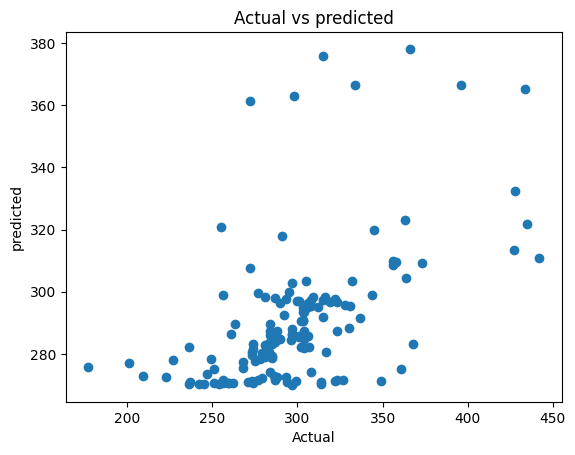

In [62]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test5, np.squeeze(model8.predict(X_test5)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test5, np.squeeze(model8.predict(X_test5)) )
mae= mean_absolute_error(Y_test5, np.squeeze(model8.predict(X_test5)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test5, np.squeeze(model8.predict(X_test5)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [63]:
prediction9 =np.squeeze(model8.predict([[80,2,2,prediction8]]))
print("Prediction: {}".format(prediction9))

y_prd=np.squeeze(np.squeeze(model8.predict(X_test5)) )
predic_dif=pd.DataFrame({'Actual':Y_test5,'predict':y_prd,"differences":Y_test5  -y_prd})
predic_dif[0:15]

1/1 [==============================] - 1s 658ms/step
Prediction: 282.46197509765625
5/5 [==============================] - 0s 4ms/step


,Actual,predict,differences
376,337,291.663177,45.336823
278,290,296.245941,-6.245941
61,298,362.806824,-64.806824
1154,299,271.224152,27.775848
648,283,280.501770,2.498230
1027,304,281.999054,22.000946
482,308,297.482788,10.517212
1491,259,270.571198,-11.571198
539,308,295.406372,12.593628
326,302,290.755310,11.244690


## keras tuner with dense and keras tuner with RNN

In [64]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [65]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train,Y_train ,epochs=100,validation_data=(X_test,Y_test))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model9 = tuner.hypermodel.build(best_hps)

model9.fit(X_train, Y_train, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
25/25 [==============================] - 1s 8ms/step - loss: 150.4767 - mean_absolute_error: 150.4767 - val_loss: 103.5662 - val_mean_absolute_error: 103.5662
Epoch 2/2000
25/25 [==============================] - 0s 3ms/step - loss: 101.5449 - mean_absolute_error: 101.5449 - val_loss: 96.1467 - val_mean_absolute_error: 96.1467
Epoch 3/2000
25/25 [==============================] - 0s 4ms/step - loss: 93.0780 - mean_absolute_error: 93.0780 - val_loss: 86.4858 - val_mean_absolute_error: 86.4858
Epoch 4/2000
25/25 [==============================] - 0s 3ms/step - loss: 81.7540 - mean_absolute_error: 81.7540 - val_loss: 75.1499 - val_mean_absolute_error: 75.1499
Epoch 5/2000
25/25 [==============================] - 0s 3ms/step - loss: 72.0576 - mean_absolute_error: 72.0576 - val_loss: 68.2293 - val_mean_

25/25 [==============================] - 0s 3ms/step - loss: 25.2719 - mean_absolute_error: 25.2719 - val_loss: 30.2689 - val_mean_absolute_error: 30.2689
Epoch 97/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.3916 - mean_absolute_error: 24.3916 - val_loss: 30.1976 - val_mean_absolute_error: 30.1976
Epoch 98/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.3690 - mean_absolute_error: 23.3690 - val_loss: 29.1354 - val_mean_absolute_error: 29.1354
Epoch 99/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.1328 - mean_absolute_error: 24.1328 - val_loss: 30.1563 - val_mean_absolute_error: 30.1563
Epoch 100/2000
25/25 [==============================] - 0s 3ms/step - loss: 25.0837 - mean_absolute_error: 25.0837 - val_loss: 31.1702 - val_mean_absolute_error: 31.1702
Epoch 101/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.1821 - mean_absolute_error: 24.1821 - val_loss: 29.8875 - val_mean_absolute_error: 29.887

25/25 [==============================] - 0s 3ms/step - loss: 23.2123 - mean_absolute_error: 23.2123 - val_loss: 28.5810 - val_mean_absolute_error: 28.5810
Epoch 193/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9590 - mean_absolute_error: 22.9590 - val_loss: 28.5600 - val_mean_absolute_error: 28.5600
Epoch 194/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.2593 - mean_absolute_error: 24.2593 - val_loss: 28.7390 - val_mean_absolute_error: 28.7390
Epoch 195/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1909 - mean_absolute_error: 23.1909 - val_loss: 29.5716 - val_mean_absolute_error: 29.5716
Epoch 196/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.8905 - mean_absolute_error: 24.8905 - val_loss: 28.5923 - val_mean_absolute_error: 28.5923
Epoch 197/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.6309 - mean_absolute_error: 23.6309 - val_loss: 30.5983 - val_mean_absolute_error: 30.

25/25 [==============================] - 0s 3ms/step - loss: 22.9034 - mean_absolute_error: 22.9034 - val_loss: 28.8401 - val_mean_absolute_error: 28.8401
Epoch 289/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1200 - mean_absolute_error: 23.1200 - val_loss: 30.0737 - val_mean_absolute_error: 30.0737
Epoch 290/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.8752 - mean_absolute_error: 23.8752 - val_loss: 31.1758 - val_mean_absolute_error: 31.1758
Epoch 291/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.4600 - mean_absolute_error: 24.4600 - val_loss: 29.9506 - val_mean_absolute_error: 29.9506
Epoch 292/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.9911 - mean_absolute_error: 24.9911 - val_loss: 32.4006 - val_mean_absolute_error: 32.4006
Epoch 293/2000
25/25 [==============================] - 0s 3ms/step - loss: 27.8324 - mean_absolute_error: 27.8324 - val_loss: 32.8696 - val_mean_absolute_error: 32.

25/25 [==============================] - 0s 3ms/step - loss: 23.3037 - mean_absolute_error: 23.3037 - val_loss: 34.1407 - val_mean_absolute_error: 34.1407
Epoch 385/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.0582 - mean_absolute_error: 24.0582 - val_loss: 28.4717 - val_mean_absolute_error: 28.4717
Epoch 386/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.5440 - mean_absolute_error: 23.5440 - val_loss: 28.6105 - val_mean_absolute_error: 28.6105
Epoch 387/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9227 - mean_absolute_error: 22.9227 - val_loss: 28.4510 - val_mean_absolute_error: 28.4510
Epoch 388/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.6372 - mean_absolute_error: 23.6372 - val_loss: 28.7525 - val_mean_absolute_error: 28.7525
Epoch 389/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.4650 - mean_absolute_error: 23.4650 - val_loss: 33.0690 - val_mean_absolute_error: 33.

25/25 [==============================] - 0s 3ms/step - loss: 22.7257 - mean_absolute_error: 22.7257 - val_loss: 29.0883 - val_mean_absolute_error: 29.0883
Epoch 481/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.9595 - mean_absolute_error: 23.9595 - val_loss: 32.6731 - val_mean_absolute_error: 32.6731
Epoch 482/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.7898 - mean_absolute_error: 23.7898 - val_loss: 29.4281 - val_mean_absolute_error: 29.4281
Epoch 483/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.5329 - mean_absolute_error: 22.5329 - val_loss: 30.5667 - val_mean_absolute_error: 30.5667
Epoch 484/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.4351 - mean_absolute_error: 23.4351 - val_loss: 28.9814 - val_mean_absolute_error: 28.9814
Epoch 485/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.7713 - mean_absolute_error: 23.7713 - val_loss: 30.5804 - val_mean_absolute_error: 30.

25/25 [==============================] - 0s 3ms/step - loss: 22.7841 - mean_absolute_error: 22.7841 - val_loss: 28.4380 - val_mean_absolute_error: 28.4380
Epoch 577/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.2754 - mean_absolute_error: 23.2754 - val_loss: 28.4266 - val_mean_absolute_error: 28.4266
Epoch 578/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9786 - mean_absolute_error: 22.9786 - val_loss: 28.9344 - val_mean_absolute_error: 28.9344
Epoch 579/2000
25/25 [==============================] - 0s 3ms/step - loss: 26.0769 - mean_absolute_error: 26.0769 - val_loss: 28.7921 - val_mean_absolute_error: 28.7921
Epoch 580/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1253 - mean_absolute_error: 23.1253 - val_loss: 29.1552 - val_mean_absolute_error: 29.1552
Epoch 581/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.2876 - mean_absolute_error: 23.2876 - val_loss: 32.4296 - val_mean_absolute_error: 32.

25/25 [==============================] - 0s 3ms/step - loss: 22.9230 - mean_absolute_error: 22.9230 - val_loss: 29.0933 - val_mean_absolute_error: 29.0933
Epoch 673/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.8048 - mean_absolute_error: 22.8048 - val_loss: 28.4859 - val_mean_absolute_error: 28.4859
Epoch 674/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.0323 - mean_absolute_error: 23.0323 - val_loss: 32.0704 - val_mean_absolute_error: 32.0704
Epoch 675/2000
25/25 [==============================] - 0s 3ms/step - loss: 25.7592 - mean_absolute_error: 25.7592 - val_loss: 28.7327 - val_mean_absolute_error: 28.7327
Epoch 676/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.8474 - mean_absolute_error: 22.8474 - val_loss: 28.9792 - val_mean_absolute_error: 28.9792
Epoch 677/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.0534 - mean_absolute_error: 24.0534 - val_loss: 29.2918 - val_mean_absolute_error: 29.

25/25 [==============================] - 0s 3ms/step - loss: 23.6782 - mean_absolute_error: 23.6782 - val_loss: 32.0192 - val_mean_absolute_error: 32.0192
Epoch 769/2000
25/25 [==============================] - 0s 3ms/step - loss: 25.0208 - mean_absolute_error: 25.0208 - val_loss: 30.0855 - val_mean_absolute_error: 30.0855
Epoch 770/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.4421 - mean_absolute_error: 23.4421 - val_loss: 28.7493 - val_mean_absolute_error: 28.7493
Epoch 771/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1872 - mean_absolute_error: 23.1872 - val_loss: 30.4265 - val_mean_absolute_error: 30.4265
Epoch 772/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.6522 - mean_absolute_error: 23.6522 - val_loss: 31.2238 - val_mean_absolute_error: 31.2238
Epoch 773/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.2711 - mean_absolute_error: 23.2711 - val_loss: 29.0802 - val_mean_absolute_error: 29.

25/25 [==============================] - 0s 3ms/step - loss: 23.4492 - mean_absolute_error: 23.4492 - val_loss: 28.6012 - val_mean_absolute_error: 28.6012
Epoch 865/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.3578 - mean_absolute_error: 23.3578 - val_loss: 28.8058 - val_mean_absolute_error: 28.8058
Epoch 866/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9365 - mean_absolute_error: 22.9365 - val_loss: 30.8899 - val_mean_absolute_error: 30.8899
Epoch 867/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9404 - mean_absolute_error: 22.9404 - val_loss: 30.0810 - val_mean_absolute_error: 30.0810
Epoch 868/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.8688 - mean_absolute_error: 22.8688 - val_loss: 29.2360 - val_mean_absolute_error: 29.2360
Epoch 869/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.4480 - mean_absolute_error: 23.4480 - val_loss: 28.7236 - val_mean_absolute_error: 28.

25/25 [==============================] - 0s 3ms/step - loss: 22.4250 - mean_absolute_error: 22.4250 - val_loss: 29.4912 - val_mean_absolute_error: 29.4912
Epoch 961/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.2455 - mean_absolute_error: 22.2455 - val_loss: 28.3108 - val_mean_absolute_error: 28.3108
Epoch 962/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6597 - mean_absolute_error: 22.6597 - val_loss: 28.7705 - val_mean_absolute_error: 28.7705
Epoch 963/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9865 - mean_absolute_error: 22.9865 - val_loss: 30.0023 - val_mean_absolute_error: 30.0023
Epoch 964/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6837 - mean_absolute_error: 22.6837 - val_loss: 28.5125 - val_mean_absolute_error: 28.5125
Epoch 965/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4378 - mean_absolute_error: 22.4378 - val_loss: 28.3314 - val_mean_absolute_error: 28.

25/25 [==============================] - 0s 3ms/step - loss: 22.5313 - mean_absolute_error: 22.5313 - val_loss: 28.8678 - val_mean_absolute_error: 28.8678
Epoch 1057/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.7112 - mean_absolute_error: 23.7112 - val_loss: 30.3161 - val_mean_absolute_error: 30.3161
Epoch 1058/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.3619 - mean_absolute_error: 23.3619 - val_loss: 28.3226 - val_mean_absolute_error: 28.3226
Epoch 1059/2000
25/25 [==============================] - 0s 4ms/step - loss: 22.3711 - mean_absolute_error: 22.3711 - val_loss: 29.0936 - val_mean_absolute_error: 29.0936
Epoch 1060/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.8620 - mean_absolute_error: 22.8620 - val_loss: 29.4131 - val_mean_absolute_error: 29.4131
Epoch 1061/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.1775 - mean_absolute_error: 24.1775 - val_loss: 28.9342 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.2219 - mean_absolute_error: 22.2219 - val_loss: 28.4119 - val_mean_absolute_error: 28.4119
Epoch 1105/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.0244 - mean_absolute_error: 24.0244 - val_loss: 30.8546 - val_mean_absolute_error: 30.8546
Epoch 1106/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1245 - mean_absolute_error: 23.1245 - val_loss: 28.5441 - val_mean_absolute_error: 28.5441
Epoch 1107/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1586 - mean_absolute_error: 22.1586 - val_loss: 30.1731 - val_mean_absolute_error: 30.1731
Epoch 1108/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.7075 - mean_absolute_error: 22.7075 - val_loss: 28.7127 - val_mean_absolute_error: 28.7127
Epoch 1109/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6774 - mean_absolute_error: 22.6774 - val_loss: 29.4607 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 23.1911 - mean_absolute_error: 23.1911 - val_loss: 28.8613 - val_mean_absolute_error: 28.8613
Epoch 1153/2000
25/25 [==============================] - 0s 4ms/step - loss: 22.2440 - mean_absolute_error: 22.2440 - val_loss: 29.3200 - val_mean_absolute_error: 29.3200
Epoch 1154/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.4652 - mean_absolute_error: 23.4652 - val_loss: 30.0643 - val_mean_absolute_error: 30.0643
Epoch 1155/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6727 - mean_absolute_error: 22.6727 - val_loss: 29.1098 - val_mean_absolute_error: 29.1098
Epoch 1156/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.5770 - mean_absolute_error: 22.5770 - val_loss: 28.6266 - val_mean_absolute_error: 28.6266
Epoch 1157/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4091 - mean_absolute_error: 22.4091 - val_loss: 28.2177 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 23.3672 - mean_absolute_error: 23.3672 - val_loss: 29.9083 - val_mean_absolute_error: 29.9083
Epoch 1201/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6305 - mean_absolute_error: 22.6305 - val_loss: 29.8365 - val_mean_absolute_error: 29.8365
Epoch 1202/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9590 - mean_absolute_error: 22.9590 - val_loss: 29.3764 - val_mean_absolute_error: 29.3764
Epoch 1203/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9803 - mean_absolute_error: 21.9803 - val_loss: 28.4297 - val_mean_absolute_error: 28.4297
Epoch 1204/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1999 - mean_absolute_error: 22.1999 - val_loss: 28.8070 - val_mean_absolute_error: 28.8070
Epoch 1205/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.0936 - mean_absolute_error: 23.0936 - val_loss: 29.3784 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.8547 - mean_absolute_error: 22.8547 - val_loss: 29.5922 - val_mean_absolute_error: 29.5922
Epoch 1249/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8331 - mean_absolute_error: 21.8331 - val_loss: 29.5019 - val_mean_absolute_error: 29.5019
Epoch 1250/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0158 - mean_absolute_error: 22.0158 - val_loss: 29.6474 - val_mean_absolute_error: 29.6474
Epoch 1251/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6809 - mean_absolute_error: 22.6809 - val_loss: 28.2410 - val_mean_absolute_error: 28.2410
Epoch 1252/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.7492 - mean_absolute_error: 23.7492 - val_loss: 28.9444 - val_mean_absolute_error: 28.9444
Epoch 1253/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.5089 - mean_absolute_error: 22.5089 - val_loss: 28.2418 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 23.1162 - mean_absolute_error: 23.1162 - val_loss: 29.1915 - val_mean_absolute_error: 29.1915
Epoch 1297/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.3000 - mean_absolute_error: 23.3000 - val_loss: 29.6760 - val_mean_absolute_error: 29.6760
Epoch 1298/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.5282 - mean_absolute_error: 22.5282 - val_loss: 28.9510 - val_mean_absolute_error: 28.9510
Epoch 1299/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.5489 - mean_absolute_error: 24.5489 - val_loss: 29.5702 - val_mean_absolute_error: 29.5702
Epoch 1300/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0180 - mean_absolute_error: 22.0180 - val_loss: 28.6413 - val_mean_absolute_error: 28.6413
Epoch 1301/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.2600 - mean_absolute_error: 22.2600 - val_loss: 28.9801 - val_mean_absolute_error

25/25 [==============================] - 0s 4ms/step - loss: 22.2612 - mean_absolute_error: 22.2612 - val_loss: 28.3062 - val_mean_absolute_error: 28.3062
Epoch 1345/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1781 - mean_absolute_error: 22.1781 - val_loss: 28.9934 - val_mean_absolute_error: 28.9934
Epoch 1346/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4784 - mean_absolute_error: 22.4784 - val_loss: 28.1487 - val_mean_absolute_error: 28.1487
Epoch 1347/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4099 - mean_absolute_error: 22.4099 - val_loss: 29.1300 - val_mean_absolute_error: 29.1300
Epoch 1348/2000
25/25 [==============================] - 0s 3ms/step - loss: 24.6833 - mean_absolute_error: 24.6833 - val_loss: 30.2700 - val_mean_absolute_error: 30.2700
Epoch 1349/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.2221 - mean_absolute_error: 22.2221 - val_loss: 27.8646 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.5663 - mean_absolute_error: 22.5663 - val_loss: 28.3624 - val_mean_absolute_error: 28.3624
Epoch 1393/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9181 - mean_absolute_error: 21.9181 - val_loss: 27.9681 - val_mean_absolute_error: 27.9681
Epoch 1394/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9759 - mean_absolute_error: 21.9759 - val_loss: 28.4050 - val_mean_absolute_error: 28.4050
Epoch 1395/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9620 - mean_absolute_error: 21.9620 - val_loss: 29.7768 - val_mean_absolute_error: 29.7768
Epoch 1396/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.3570 - mean_absolute_error: 22.3570 - val_loss: 28.3982 - val_mean_absolute_error: 28.3982
Epoch 1397/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6190 - mean_absolute_error: 22.6190 - val_loss: 29.8167 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.2157 - mean_absolute_error: 22.2157 - val_loss: 28.0577 - val_mean_absolute_error: 28.0577
Epoch 1441/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9092 - mean_absolute_error: 21.9092 - val_loss: 29.4242 - val_mean_absolute_error: 29.4242
Epoch 1442/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7715 - mean_absolute_error: 21.7715 - val_loss: 28.3566 - val_mean_absolute_error: 28.3566
Epoch 1443/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0134 - mean_absolute_error: 22.0134 - val_loss: 28.3143 - val_mean_absolute_error: 28.3143
Epoch 1444/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1320 - mean_absolute_error: 22.1320 - val_loss: 28.2613 - val_mean_absolute_error: 28.2613
Epoch 1445/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4877 - mean_absolute_error: 22.4877 - val_loss: 28.2449 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 23.0797 - mean_absolute_error: 23.0797 - val_loss: 28.8639 - val_mean_absolute_error: 28.8639
Epoch 1489/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6993 - mean_absolute_error: 22.6993 - val_loss: 28.8688 - val_mean_absolute_error: 28.8688
Epoch 1490/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.3963 - mean_absolute_error: 22.3963 - val_loss: 28.5321 - val_mean_absolute_error: 28.5321
Epoch 1491/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1560 - mean_absolute_error: 22.1560 - val_loss: 27.9179 - val_mean_absolute_error: 27.9179
Epoch 1492/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.6994 - mean_absolute_error: 21.6994 - val_loss: 28.7110 - val_mean_absolute_error: 28.7110
Epoch 1493/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9356 - mean_absolute_error: 21.9356 - val_loss: 28.0799 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.6928 - mean_absolute_error: 22.6928 - val_loss: 32.6148 - val_mean_absolute_error: 32.6148
Epoch 1537/2000
25/25 [==============================] - 0s 4ms/step - loss: 23.1508 - mean_absolute_error: 23.1508 - val_loss: 28.0569 - val_mean_absolute_error: 28.0569
Epoch 1538/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0374 - mean_absolute_error: 22.0374 - val_loss: 27.9976 - val_mean_absolute_error: 27.9976
Epoch 1539/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.8144 - mean_absolute_error: 22.8144 - val_loss: 29.0734 - val_mean_absolute_error: 29.0734
Epoch 1540/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7000 - mean_absolute_error: 21.7000 - val_loss: 28.3859 - val_mean_absolute_error: 28.3859
Epoch 1541/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9177 - mean_absolute_error: 21.9177 - val_loss: 28.0664 - val_mean_absolute_error

25/25 [==============================] - 0s 4ms/step - loss: 22.6945 - mean_absolute_error: 22.6945 - val_loss: 28.0830 - val_mean_absolute_error: 28.0830
Epoch 1585/2000
25/25 [==============================] - 0s 4ms/step - loss: 21.8650 - mean_absolute_error: 21.8650 - val_loss: 28.0732 - val_mean_absolute_error: 28.0732
Epoch 1586/2000
25/25 [==============================] - 0s 4ms/step - loss: 22.4796 - mean_absolute_error: 22.4796 - val_loss: 29.0065 - val_mean_absolute_error: 29.0065
Epoch 1587/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0457 - mean_absolute_error: 22.0457 - val_loss: 28.6239 - val_mean_absolute_error: 28.6239
Epoch 1588/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.0821 - mean_absolute_error: 22.0821 - val_loss: 29.0905 - val_mean_absolute_error: 29.0905
Epoch 1589/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6271 - mean_absolute_error: 22.6271 - val_loss: 28.8151 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 21.7366 - mean_absolute_error: 21.7366 - val_loss: 29.4961 - val_mean_absolute_error: 29.4961
Epoch 1633/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4017 - mean_absolute_error: 22.4017 - val_loss: 27.9307 - val_mean_absolute_error: 27.9307
Epoch 1634/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.6790 - mean_absolute_error: 21.6790 - val_loss: 28.0317 - val_mean_absolute_error: 28.0317
Epoch 1635/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6264 - mean_absolute_error: 22.6264 - val_loss: 28.8020 - val_mean_absolute_error: 28.8020
Epoch 1636/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9257 - mean_absolute_error: 22.9257 - val_loss: 29.4090 - val_mean_absolute_error: 29.4090
Epoch 1637/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.7407 - mean_absolute_error: 22.7407 - val_loss: 27.9116 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 21.9242 - mean_absolute_error: 21.9242 - val_loss: 28.4423 - val_mean_absolute_error: 28.4423
Epoch 1681/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8317 - mean_absolute_error: 21.8317 - val_loss: 28.4783 - val_mean_absolute_error: 28.4783
Epoch 1682/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8870 - mean_absolute_error: 21.8870 - val_loss: 28.2318 - val_mean_absolute_error: 28.2318
Epoch 1683/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.3688 - mean_absolute_error: 22.3688 - val_loss: 28.6410 - val_mean_absolute_error: 28.6410
Epoch 1684/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.9845 - mean_absolute_error: 22.9845 - val_loss: 29.8489 - val_mean_absolute_error: 29.8489
Epoch 1685/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.2359 - mean_absolute_error: 22.2359 - val_loss: 28.3033 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.0992 - mean_absolute_error: 22.0992 - val_loss: 28.6941 - val_mean_absolute_error: 28.6941
Epoch 1729/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.5043 - mean_absolute_error: 22.5043 - val_loss: 28.6530 - val_mean_absolute_error: 28.6530
Epoch 1730/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9465 - mean_absolute_error: 21.9465 - val_loss: 28.1447 - val_mean_absolute_error: 28.1447
Epoch 1731/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9063 - mean_absolute_error: 21.9063 - val_loss: 28.2571 - val_mean_absolute_error: 28.2571
Epoch 1732/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9537 - mean_absolute_error: 21.9537 - val_loss: 28.2320 - val_mean_absolute_error: 28.2320
Epoch 1733/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8043 - mean_absolute_error: 21.8043 - val_loss: 29.6144 - val_mean_absolute_error

25/25 [==============================] - 0s 4ms/step - loss: 22.1463 - mean_absolute_error: 22.1463 - val_loss: 28.4915 - val_mean_absolute_error: 28.4915
Epoch 1777/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7344 - mean_absolute_error: 21.7344 - val_loss: 28.8312 - val_mean_absolute_error: 28.8312
Epoch 1778/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9503 - mean_absolute_error: 21.9503 - val_loss: 28.1343 - val_mean_absolute_error: 28.1343
Epoch 1779/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1193 - mean_absolute_error: 22.1193 - val_loss: 28.1337 - val_mean_absolute_error: 28.1337
Epoch 1780/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8800 - mean_absolute_error: 21.8800 - val_loss: 28.2639 - val_mean_absolute_error: 28.2639
Epoch 1781/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.6656 - mean_absolute_error: 22.6656 - val_loss: 28.6851 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.1623 - mean_absolute_error: 22.1623 - val_loss: 28.0450 - val_mean_absolute_error: 28.0450
Epoch 1825/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9779 - mean_absolute_error: 21.9779 - val_loss: 27.8917 - val_mean_absolute_error: 27.8917
Epoch 1826/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7623 - mean_absolute_error: 21.7623 - val_loss: 29.0441 - val_mean_absolute_error: 29.0441
Epoch 1827/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1315 - mean_absolute_error: 22.1315 - val_loss: 28.8408 - val_mean_absolute_error: 28.8408
Epoch 1828/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7804 - mean_absolute_error: 21.7804 - val_loss: 28.8205 - val_mean_absolute_error: 28.8205
Epoch 1829/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.6873 - mean_absolute_error: 21.6873 - val_loss: 28.0842 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 21.8982 - mean_absolute_error: 21.8982 - val_loss: 29.3618 - val_mean_absolute_error: 29.3618
Epoch 1873/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1679 - mean_absolute_error: 22.1679 - val_loss: 28.2659 - val_mean_absolute_error: 28.2659
Epoch 1874/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.5841 - mean_absolute_error: 21.5841 - val_loss: 28.3153 - val_mean_absolute_error: 28.3153
Epoch 1875/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8810 - mean_absolute_error: 21.8810 - val_loss: 29.2054 - val_mean_absolute_error: 29.2054
Epoch 1876/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.3223 - mean_absolute_error: 23.3223 - val_loss: 30.2573 - val_mean_absolute_error: 30.2573
Epoch 1877/2000
25/25 [==============================] - 0s 3ms/step - loss: 23.1225 - mean_absolute_error: 23.1225 - val_loss: 28.9843 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.3139 - mean_absolute_error: 22.3139 - val_loss: 29.6522 - val_mean_absolute_error: 29.6522
Epoch 1921/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.7302 - mean_absolute_error: 21.7302 - val_loss: 28.2551 - val_mean_absolute_error: 28.2551
Epoch 1922/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4141 - mean_absolute_error: 22.4141 - val_loss: 28.7067 - val_mean_absolute_error: 28.7067
Epoch 1923/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1003 - mean_absolute_error: 22.1003 - val_loss: 28.3538 - val_mean_absolute_error: 28.3538
Epoch 1924/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8242 - mean_absolute_error: 21.8242 - val_loss: 27.8734 - val_mean_absolute_error: 27.8734
Epoch 1925/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.4085 - mean_absolute_error: 22.4085 - val_loss: 27.9499 - val_mean_absolute_error

25/25 [==============================] - 0s 3ms/step - loss: 22.1232 - mean_absolute_error: 22.1232 - val_loss: 28.6206 - val_mean_absolute_error: 28.6206
Epoch 1969/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.7251 - mean_absolute_error: 22.7251 - val_loss: 28.4040 - val_mean_absolute_error: 28.4040
Epoch 1970/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.8699 - mean_absolute_error: 21.8699 - val_loss: 28.2183 - val_mean_absolute_error: 28.2183
Epoch 1971/2000
25/25 [==============================] - 0s 3ms/step - loss: 21.9208 - mean_absolute_error: 21.9208 - val_loss: 27.8726 - val_mean_absolute_error: 27.8726
Epoch 1972/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.1263 - mean_absolute_error: 22.1263 - val_loss: 28.9969 - val_mean_absolute_error: 28.9969
Epoch 1973/2000
25/25 [==============================] - 0s 3ms/step - loss: 22.2413 - mean_absolute_error: 22.2413 - val_loss: 28.3593 - val_mean_absolute_error

In [66]:
prediction10 = np.squeeze(model9.predict([[80,2,2]]))
print("Prediction: {}".format(prediction10))

1/1 [==============================] - 0s 58ms/step
Prediction: 296.60009765625


In [67]:
y_prd=np.squeeze(np.squeeze(model9.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

16/16 [==============================] - 0s 1ms/step
      Actual     predict  differences
443      287  302.640686   -15.640686
319      317  313.415161     3.584839
703      295  300.883911    -5.883911
526      320  321.392944    -1.392944
76       435  349.997498    85.002502
...      ...         ...          ...
1232     287  309.768158   -22.768158
330      296  308.119659   -12.119659
1087     274  286.114990   -12.114990
789      321  319.719177     1.280823
1618     314  279.343140    34.656860

[488 rows x 3 columns]


In [69]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

122.6339111328125
-138.44207763671875
167.64419555664062
165.31903076171875
-151.06549072265625
148.004150390625
147.6937255859375
118.93109130859375
131.5540771484375
-129.434326171875
-127.30905151367188
117.79574584960938
170.12973022460938
128.99371337890625
lower bound: -125.7732278744883
upper bound: 109.50895040066337


In [70]:
A.drop(A[(A['differences'] >109)].index, inplace=True)
A.drop(A[(A['differences'] <-125)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X6=B.drop('Actual',axis=1)
Y6=B['Actual']
X_train6, X_test6, Y_train6, Y_test6 =train_test_split(X6,Y6, test_size=0.3, random_state = 0)

      AverageFloorArea  Year/Quarter  Property Type  Actual     predict
2                   19             1              4     375  402.065369
4                   20             1              2     366  395.183167
5                   20             4              1     485  468.004364
9                   23             2              5     408  483.899139
14                  25             2              1     358  426.237549
...                ...           ...            ...     ...         ...
1616               155             2              3     242  290.343597
1618               155             4              3     314  279.343140
1619               156             1              3     275  298.692749
1622               156             3              4     289  289.101959
1625               157             4              3     254  279.017914

[474 rows x 5 columns]


In [71]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train6.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [72]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train6,Y_train6 ,epochs=100,validation_data=(X_test6,Y_test6))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model10 = tuner.hypermodel.build(best_hps)

model10.fit(X_train6, Y_train6, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
8/8 [==============================] - 2s 55ms/step - loss: 135.4347 - mean_absolute_error: 135.4347 - val_loss: 51.3956 - val_mean_absolute_error: 51.3956
Epoch 2/2000
8/8 [==============================] - 0s 24ms/step - loss: 40.7221 - mean_absolute_error: 40.7221 - val_loss: 28.1341 - val_mean_absolute_error: 28.1341
Epoch 3/2000
8/8 [==============================] - 0s 24ms/step - loss: 26.1794 - mean_absolute_error: 26.1794 - val_loss: 20.5752 - val_mean_absolute_error: 20.5752
Epoch 4/2000
8/8 [==============================] - 0s 24ms/step - loss: 24.1604 - mean_absolute_error: 24.1604 - val_loss: 19.8197 - val_mean_absolute_error: 19.8197
Epoch 5/2000
8/8 [==============================] - 0s 27ms/step - loss: 21.5286 - mean_absolute_error: 21.5286 - val_loss: 20.7150 - val_mean_absolute_

Epoch 49/2000
8/8 [==============================] - 0s 24ms/step - loss: 27.3195 - mean_absolute_error: 27.3195 - val_loss: 23.7680 - val_mean_absolute_error: 23.7680
Epoch 50/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.0726 - mean_absolute_error: 23.0726 - val_loss: 29.1585 - val_mean_absolute_error: 29.1585
Epoch 51/2000
8/8 [==============================] - 0s 23ms/step - loss: 24.0222 - mean_absolute_error: 24.0222 - val_loss: 21.5504 - val_mean_absolute_error: 21.5504
Epoch 52/2000
8/8 [==============================] - 0s 22ms/step - loss: 21.4350 - mean_absolute_error: 21.4350 - val_loss: 21.1482 - val_mean_absolute_error: 21.1482
Epoch 53/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.5452 - mean_absolute_error: 23.5452 - val_loss: 21.0306 - val_mean_absolute_error: 21.0306
Epoch 54/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.9593 - mean_absolute_error: 22.9593 - val_loss: 21.9890 - val_mean_absolute_error: 

Epoch 98/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.4407 - mean_absolute_error: 20.4407 - val_loss: 21.1991 - val_mean_absolute_error: 21.1991
Epoch 99/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.3109 - mean_absolute_error: 21.3109 - val_loss: 24.7489 - val_mean_absolute_error: 24.7489
Epoch 100/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.9991 - mean_absolute_error: 21.9991 - val_loss: 21.8515 - val_mean_absolute_error: 21.8515
Epoch 101/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.5385 - mean_absolute_error: 20.5385 - val_loss: 26.7570 - val_mean_absolute_error: 26.7570
Epoch 102/2000
8/8 [==============================] - 0s 23ms/step - loss: 23.0563 - mean_absolute_error: 23.0563 - val_loss: 23.3673 - val_mean_absolute_error: 23.3673
Epoch 103/2000
8/8 [==============================] - 0s 23ms/step - loss: 25.4674 - mean_absolute_error: 25.4674 - val_loss: 20.7781 - val_mean_absolute_err

8/8 [==============================] - 0s 25ms/step - loss: 25.2048 - mean_absolute_error: 25.2048 - val_loss: 21.0658 - val_mean_absolute_error: 21.0658
Epoch 195/2000
8/8 [==============================] - 0s 26ms/step - loss: 23.0392 - mean_absolute_error: 23.0392 - val_loss: 20.6912 - val_mean_absolute_error: 20.6912
Epoch 196/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.9520 - mean_absolute_error: 20.9520 - val_loss: 22.0871 - val_mean_absolute_error: 22.0871
Epoch 197/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.4936 - mean_absolute_error: 21.4936 - val_loss: 31.1173 - val_mean_absolute_error: 31.1173
Epoch 198/2000
8/8 [==============================] - 0s 24ms/step - loss: 23.5664 - mean_absolute_error: 23.5664 - val_loss: 24.9482 - val_mean_absolute_error: 24.9482
Epoch 199/2000
8/8 [==============================] - 0s 27ms/step - loss: 23.5465 - mean_absolute_error: 23.5465 - val_loss: 20.1840 - val_mean_absolute_error: 20.1840
E

8/8 [==============================] - 0s 25ms/step - loss: 22.8072 - mean_absolute_error: 22.8072 - val_loss: 20.0972 - val_mean_absolute_error: 20.0972
Epoch 291/2000
8/8 [==============================] - 0s 24ms/step - loss: 22.4717 - mean_absolute_error: 22.4717 - val_loss: 20.3560 - val_mean_absolute_error: 20.3560
Epoch 292/2000
8/8 [==============================] - 0s 25ms/step - loss: 22.3239 - mean_absolute_error: 22.3239 - val_loss: 20.1087 - val_mean_absolute_error: 20.1087
Epoch 293/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.0993 - mean_absolute_error: 21.0993 - val_loss: 20.2900 - val_mean_absolute_error: 20.2900
Epoch 294/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.6292 - mean_absolute_error: 20.6292 - val_loss: 20.3180 - val_mean_absolute_error: 20.3180
Epoch 295/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.9630 - mean_absolute_error: 20.9630 - val_loss: 20.1898 - val_mean_absolute_error: 20.1898
E

8/8 [==============================] - 0s 25ms/step - loss: 20.8690 - mean_absolute_error: 20.8690 - val_loss: 23.0655 - val_mean_absolute_error: 23.0655
Epoch 387/2000
8/8 [==============================] - 0s 25ms/step - loss: 21.0949 - mean_absolute_error: 21.0949 - val_loss: 20.7906 - val_mean_absolute_error: 20.7906
Epoch 388/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.7609 - mean_absolute_error: 20.7609 - val_loss: 21.0958 - val_mean_absolute_error: 21.0958
Epoch 389/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.9011 - mean_absolute_error: 20.9011 - val_loss: 21.9570 - val_mean_absolute_error: 21.9570
Epoch 390/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.9818 - mean_absolute_error: 20.9818 - val_loss: 22.0819 - val_mean_absolute_error: 22.0819
Epoch 391/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.7058 - mean_absolute_error: 20.7058 - val_loss: 23.1998 - val_mean_absolute_error: 23.1998
E

8/8 [==============================] - 0s 25ms/step - loss: 20.6234 - mean_absolute_error: 20.6234 - val_loss: 21.7130 - val_mean_absolute_error: 21.7130
Epoch 483/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.6951 - mean_absolute_error: 20.6951 - val_loss: 20.3632 - val_mean_absolute_error: 20.3632
Epoch 484/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.5035 - mean_absolute_error: 20.5035 - val_loss: 20.1564 - val_mean_absolute_error: 20.1564
Epoch 485/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.6456 - mean_absolute_error: 20.6456 - val_loss: 21.1033 - val_mean_absolute_error: 21.1033
Epoch 486/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.5871 - mean_absolute_error: 20.5871 - val_loss: 20.5687 - val_mean_absolute_error: 20.5687
Epoch 487/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.1562 - mean_absolute_error: 21.1562 - val_loss: 20.4539 - val_mean_absolute_error: 20.4539
E

8/8 [==============================] - 0s 24ms/step - loss: 21.4477 - mean_absolute_error: 21.4477 - val_loss: 21.2217 - val_mean_absolute_error: 21.2217
Epoch 579/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6367 - mean_absolute_error: 20.6367 - val_loss: 20.7315 - val_mean_absolute_error: 20.7315
Epoch 580/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.8883 - mean_absolute_error: 20.8883 - val_loss: 20.3793 - val_mean_absolute_error: 20.3793
Epoch 581/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.9510 - mean_absolute_error: 20.9510 - val_loss: 20.3962 - val_mean_absolute_error: 20.3962
Epoch 582/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.7020 - mean_absolute_error: 21.7020 - val_loss: 21.6379 - val_mean_absolute_error: 21.6379
Epoch 583/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.1881 - mean_absolute_error: 21.1881 - val_loss: 21.2337 - val_mean_absolute_error: 21.2337
E

8/8 [==============================] - 0s 23ms/step - loss: 20.5174 - mean_absolute_error: 20.5174 - val_loss: 20.4098 - val_mean_absolute_error: 20.4098
Epoch 675/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.0823 - mean_absolute_error: 21.0823 - val_loss: 20.4306 - val_mean_absolute_error: 20.4306
Epoch 676/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.3886 - mean_absolute_error: 20.3886 - val_loss: 25.3016 - val_mean_absolute_error: 25.3016
Epoch 677/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.2481 - mean_absolute_error: 21.2481 - val_loss: 20.3608 - val_mean_absolute_error: 20.3608
Epoch 678/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6190 - mean_absolute_error: 20.6190 - val_loss: 20.5293 - val_mean_absolute_error: 20.5293
Epoch 679/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6184 - mean_absolute_error: 20.6184 - val_loss: 26.2463 - val_mean_absolute_error: 26.2463
E

8/8 [==============================] - 0s 24ms/step - loss: 21.1949 - mean_absolute_error: 21.1949 - val_loss: 21.7488 - val_mean_absolute_error: 21.7488
Epoch 771/2000
8/8 [==============================] - 0s 33ms/step - loss: 20.6300 - mean_absolute_error: 20.6300 - val_loss: 21.1750 - val_mean_absolute_error: 21.1750
Epoch 772/2000
8/8 [==============================] - 0s 29ms/step - loss: 22.0470 - mean_absolute_error: 22.0470 - val_loss: 21.5876 - val_mean_absolute_error: 21.5876
Epoch 773/2000
8/8 [==============================] - 0s 30ms/step - loss: 20.3294 - mean_absolute_error: 20.3294 - val_loss: 21.6891 - val_mean_absolute_error: 21.6891
Epoch 774/2000
8/8 [==============================] - 0s 31ms/step - loss: 20.1874 - mean_absolute_error: 20.1874 - val_loss: 20.7229 - val_mean_absolute_error: 20.7229
Epoch 775/2000
8/8 [==============================] - 0s 30ms/step - loss: 20.4102 - mean_absolute_error: 20.4102 - val_loss: 20.6387 - val_mean_absolute_error: 20.6387
E

8/8 [==============================] - 0s 25ms/step - loss: 20.1087 - mean_absolute_error: 20.1087 - val_loss: 21.4952 - val_mean_absolute_error: 21.4952
Epoch 867/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.0554 - mean_absolute_error: 20.0554 - val_loss: 20.5270 - val_mean_absolute_error: 20.5270
Epoch 868/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.0320 - mean_absolute_error: 20.0320 - val_loss: 23.2322 - val_mean_absolute_error: 23.2322
Epoch 869/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.4416 - mean_absolute_error: 20.4416 - val_loss: 20.5887 - val_mean_absolute_error: 20.5887
Epoch 870/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.7124 - mean_absolute_error: 20.7124 - val_loss: 20.5438 - val_mean_absolute_error: 20.5438
Epoch 871/2000
8/8 [==============================] - 0s 26ms/step - loss: 21.5685 - mean_absolute_error: 21.5685 - val_loss: 22.0405 - val_mean_absolute_error: 22.0405
E

8/8 [==============================] - 0s 23ms/step - loss: 21.6554 - mean_absolute_error: 21.6554 - val_loss: 22.8386 - val_mean_absolute_error: 22.8386
Epoch 963/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.3690 - mean_absolute_error: 20.3690 - val_loss: 20.5898 - val_mean_absolute_error: 20.5898
Epoch 964/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.0938 - mean_absolute_error: 20.0938 - val_loss: 21.4847 - val_mean_absolute_error: 21.4847
Epoch 965/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.5938 - mean_absolute_error: 20.5938 - val_loss: 21.2741 - val_mean_absolute_error: 21.2741
Epoch 966/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.7723 - mean_absolute_error: 21.7723 - val_loss: 27.7402 - val_mean_absolute_error: 27.7402
Epoch 967/2000
8/8 [==============================] - 0s 23ms/step - loss: 22.6487 - mean_absolute_error: 22.6487 - val_loss: 20.3508 - val_mean_absolute_error: 20.3508
E

8/8 [==============================] - 0s 25ms/step - loss: 20.1910 - mean_absolute_error: 20.1910 - val_loss: 22.1710 - val_mean_absolute_error: 22.1710
Epoch 1059/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.1289 - mean_absolute_error: 20.1289 - val_loss: 20.5376 - val_mean_absolute_error: 20.5376
Epoch 1060/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.2244 - mean_absolute_error: 20.2244 - val_loss: 22.2258 - val_mean_absolute_error: 22.2258
Epoch 1061/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.1808 - mean_absolute_error: 20.1808 - val_loss: 21.5658 - val_mean_absolute_error: 21.5658
Epoch 1062/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.7950 - mean_absolute_error: 20.7950 - val_loss: 20.5759 - val_mean_absolute_error: 20.5759
Epoch 1063/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.6285 - mean_absolute_error: 20.6285 - val_loss: 23.8935 - val_mean_absolute_error: 23.8

8/8 [==============================] - 0s 26ms/step - loss: 21.6111 - mean_absolute_error: 21.6111 - val_loss: 26.2906 - val_mean_absolute_error: 26.2906
Epoch 1155/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.4028 - mean_absolute_error: 20.4028 - val_loss: 20.3401 - val_mean_absolute_error: 20.3401
Epoch 1156/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.8226 - mean_absolute_error: 20.8226 - val_loss: 21.3597 - val_mean_absolute_error: 21.3597
Epoch 1157/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.0036 - mean_absolute_error: 20.0036 - val_loss: 21.0421 - val_mean_absolute_error: 21.0421
Epoch 1158/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.0549 - mean_absolute_error: 20.0549 - val_loss: 22.7552 - val_mean_absolute_error: 22.7552
Epoch 1159/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.6901 - mean_absolute_error: 20.6901 - val_loss: 20.8823 - val_mean_absolute_error: 20.8

8/8 [==============================] - 0s 25ms/step - loss: 20.0828 - mean_absolute_error: 20.0828 - val_loss: 20.9781 - val_mean_absolute_error: 20.9781
Epoch 1251/2000
8/8 [==============================] - 0s 25ms/step - loss: 19.8560 - mean_absolute_error: 19.8560 - val_loss: 21.8184 - val_mean_absolute_error: 21.8184
Epoch 1252/2000
8/8 [==============================] - 0s 33ms/step - loss: 20.2101 - mean_absolute_error: 20.2101 - val_loss: 20.5727 - val_mean_absolute_error: 20.5727
Epoch 1253/2000
8/8 [==============================] - 0s 31ms/step - loss: 19.9191 - mean_absolute_error: 19.9191 - val_loss: 24.7702 - val_mean_absolute_error: 24.7702
Epoch 1254/2000
8/8 [==============================] - 0s 30ms/step - loss: 20.7870 - mean_absolute_error: 20.7870 - val_loss: 23.4161 - val_mean_absolute_error: 23.4161
Epoch 1255/2000
8/8 [==============================] - 0s 30ms/step - loss: 20.3308 - mean_absolute_error: 20.3308 - val_loss: 20.6520 - val_mean_absolute_error: 20.6

8/8 [==============================] - 0s 25ms/step - loss: 21.2601 - mean_absolute_error: 21.2601 - val_loss: 23.7793 - val_mean_absolute_error: 23.7793
Epoch 1347/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.5185 - mean_absolute_error: 20.5185 - val_loss: 21.2057 - val_mean_absolute_error: 21.2057
Epoch 1348/2000
8/8 [==============================] - 0s 24ms/step - loss: 20.8213 - mean_absolute_error: 20.8213 - val_loss: 20.7221 - val_mean_absolute_error: 20.7221
Epoch 1349/2000
8/8 [==============================] - 0s 26ms/step - loss: 20.7702 - mean_absolute_error: 20.7702 - val_loss: 21.7928 - val_mean_absolute_error: 21.7928
Epoch 1350/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.1495 - mean_absolute_error: 20.1495 - val_loss: 23.7644 - val_mean_absolute_error: 23.7644
Epoch 1351/2000
8/8 [==============================] - 0s 25ms/step - loss: 20.2659 - mean_absolute_error: 20.2659 - val_loss: 20.6084 - val_mean_absolute_error: 20.6

8/8 [==============================] - 0s 24ms/step - loss: 20.1432 - mean_absolute_error: 20.1432 - val_loss: 21.4147 - val_mean_absolute_error: 21.4147
Epoch 1443/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.7555 - mean_absolute_error: 19.7555 - val_loss: 20.9198 - val_mean_absolute_error: 20.9198
Epoch 1444/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.8674 - mean_absolute_error: 19.8674 - val_loss: 24.2506 - val_mean_absolute_error: 24.2506
Epoch 1445/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.5346 - mean_absolute_error: 20.5346 - val_loss: 20.6324 - val_mean_absolute_error: 20.6324
Epoch 1446/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.1294 - mean_absolute_error: 20.1294 - val_loss: 21.2189 - val_mean_absolute_error: 21.2189
Epoch 1447/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.9685 - mean_absolute_error: 19.9685 - val_loss: 20.6231 - val_mean_absolute_error: 20.6

8/8 [==============================] - 0s 24ms/step - loss: 19.7478 - mean_absolute_error: 19.7478 - val_loss: 20.7689 - val_mean_absolute_error: 20.7689
Epoch 1539/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.6210 - mean_absolute_error: 20.6210 - val_loss: 20.6272 - val_mean_absolute_error: 20.6272
Epoch 1540/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.1083 - mean_absolute_error: 20.1083 - val_loss: 22.4403 - val_mean_absolute_error: 22.4403
Epoch 1541/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.9811 - mean_absolute_error: 19.9811 - val_loss: 21.2794 - val_mean_absolute_error: 21.2794
Epoch 1542/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0367 - mean_absolute_error: 20.0367 - val_loss: 20.6219 - val_mean_absolute_error: 20.6219
Epoch 1543/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.9283 - mean_absolute_error: 19.9283 - val_loss: 21.1432 - val_mean_absolute_error: 21.1

8/8 [==============================] - 0s 25ms/step - loss: 21.4627 - mean_absolute_error: 21.4627 - val_loss: 24.7901 - val_mean_absolute_error: 24.7901
Epoch 1635/2000
8/8 [==============================] - 0s 24ms/step - loss: 21.2511 - mean_absolute_error: 21.2511 - val_loss: 21.9482 - val_mean_absolute_error: 21.9482
Epoch 1636/2000
8/8 [==============================] - 0s 23ms/step - loss: 21.1316 - mean_absolute_error: 21.1316 - val_loss: 20.6836 - val_mean_absolute_error: 20.6836
Epoch 1637/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.4017 - mean_absolute_error: 20.4017 - val_loss: 22.0716 - val_mean_absolute_error: 22.0716
Epoch 1638/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.2136 - mean_absolute_error: 20.2136 - val_loss: 22.1486 - val_mean_absolute_error: 22.1486
Epoch 1639/2000
8/8 [==============================] - 0s 28ms/step - loss: 20.5229 - mean_absolute_error: 20.5229 - val_loss: 20.7337 - val_mean_absolute_error: 20.7

8/8 [==============================] - 0s 24ms/step - loss: 19.9800 - mean_absolute_error: 19.9800 - val_loss: 21.0683 - val_mean_absolute_error: 21.0683
Epoch 1731/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.9891 - mean_absolute_error: 19.9891 - val_loss: 21.8039 - val_mean_absolute_error: 21.8039
Epoch 1732/2000
8/8 [==============================] - 0s 22ms/step - loss: 20.1078 - mean_absolute_error: 20.1078 - val_loss: 20.7940 - val_mean_absolute_error: 20.7940
Epoch 1733/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0874 - mean_absolute_error: 20.0874 - val_loss: 21.6621 - val_mean_absolute_error: 21.6621
Epoch 1734/2000
8/8 [==============================] - 0s 25ms/step - loss: 19.7267 - mean_absolute_error: 19.7267 - val_loss: 22.2615 - val_mean_absolute_error: 22.2615
Epoch 1735/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.7601 - mean_absolute_error: 19.7601 - val_loss: 20.8105 - val_mean_absolute_error: 20.8

8/8 [==============================] - 0s 24ms/step - loss: 19.4445 - mean_absolute_error: 19.4445 - val_loss: 21.6270 - val_mean_absolute_error: 21.6270
Epoch 1827/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.4227 - mean_absolute_error: 19.4227 - val_loss: 21.0337 - val_mean_absolute_error: 21.0337
Epoch 1828/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.6950 - mean_absolute_error: 19.6950 - val_loss: 20.4995 - val_mean_absolute_error: 20.4995
Epoch 1829/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.9748 - mean_absolute_error: 19.9748 - val_loss: 24.0827 - val_mean_absolute_error: 24.0827
Epoch 1830/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.3285 - mean_absolute_error: 20.3285 - val_loss: 20.6839 - val_mean_absolute_error: 20.6839
Epoch 1831/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.2172 - mean_absolute_error: 20.2172 - val_loss: 20.7288 - val_mean_absolute_error: 20.7

8/8 [==============================] - 0s 23ms/step - loss: 19.6243 - mean_absolute_error: 19.6243 - val_loss: 21.5542 - val_mean_absolute_error: 21.5542
Epoch 1923/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.0871 - mean_absolute_error: 19.0871 - val_loss: 22.6493 - val_mean_absolute_error: 22.6493
Epoch 1924/2000
8/8 [==============================] - 0s 24ms/step - loss: 19.4604 - mean_absolute_error: 19.4604 - val_loss: 20.8266 - val_mean_absolute_error: 20.8266
Epoch 1925/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.5174 - mean_absolute_error: 19.5174 - val_loss: 20.3750 - val_mean_absolute_error: 20.3750
Epoch 1926/2000
8/8 [==============================] - 0s 23ms/step - loss: 19.5537 - mean_absolute_error: 19.5537 - val_loss: 23.3728 - val_mean_absolute_error: 23.3728
Epoch 1927/2000
8/8 [==============================] - 0s 23ms/step - loss: 20.0008 - mean_absolute_error: 20.0008 - val_loss: 20.7659 - val_mean_absolute_error: 20.7

5/5 [==============================] - 0s 7ms/step
r2_score: 0.28626859984783826
5/5 [==============================] - 0s 7ms/step
mean squired error: 1071.5534423654703
mean absolute error: 23.528856824328017
5/5 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Actual vs predicted')

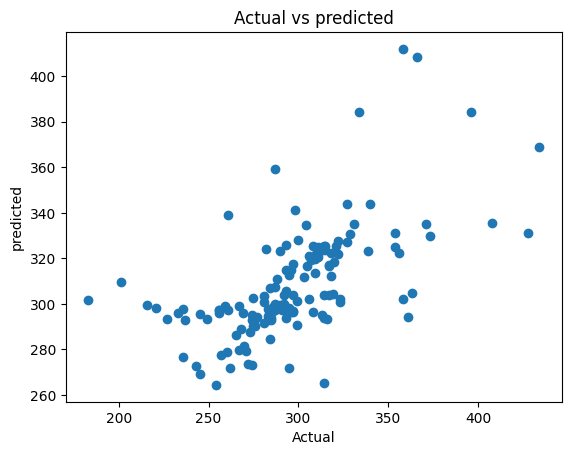

In [73]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test6, np.squeeze(model10.predict(X_test6)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test6, np.squeeze(model10.predict(X_test6)) )
mae= mean_absolute_error(Y_test6, np.squeeze(model10.predict(X_test6)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test6, np.squeeze(model10.predict(X_test6)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [74]:
prediction11 =np.squeeze(model10.predict([[80,2,2,prediction10]]))
print("Prediction: {}".format(prediction11))

y_prd=np.squeeze(np.squeeze(model10.predict(X_test6)) )
predic_dif=pd.DataFrame({'Actual':Y_test6,'predict':y_prd,"differences":Y_test6-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 216ms/step
Prediction: 301.7486877441406
5/5 [==============================] - 0s 7ms/step


,Actual,predict,differences
268,339,323.226013,15.773987
319,317,316.515106,0.484894
846,310,321.890442,-11.890442
704,314,325.579742,-11.579742
1498,243,272.703827,-29.703827
1437,268,288.766724,-20.766724
542,314,303.675323,10.324677
1518,274,273.185394,0.814606
1197,287,307.579773,-20.579773
1095,288,310.777618,-22.777618
